## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[-0.1294,  0.3153]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Data

In [7]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [8]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [9]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [10]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [11]:
df

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7656951 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7656952 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7656953 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7656954 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7656955 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  \
9263                  1                 1             1  ORACLE CORP   
9264                  1                 1             1  ORACLE CORP   
9265                  1                 1             1  ORACLE CORP   
9266                  1                 1             1  ORACLE CORP   
9267                  1                 1             1  ORACLE CORP   
...                 ...               ...           ...          ...   
7656951               1                 1             3    TESLA INC   
7656952               1                 1             3    TESLA INC   
7656953               1                 1             3    TESLA INC   
7656954               1                 1             3    TESLA INC   
7656955               1                 1             3    TESLA INC   

        primary_exchange trading_status security_status     naics  \
9263                   N              A               R  511210.0   
9264                   N              A               R  511210.0   
9265                   N              A               R  511210.0   
9266                   N              A               R  511210.0   
9267                   N              A               R  511210.0   
...                  ...            ...             ...       ...   
7656951                Q              A               R  336110.0   
7656952                Q              A               R  336110.0   
7656953                Q              A               R  336110.0   
7656954                Q              A               R  336110.0   
7656955                Q              A               R  336110.0   

        naics_sector naics_sector_name naics_secondary  ask_or_high_price  \
9263              51       Information          1210.0            47.8011   
9264              51       Information          1210.0            48.0700   
9265              51       Information          1210.0            48.1900   
9266              51       Information          1210.0            48.6300   
9267              51       Information          1210.0            49.0700   
...              ...               ...             ...                ...   
7656951           33     Manufacturing          6110.0           258.2200   
7656952           33     Manufacturing          6110.0           257.9700   
7656953           33     Manufacturing          6110.0           263.3400   
7656954           33     Manufacturing          6110.0           265.1300   
7656955           33     Manufacturing          6110.0           255.1900   

         ask_price  bid_or_low_price  bid_price  open_price  close_price  \
9263      46.63000          46.17000   46.62000    47.57000     46.63000   
9264      47.71000          47.44000   47.70000    47.53000     47.71000   
9265      48.18000          47.71500   48.17000    47.99000     48.18000   
9266      48.45000          48.28000   48.44000    48.42000     48.47000   
9267      48.99000          47.94000   48.98000    48.30000     48.98000   
...            ...               ...        ...         ...          ...   
7656951  252.53999    

In [12]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [13]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.013843        0.013843   
9264    2018-01-03     10104    0.022897        0.022897   
9265    2018-01-04     10104    0.009803        0.009803   
9266    2018-01-05     10104    0.006001        0.006001   
9267    2018-01-08     10104    0.010467        0.010467   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.007731        0.007731   
7656952 2023-12-26     93436    0.015988        0.015988   
7656953 2023-12-27     93436    0.018647        0.018647   
7656954 2023-12-28     93436   -0.032104        0.032104   
7656955 2023-12-29     93436   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263              0.011619      0.136136       0.109282       0.276310  
9264              0.006475      0.091648       0.081082       0.268724  
9265              0.009651      0.089939       0.079524       0.273385  
9266              0.015437      0.105015       0.107098       0.281463  
9267              0.012476      0.105560       0.139328       0.280139  
...                    ...           ...            ...            ...  
7656951           0.000000      0.000000       0.000000       0.000000  
7656952           

### Standardize features and labels

In [14]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] =scaler.fit_transform(data[columns])
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.599913       -0.077145   
9264    2018-01-03     10104    0.953274        0.423184   
9265    2018-01-04     10104    0.399725       -0.300443   
9266    2018-01-05     10104    0.239003       -0.510547   
9267    2018-01-08     10104    0.427805       -0.263735   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                          -0.018430                     -0.009147   
9264                           0.328289                      0.302093   
9265                           0.200733                      0.052181   
9266                           0.500294                      0.420277   
9267                           0.097540                      0.332884   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                   -0.025258              -0.017993      0.511707   
9264                    0.420004               0.618797      0.355892   
9265                    0.277994               0.049970      0.250640   
9266                    0.441800               0.214851      0.348418   
9267                    0.112680               0.446897      0.205187   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.201900       1.097317           0.702858       0.215318   
9264             0.028348       0.879456           0.403960       0.079349   
9265            -0.088885       0.789610           0.280693       0.163295   
9266             0.020023       0.999965           0.569295       0.316238   
9267            -0.139512       0.661939           0.105531       0.237967   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263             -0.548049     -0.716988      -0.942127      -0.192751  
9264             -0.737177     -0.911900      -1.074948      -0.230518  
9265             -0.620411     -0.919385      -1.082285      -0.207312  
9266             -0.407673     -0.853336      -0.952413      -0.167097  
9267             -0.516545     -0.850950      -0.800611      -0.173688  
...                    ...           ...            ...            ...  
7656951          -0.975239     -1.313432      -1.456839      -1.568281  
7656952          -

In [15]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [16]:
# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

date permno_id  log_return  abs_log_return  \
9263   2018-01-02     10104   -0.599913       -0.077145   
9264   2018-01-03     10104    0.953274        0.423184   
9265   2018-01-04     10104    0.399725       -0.300443   
9266   2018-01-05     10104    0.239003       -0.510547   
9267   2018-01-08     10104    0.427805       -0.263735   
...           ...       ...         ...             ...   
128889 2023-12-22     11404    0.207433       -0.551817   
128890 2023-12-26     11404    0.262529       -0.479793   
128891 2023-12-27     11404   -0.235386       -0.553672   
128892 2023-12-28     11404    0.383563       -0.321571   
128893 2023-12-29     11404    0.134281       -0.647445   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                         -0.018430                     -0.009147   
9264                          0.328289                      0.302093   
9265                          0.200733                      0.052181   
9266                          0.500294                      0.420277   
9267                          0.097540                      0.332884   
...                                ...                           ...   
128889                        0.217354                      0.359332   
128890                        0.332728                      0.410886   
128891                       -0.079500                     -0.151032   
128892                        0.236195                      0.117214   
128893                       -0.087243                     -0.318151   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                  -0.025258              -0.017993      0.511707   
9264                   0.420004               0.618797      0.355892   
9265                   0.277994               0.049970      0.250640   
9266                   0.441800               0.214851      0.348418   
9267                   0.112680               0.446897      0.205187   
...                         ...                    ...           ...   
128889                 0.163436               0.338492     -0.128265   
128890                 0.366081               0.290950     -0.128265   
128891                 0.099407               0.074778     -0.128265   
128892                -0.045319               0.156221     -0.128265   
128893                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263            0.201900       1.097317           0.702858       0.215318   
9264            0.028348       0.879456           0.403960       0.079349   
9265           -0.088885       0.789610           0.280693       0.163295   
9266            0.020023       0.999965           0.569295       0.316238   
9267           -0.139512       0.661939           0.105531       0.237967   
...                  ...            ...                ...            ...   
128889         -0.510924      -0.108108          -0.950953      -0.091799   
128890         -0.510924      -0.108108          -0.950953      -0.091799   
128891         -0.510924      -0.108108          -0.950953      -0.091799   
128892         -0.510924      -0.108108          -0.950953      -0.091799   
128893         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263            -0.548049     -0.716988      -0.942127      -0.192751  
9264            -0.737177     -0.911900      -1.074948      -0.230518  
9265            -0.620411     -0.919385      -1.082285      -0.207312  
9266            -0.407673     -0.853336      -0.952413      -0.167097  
9267            -0.516545     -0.850950      -0.800611      -0.173688  
...                   ...           ...            ...            ...  
128889          -0.975239     -1.313432      -1.456839      -1.568281  
128890          -0.975239     -1.313432      -1.456839      -1.568281  
1

In [17]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
10696      1509        1477            1477                            1482   
10909      1117        1086            1086                            1102   
11308      1509        1467            1467                            1480   
11403      1509        1494            1494                            1475   
11404      1509        1472            1472                            1471   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107                              1489                     1482   
10138                              1480                     1482   
10145                              1480                     1482   
10516                              1467                     1482   
10696                              1489                     1482   
10909                              1105                     1103   
11308                              1467                     1482   
11403                              1481                     1482   
11404                              1483                     1482   

           simple_avg_log_return  log_return_7  abs_log_return_7  \
permno_id                                                          
10104                       1484          1503              1503   
10107                       1484          1503              1503   
10138                       1484          1503              1503   
10145                       1484          1503              1503   
10516                       1484          1503              1503   
10696                       1484          1502              1502   
10909                       1103          1111              1111   
11308                       1484          1502              1502   
11403                       1484          1503              1503   
11404                       1484          1503              1503   

           log_return_14  abs_log_return_14  log_return_28  abs_log_return_28  \
permno_id                                                                       
10104               1496               1496           1482               1482   
10107               1496               1496           1482               1482   
10138               1496               1496           1482               1482   
10145               1496               1496           1482               1482   
10516               1496               1496           1482               1482   
10696               1496               1496           1482               1482   
10909               1104               1104           1090               1090   
11308               1496               1496           1481               1481   
11403               1496               1496           1482               1482   
11404               1496               1496           1482               1482   

           volatility_7  volatility_14  volatility_28  
permno_id                                              
10104              1503           1496           1482  
10107              1503           1496           1482  
10138              1503           1496           1482  
10145              1503           1496           1482  
10516              1503           1496           1482  
10696              1502           1496           1482  
10909  

In [18]:
data = data.loc[data["permno_id"] != "10909"]

In [19]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
10696      1509        1477            1477                            1482   
11308      1509        1467            1467                            1480   
11403      1509        1494            1494                            1475   
11404      1509        1472            1472                            1471   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107                              1489                     1482   
10138                              1480                     1482   
10145                              1480                     1482   
10516                              1467                     1482   
10696                              1489                     1482   
11308                              1467                     1482   
11403                              1481                     1482   
11404                              1483                     1482   

           simple_avg_log_return  log_return_7  abs_log_return_7  \
permno_id                                                          
10104                       1484          1503              1503   
10107                       1484          1503              1503   
10138                       1484          1503              1503   
10145                       1484          1503              1503   
10516                       1484          1503              1503   
10696                       1484          1502              1502   
11308                       1484          1502              1502   
11403                       1484          1503              1503   
11404                       1484          1503              1503   

           log_return_14  abs_log_return_14  log_return_28  abs_log_return_28  \
permno_id                                                                       
10104               1496               1496           1482               1482   
10107               1496               1496           1482               1482   
10138               1496               1496           1482               1482   
10145               1496               1496           1482               1482   
10516               1496               1496           1482               1482   
10696               1496               1496           1482               1482   
11308               1496               1496           1481               1481   
11403               1496               1496           1482               1482   
11404               1496               1496           1482               1482   

           volatility_7  volatility_14  volatility_28  
permno_id                                              
10104              1503           1496           1482  
10107              1503           1496           1482  
10138              1503           1496           1482  
10145              1503           1496           1482  
10516              1503           1496           1482  
10696              1502           1496           1482  
11308              1502           1496           1481  
11403              1503           1496           1482  
11404              1503           1496           1482

In [20]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [21]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

In [22]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # Add positional encoding
    data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [23]:
# Input parameters
input_columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [24]:
data = create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size)
data

date permno_id  log_return  abs_log_return  \
9391   2018-07-06     10104    0.531053       -0.128765   
9392   2018-07-09     10104    0.650947        0.027967   
9393   2018-07-10     10104    0.219879       -0.535547   
9394   2018-07-11     10104    0.566093       -0.082958   
9395   2018-07-12     10104    0.435460       -0.253728   
...           ...       ...         ...             ...   
128889 2023-12-22     11404    0.207433       -0.551817   
128890 2023-12-26     11404    0.262529       -0.479793   
128891 2023-12-27     11404   -0.235386       -0.553672   
128892 2023-12-28     11404    0.383563       -0.321571   
128893 2023-12-29     11404    0.134281       -0.647445   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9391                          0.703972                      0.861647   
9392                          0.223797                      0.293724   
9393                          0.024342                     -0.284485   
9394                         -0.068889                     -0.093346   
9395                          0.826547                      1.174293   
...                                ...                           ...   
128889                        0.217354                      0.359332   
128890                        0.332728                      0.410886   
128891                       -0.079500                     -0.151032   
128892                        0.236195                      0.117214   
128893                       -0.087243                     -0.318151   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9391                   0.625893               0.224981      0.693460   
9392                   0.937742               0.723214      0.396582   
9393                   0.214795              -0.136608      0.270789   
9394                  -0.971816               0.155344      0.122079   
9395                   0.601231               0.086982      0.033640   
...                         ...                    ...           ...   
128889                 0.163436               0.338492     -0.128265   
128890                 0.366081               0.290950     -0.128265   
128891                 0.099407               0.074778     -0.128265   
128892                -0.045319               0.156221     -0.128265   
128893                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9391            0.404344       0.686261           0.138900       0.277221   
9392            0.073671       0.424256          -0.220563       0.188424   
9393           -0.066442       0.125852          -0.629966       0.187066   
9394           -0.232081      -0.051746          -0.873626       0.079980   
9395           -0.330588      -0.258700          -0.744345      -0.012673   
...                  ...            ...                ...            ...   
128889         -0.510924      -0.108108          -0.950953      -0.091799   
128890         -0.510924      -0.108108          -0.950953      -0.091799   
128891         -0.510924      -0.108108          -0.950953      -0.091799   
128892         -0.510924      -0.108108          -0.950953      -0.091799   
128893         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  \
9391            -0.461943     -0.958115      -0.967099      -0.945301   
9392            -0.585458     -0.850898      -0.996023      -0.981738   
9393            -0.587347     -0.774938      -0.827328      -0.982006   
9394            -0.736299     -0.845782      -0.885325      -1.015226   
9395            -0.865176     -0.904680      -0.914398      -1.036967   
...                   ...           ...            ...            ...   
128889          -0.975239     -1.313432      -1.456839      -1.568281   
128890          -0.975239     -1.313432      -1.456839      -1.56

In [25]:
data.columns

Index(['date', 'permno_id', 'log_return', 'abs_log_return',
       'sector_weighted_avg_log_return', 'sector_simple_avg_log_return',
       'weighted_avg_log_return', 'simple_avg_log_return', 'log_return_7',
       'abs_log_return_7',
       ...
       'simple_avg_log_return_past_120', 'simple_avg_log_return_past_121',
       'simple_avg_log_return_past_122', 'simple_avg_log_return_past_123',
       'simple_avg_log_return_past_124', 'simple_avg_log_return_past_125',
       'simple_avg_log_return_past_126', 'simple_avg_log_return_past_127',
       'simple_avg_log_return_past_128', 'positional_encoding'],
      dtype='object', length=658)

### Check inf and missing values

In [26]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [27]:
data[-30:]

date permno_id  log_return  abs_log_return  \
128864 2023-11-16     11404    0.255220       -0.489347   
128865 2023-11-17     11404    0.091881       -0.702873   
128866 2023-11-20     11404   -0.209472       -0.587549   
128867 2023-11-21     11404   -0.224381       -0.568059   
128868 2023-11-22     11404   -0.000653       -0.823838   
128869 2023-11-24     11404    0.190314       -0.574196   
128870 2023-11-27     11404   -0.149674       -0.665720   
128871 2023-11-28     11404    0.045892       -0.762991   
128872 2023-11-29     11404   -0.416979       -0.316285   
128873 2023-11-30     11404    0.065138       -0.737833   
128874 2023-12-01     11404    0.715525        0.112386   
128875 2023-12-04     11404    0.128004       -0.655651   
128876 2023-12-05     11404   -0.383959       -0.359451   
128877 2023-12-06     11404    0.198012       -0.564133   
128878 2023-12-07     11404    0.348161       -0.367850   
128879 2023-12-08     11404   -0.423680       -0.307525   
128880 2023-12-11     11404    0.132807       -0.649372   
128881 2023-12-12     11404   -0.079162       -0.757896   
128882 2023-12-13     11404    1.023250        0.514660   
128883 2023-12-14     11404   -0.969728        0.406296   
128884 2023-12-15     11404   -0.972971        0.410536   
128885 2023-12-18     11404    0.055812       -0.750024   
128886 2023-12-19     11404    0.130658       -0.652181   
128887 2023-12-20     11404   -0.466473       -0.251584   
128888 2023-12-21     11404   -0.080983       -0.755516   
128889 2023-12-22     11404    0.207433       -0.551817   
128890 2023-12-26     11404    0.262529       -0.479793   
128891 2023-12-27     11404   -0.235386       -0.553672   
128892 2023-12-28     11404    0.383563       -0.321571   
128893 2023-12-29     11404    0.134281       -0.647445   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
128864                        0.162347                      0.099774   
128865                        0.129862                      0.114084   
128866                       -0.133046                     -0.248838   
128867                        0.074855                     -0.095071   
128868                        0.215730                      0.486013   
128869                        0.123311                      0.108398   
128870                        0.001873                     -0.016047   
128871                        0.140257                      0.115361   
128872                       -0.352749                     -0.346388   
128873                        0.333161                      0.429795   
128874                        0.669701                      0.985900   
128875                       -0.197744                      0.035507   
128876                       -0.543000                     -0.571705   
128877                        0.539925                      0.376197   
128878                       -0.163256                     -0.100373   
128879                       -0.055787                     -0.118069   
128880                        0.161643                      0.053586   
128881                       -0.378954                     -0.410527   
128882                        1.831781                      2.155733   
128883                       -0.380091                     -0.246027   
128884                       -0.845540                     -0.823469   
128885                       -0.127578                     -0.110019   
128886                        0.385678                      0.725959   
128887                       -1.058097                     -1.220504   
128888                        0.221036                      0.479241   
128889                        0.217354                      0.359332   
128890                        0.332728                      0.410886   
128891                       -0.079500                     -0.151032   
128892                        0.236195                      0.117214   
128893                 

In [28]:
data.describe().T

count                           mean  \
date                              12429  2021-04-02 10:31:53.396089856   
log_return                      12429.0                       0.008217   
abs_log_return                  12429.0                      -0.158733   
sector_weighted_avg_log_return  12429.0                      -0.004306   
sector_simple_avg_log_return    12429.0                      -0.004241   
...                                 ...                            ...   
simple_avg_log_return_past_125  12429.0                      -0.004911   
simple_avg_log_return_past_126  12429.0                      -0.005039   
simple_avg_log_return_past_127  12429.0                       -0.00514   
simple_avg_log_return_past_128  12429.0                      -0.005711   
positional_encoding             12429.0                          819.0   

                                                min                  25%  \
date                            2018-07-06 00:00:00  2019-11-18 00:00:00   
log_return                                -7.723937             -0.33652   
abs_log_return                            -0.842183            -0.628563   
sector_weighted_avg_log_return           -24.468989            -0.347714   
sector_simple_avg_log_return              -9.049031            -0.441574   
...                                             ...                  ...   
simple_avg_log_return_past_125            -7.600762            -0.475464   
simple_avg_log_return_past_126            -7.600762            -0.475464   
simple_avg_log_return_past_127            -7.600762            -0.475464   
simple_avg_log_return_past_128            -7.600762            -0.475464   
positional_encoding                           129.0                474.0   

                                                50%                  75%  \
date                            2021-04-05 00:00:00  2022-08-16 00:00:00   
log_return                                 0.030439              0.37837   
abs_log_return                            -0.371028             0.045032   
sector_weighted_avg_log_return             0.028294             0.377827   
sector_simple_avg_log_return               0.034741             0.484352   
...                                             ...                  ...   
simple_avg_log_return_past_125             0.027954              0.51119   
simple_avg_log_return_past_126             0.027954              0.51119   
simple_avg_log_return_past_127             0.027954              0.51119   
simple_avg_log_return_past_128             0.027635             0.510073   
positional_encoding                           819.0               1164.0   

                                                max         std  
date                            2023-12-29 00:00:00         NaN  
log_return                                  7.84312    0.775659  
abs_log_return                             9.429936    0.749608  
sector_weighted_avg_log_return            34.312784    0.904113  
sector_simple_avg_log_return               8.191692    0.954038  
...                                             ...         ...  
simple_avg_log_return_past_125             8.036367    1.030563  
simple_avg_log_return_past_126             8.036367    1.030545  
simple_avg_log_return_past_127             8.036367    1.030477  
simple_avg_log_return_past_128             8.036367    1.030265  
positional_encoding                          1509.0  398.676295  

[657 rows x 8 columns]

In [29]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [30]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

In [31]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [32]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

date permno_id  log_return  abs_log_return  \
12147 2023-10-09     11404    0.568762       -0.079470   
12148 2023-10-10     11404    0.259673       -0.483527   
12149 2023-10-11     11404    0.143337       -0.635606   
12150 2023-10-12     11404   -0.534039       -0.163259   
12151 2023-10-13     11404    0.298674       -0.432542   
12152 2023-10-16     11404    0.291582       -0.441814   
12153 2023-10-17     11404    0.099597       -0.692786   
12154 2023-10-18     11404   -0.310544       -0.455423   
12155 2023-10-19     11404   -0.307819       -0.458985   
12156 2023-10-20     11404   -0.309863       -0.456313   
12157 2023-10-23     11404   -0.243546       -0.543005   
12158 2023-10-24     11404    0.653735        0.031611   
12159 2023-10-25     11404    0.148391       -0.629000   
12160 2023-10-26     11404    0.456620       -0.226068   
12161 2023-10-27     11404   -0.890024        0.302103   
12162 2023-10-30     11404   -0.009867       -0.835883   
12163 2023-10-31     11404    0.134871       -0.646674   
12164 2023-11-01     11404    0.639918        0.013549   
12165 2023-11-02     11404    0.456829       -0.225795   
12166 2023-11-03     11404   -0.056898       -0.787002   
12167 2023-11-06     11404    0.205330       -0.554566   
12168 2023-11-07     11404   -0.512560       -0.191337   
12169 2023-11-08     11404   -0.394365       -0.345847   
12170 2023-11-09     11404    0.256187       -0.488084   
12171 2023-11-10     11404    0.032635       -0.780322   
12172 2023-11-13     11404   -0.480918       -0.232701   
12173 2023-11-14     11404    1.368865        0.966466   
12174 2023-11-15     11404    0.008685       -0.811630   
12175 2023-11-16     11404    0.255220       -0.489347   
12176 2023-11-17     11404    0.091881       -0.702873   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
12147                        0.623248                      0.620104   
12148                        0.737323                      0.729089   
12149                        0.775438                      0.669486   
12150                       -0.697356                     -0.873554   
12151                        0.491361                      0.197963   
12152                        0.529747                      0.731772   
12153                       -0.098720                      0.019472   
12154                       -0.520640                     -0.712567   
12155                       -0.484907                     -0.601921   
12156                       -0.599632                     -0.711737   
12157                       -0.466770                     -0.533949   
12158                        1.103748                      0.964563   
12159                        0.121741                     -0.093282   
12160                        0.366079                      0.435162   
12161                       -0.999733                     -1.232131   
12162                        0.266785                      0.182247   
12163                        0.442905                      0.520638   
12164                        0.590601                      0.743974   
12165                        1.189020                      1.546861   
12166                        0.216650                      0.683540   
12167                       -0.402505                     -0.537271   
12168                       -0.502016                     -0.694808   
12169                       -0.480576                     -0.721703   
12170                       -0.629247                     -0.497664   
12171                        0.196889                      0.029310   
12172                       -0.557564                     -0.418001   
12173                        2.043742                      2.812135   
12174                       -0.141167                     -0.123562   
12175                        0.162347                      0.099774   
12176                        0.129862                      0.114084   

       weig

In [33]:
cleaned_data.isnull().sum()

date                              0
permno_id                         0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
                                 ..
simple_avg_log_return_past_125    0
simple_avg_log_return_past_126    0
simple_avg_log_return_past_127    0
simple_avg_log_return_past_128    0
positional_encoding               0
Length: 658, dtype: int64

In [34]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [35]:
# train_data

In [36]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Cases: 4 dimensions input

In [37]:
cleaned_data

date permno_id  log_return  abs_log_return  \
0     2018-07-06     10104    0.531053       -0.128765   
1     2018-07-09     10104    0.650947        0.027967   
2     2018-07-10     10104    0.219879       -0.535547   
3     2018-07-11     10104    0.566093       -0.082958   
4     2018-07-12     10104    0.435460       -0.253728   
...          ...       ...         ...             ...   
12172 2023-11-13     11404   -0.480918       -0.232701   
12173 2023-11-14     11404    1.368865        0.966466   
12174 2023-11-15     11404    0.008685       -0.811630   
12175 2023-11-16     11404    0.255220       -0.489347   
12176 2023-11-17     11404    0.091881       -0.702873   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                            0.703972                      0.861647   
1                            0.223797                      0.293724   
2                            0.024342                     -0.284485   
3                           -0.068889                     -0.093346   
4                            0.826547                      1.174293   
...                               ...                           ...   
12172                       -0.557564                     -0.418001   
12173                        2.043742                      2.812135   
12174                       -0.141167                     -0.123562   
12175                        0.162347                      0.099774   
12176                        0.129862                      0.114084   

       weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                     0.625893               0.224981      0.693460   
1                     0.937742               0.723214      0.396582   
2                     0.214795              -0.136608      0.270789   
3                    -0.971816               0.155344      0.122079   
4                     0.601231               0.086982      0.033640   
...                        ...                    ...           ...   
12172                -0.055424              -0.073910      0.253663   
12173                 1.670493               1.431955     -0.073611   
12174                 0.117054               0.532887     -0.114117   
12175                -0.125864               0.310174     -0.166477   
12176                 0.212758              -0.070321     -0.288336   

       abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0              0.404344       0.686261           0.138900       0.277221   
1              0.073671       0.424256          -0.220563       0.188424   
2             -0.066442       0.125852          -0.629966       0.187066   
3             -0.232081      -0.051746          -0.873626       0.079980   
4             -0.330588      -0.258700          -0.744345      -0.012673   
...                 ...            ...                ...            ...   
12172         -0.085518       0.490673          -0.129441       0.109682   
12173         -0.450048      -0.017842          -0.827110      -0.113410   
12174         -0.495165       0.035788          -0.753532      -0.162375   
12175         -0.468362       0.062227          -0.717258      -0.136639   
12176         -0.332631      -0.083502          -0.917194      -0.128131   

       abs_log_return_28  volatility_7  volatility_14  volatility_28  \
0              -0.461943     -0.958115      -0.967099      -0.945301   
1              -0.585458     -0.850898      -0.996023      -0.981738   
2              -0.587347     -0.774938      -0.827328      -0.982006   
3              -0.736299     -0.845782      -0.885325      -1.015226   
4              -0.865176     -0.904680      -0.914398      -1.036967   
...                  ...           ...            ...            ...   
12172          -0.694985     -0.411351      -0.672068      -0.649013   
12173          -0.945178     -1.011325      -0.946702      -0.786099   
12174          -0.877070     -0.994054      -0.9

#### Standardize features and labels

In [38]:
# from sklearn.preprocessing import StandardScaler

# # Copy the cleaned_data to standardized_data
# standardized_data = cleaned_data.copy()

# # List of columns to exclude from standardization
# exclude_columns = ['date', 'permno_id']

# # Extract the columns to be standardized
# columns_to_standardize = [col for col in standardized_data.columns if col not in exclude_columns]

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the selected columns
# standardized_data[columns_to_standardize] = scaler.fit_transform(standardized_data[columns_to_standardize])

# standardized_data


In [39]:
# standardized_data[standardized_data['permno_id']=='10104']

#### Create Dataset

In [40]:
class FinancialDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby(["date"])
        self.sequences = []

        for name, group in self.groups:
            X = group.drop(columns=[
                "date",
                "permno_id",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
            ] + self.target_columns)

            X = X.apply(pd.to_numeric, errors="coerce").values

            y = group[self.target_columns].values
            self.sequences.append((X, y))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            #"permno_id": permno_id,
        }

#### Train 10 Stocks

In [41]:
standardized_data = cleaned_data.copy()

In [42]:
%%time
# Prepare Data 
#standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)

# Ensure the data is sorted by date for each permno_id
standardized_data = standardized_data.sort_values(by=["date", "permno_id"])

# # Filter the first n stocks
n_stocks = 10  # Adjust n as needed
# standardized_data_n_stocks = filter_first_n_stocks(standardized_data, n_stocks)
standardized_data_n_stocks = standardized_data.copy()

# Split data
train_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] <= "2023-09-30"]
validation_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 1318
Validation Dataset Length: 163
{'features': tensor([[ 6.3259e-01, -2.3156e-01,  8.3075e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [ 2.8726e-01, -4.2244e-01,  5.8127e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [-1.0246e-01, -3.0229e-01,  1.4161e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        ...,
        [ 6.2435e-01,  2.1660e-01, -1.2084e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [ 6.0794e-01,  2.3935e-02,  4.3195e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [ 2.6992e-01,  5.0029e-02,  1.8001e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02]]), 'target': tensor([[ 0.5311, -0.1288,  0.6935,  0.4043,  0.6863,  0.1389,  0.2772, -0.4619,
         -0.9581, -0.9671, -0.9453],
        [ 0.5745, -0.0720,  0.4273,  0.1079,  0.8924,  0.4217,  0.4764, -0.1849,
         -0.6974, -0.5381, -0.6331],
        [-0.0110, -0.8374,  0.3655,  0.0391,  0.52

In [43]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[ 6.3259e-01, -2.3156e-01,  8.3075e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [ 2.8726e-01, -4.2244e-01,  5.8127e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [-1.0246e-01, -3.0229e-01,  1.4161e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         ...,
         [ 6.2435e-01,  2.1660e-01, -1.2084e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [ 6.0794e-01,  2.3935e-02,  4.3195e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [ 2.6992e-01,  5.0029e-02,  1.8001e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02]],

        [[ 5.3105e-01,  6.3259e-01, -2.3156e-01,  ...,  4.9970e-02,
           6.1880e-01,  1.3000e+02],
         [ 5.7447e-01,  2.8726e-01, -4.2244e-01,  ...,  4.9970e-02,
           6.1880e-01,  1.3000e+02],
         [-1.1009e-02, -1.0246e-01, -3.0229e-01,  ...,  4.9970e-02,
           6.1880e-01,  1.3000e+02],
         ...,
         [-3

In [44]:
batch["features"].shape

torch.Size([32, 9, 641])

In [45]:
batch["target"].shape

torch.Size([32, 9, 11])

In [46]:
#len(batch["permno_id"])

In [47]:
batch["features"][-1:].shape

torch.Size([1, 9, 641])

#### 1-Origninal Model

#### Build and Train Model

In [48]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        #print(x.shape)
        x = self.input_embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        input_embedding = x
        x = self.transformer(x)
        #output_embedding = x[-1, :, :]  # Get the last output token
        output_embedding = x
        x = self.hidden_layers(output_embedding)
        x = self.fc(x)
        x = x.transpose(0, 1)
        return x, output_embedding

Starting Training...
Batch 0/42, Loss: 0.4843, Estimated time left for epoch: 00:00:04, Estimated time left for training: 00:00:20
Batch 20/42, Loss: 0.4745, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:03
Batch 40/42, Loss: 0.4328, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Epoch 1/5 took 0.71 seconds
Epoch 1/5, Training Loss: 0.5014852987868446, Validation Loss: 0.4141027232011159
Batch 0/42, Loss: 0.4143, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Batch 20/42, Loss: 0.4430, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Batch 40/42, Loss: 0.4193, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:01
Epoch 2/5 took 0.59 seconds
Epoch 2/5, Training Loss: 0.4752817530007589, Validation Loss: 0.38806090752283734
Batch 0/42, Loss: 0.3728, Estimated time left for epoch: 00:00:00, Estimated time left for tra

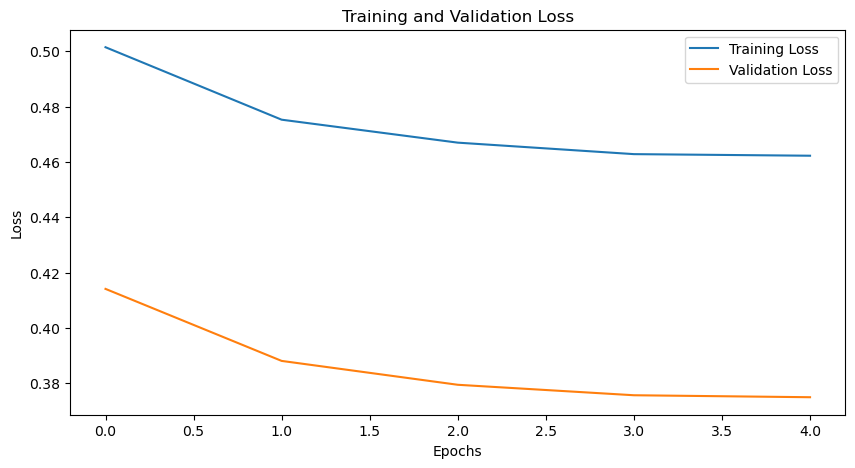

CPU times: user 4.22 s, sys: 513 ms, total: 4.74 s
Wall time: 3.36 s


In [49]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = 128*5+1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values

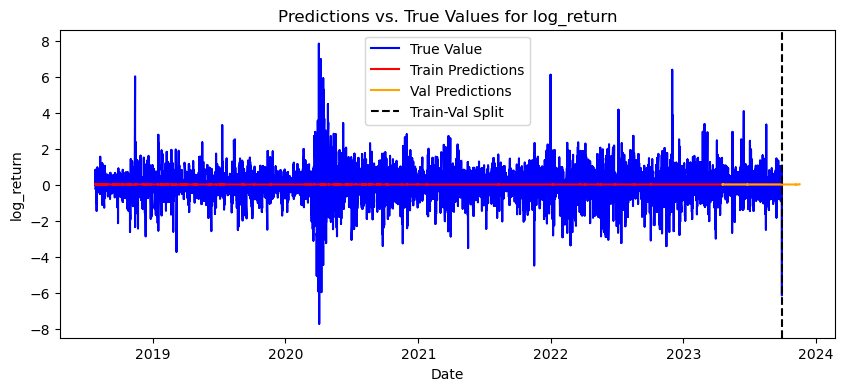

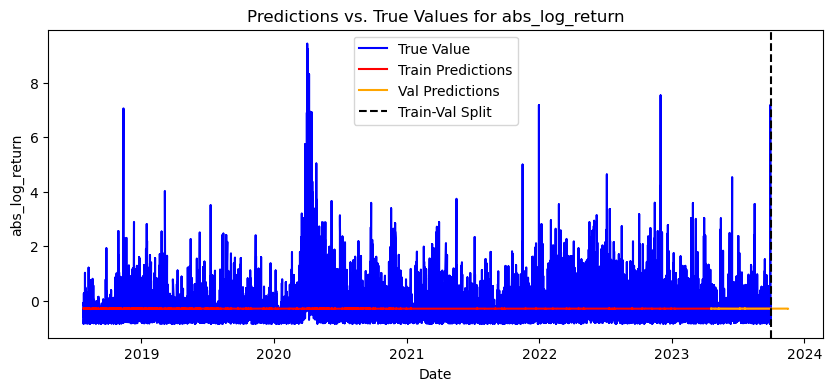

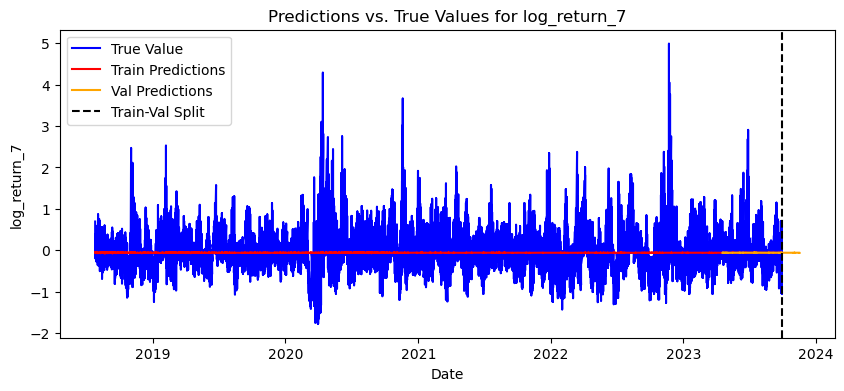

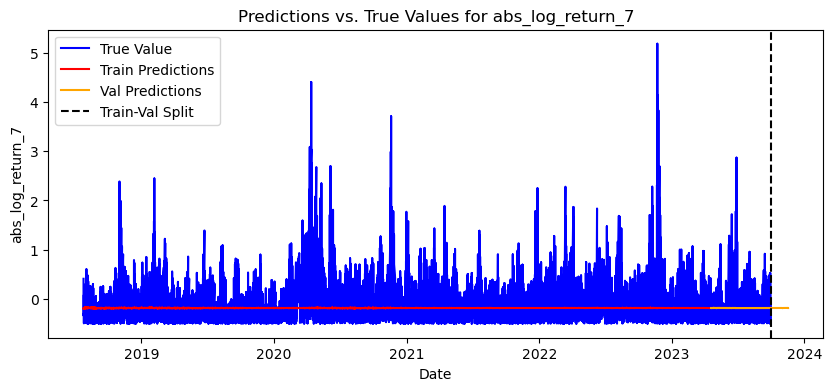

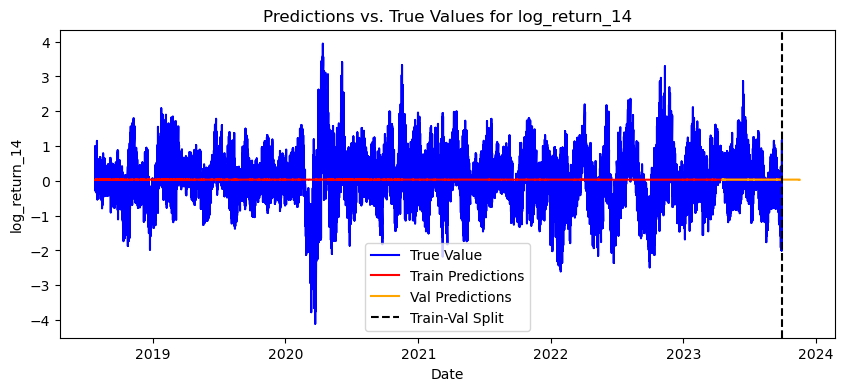

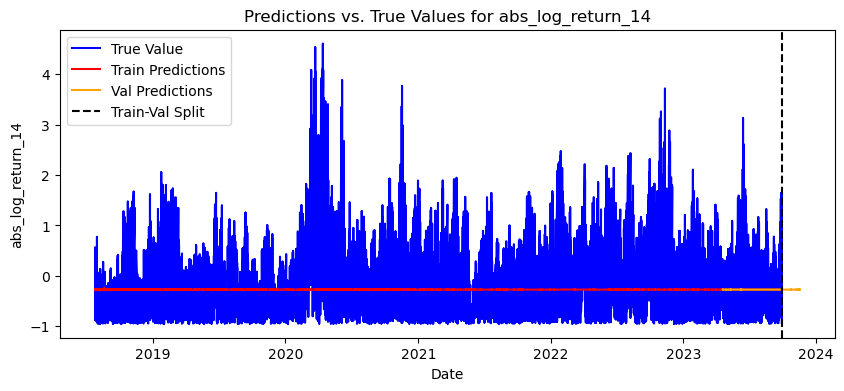

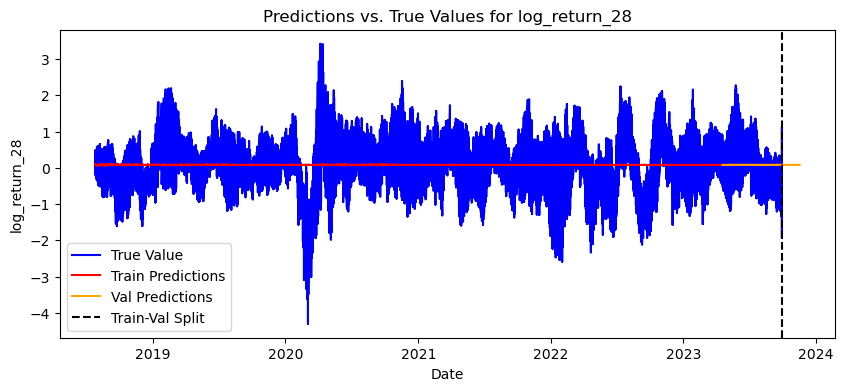

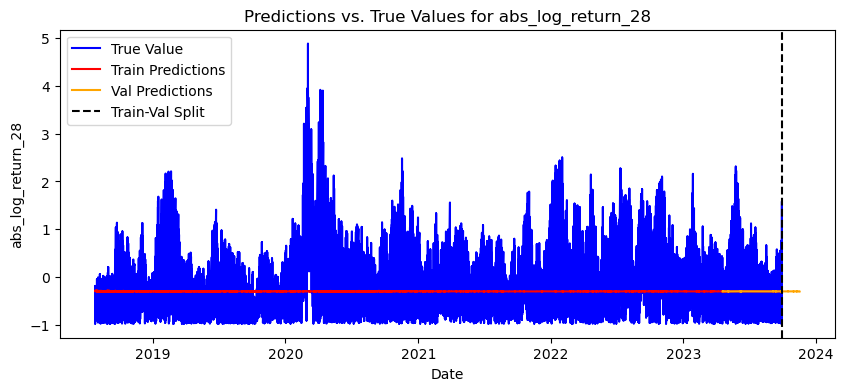

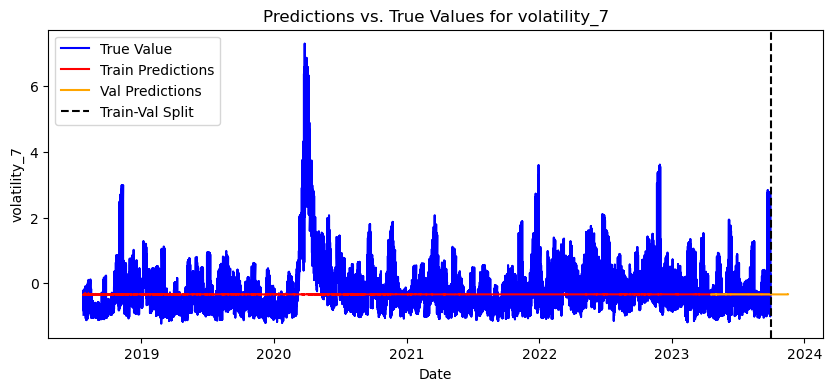

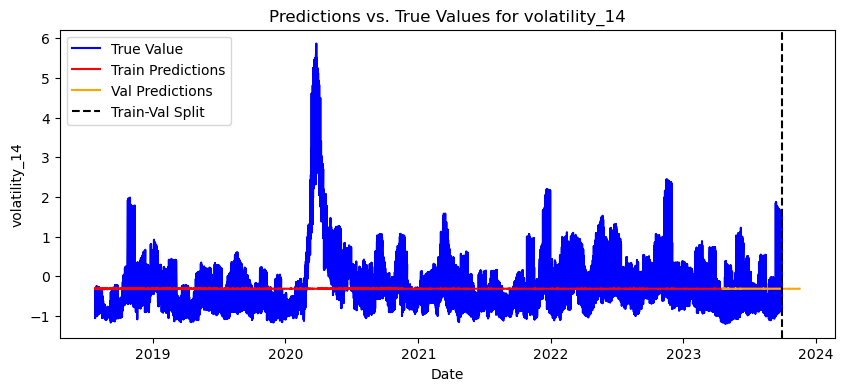

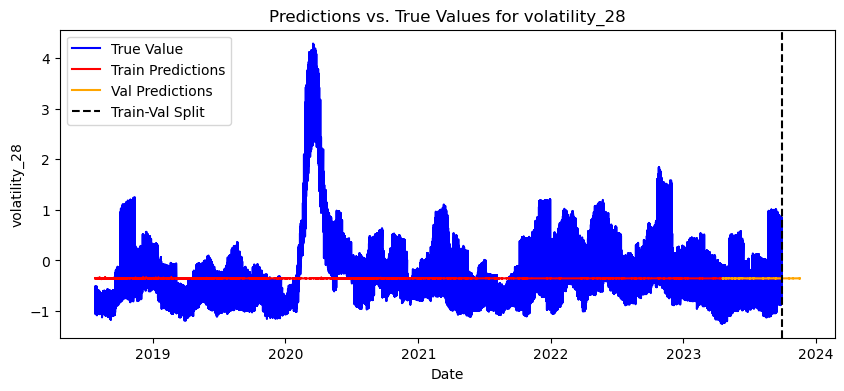

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-09-30'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)



#### Plot Prediction vs True Values (scaler.inverse_transform)

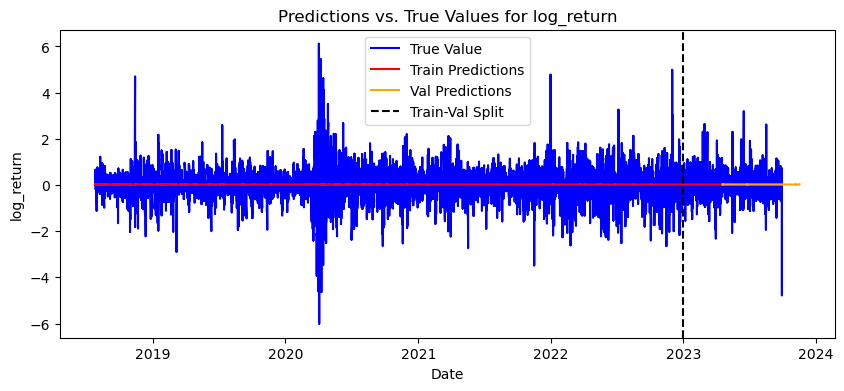

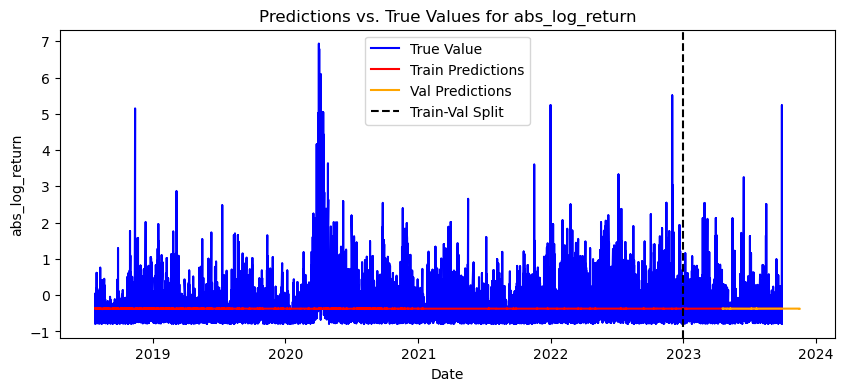

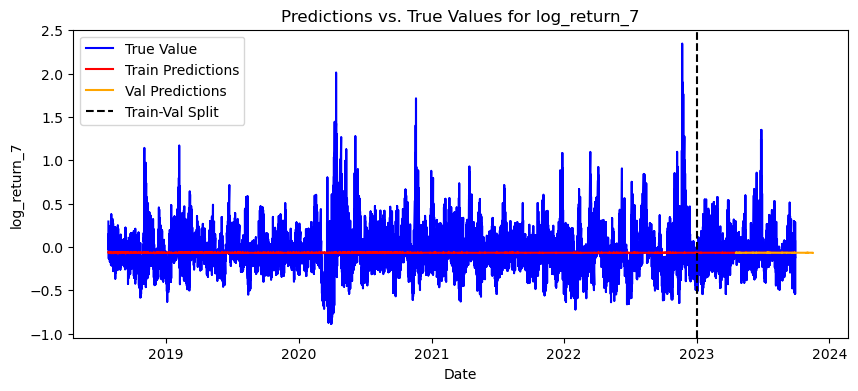

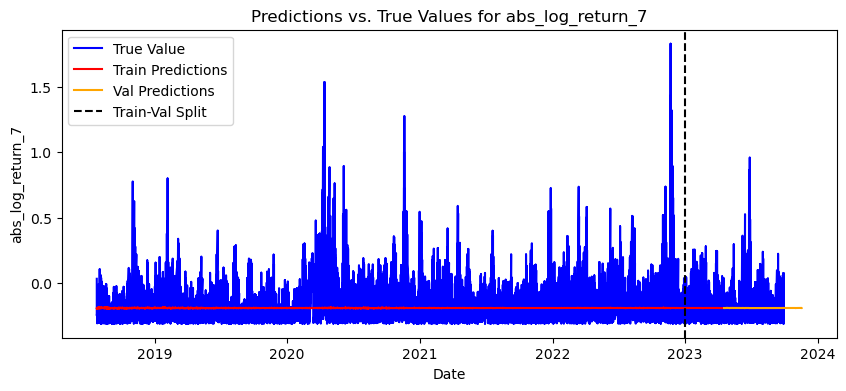

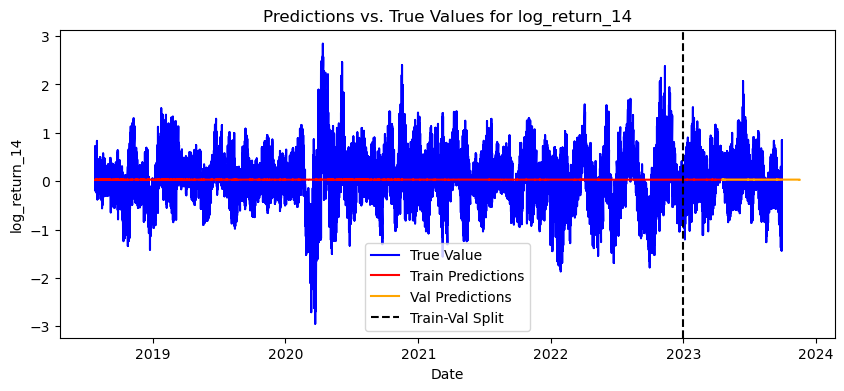

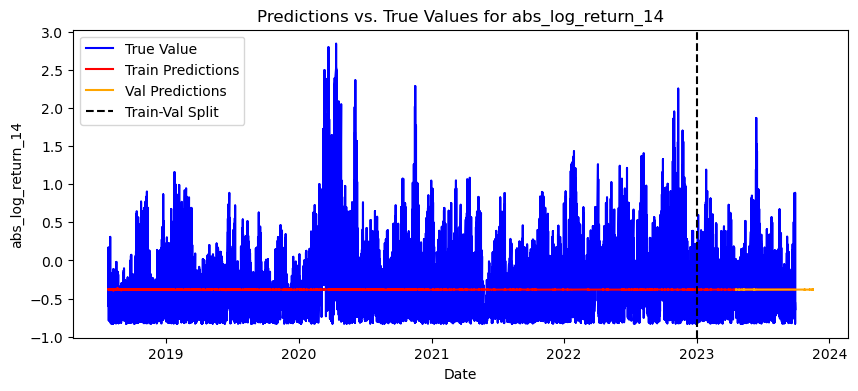

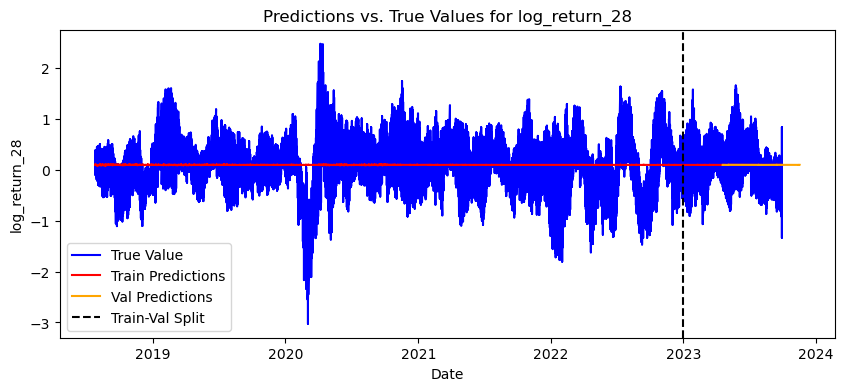

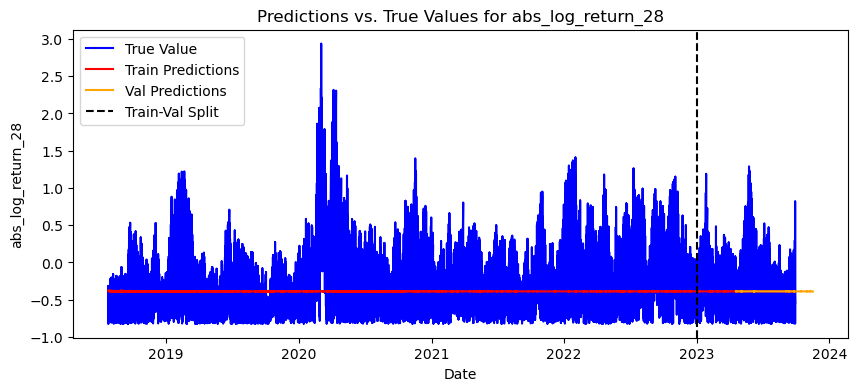

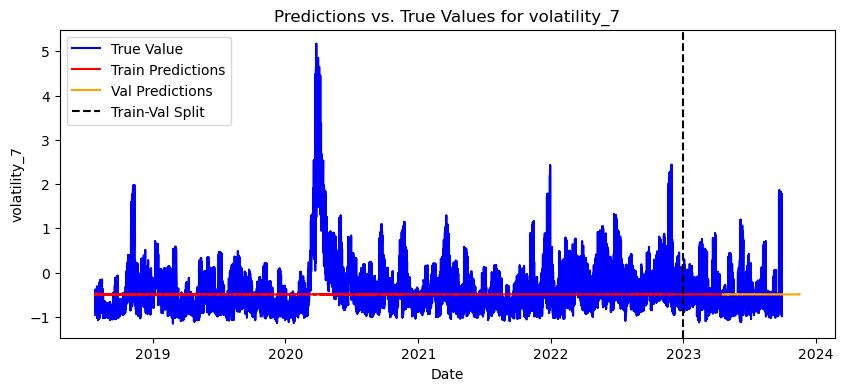

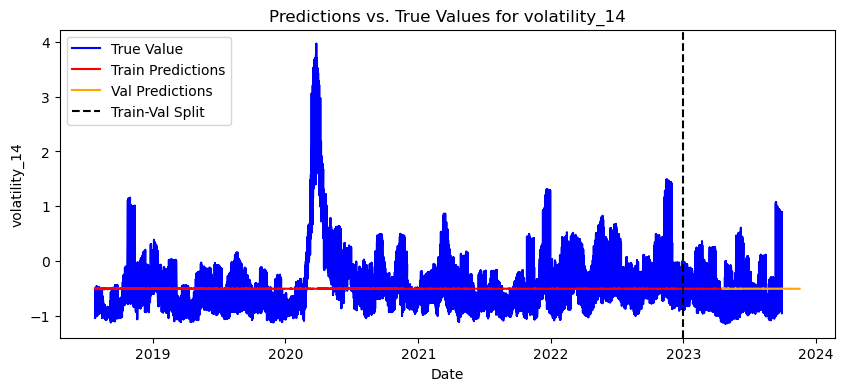

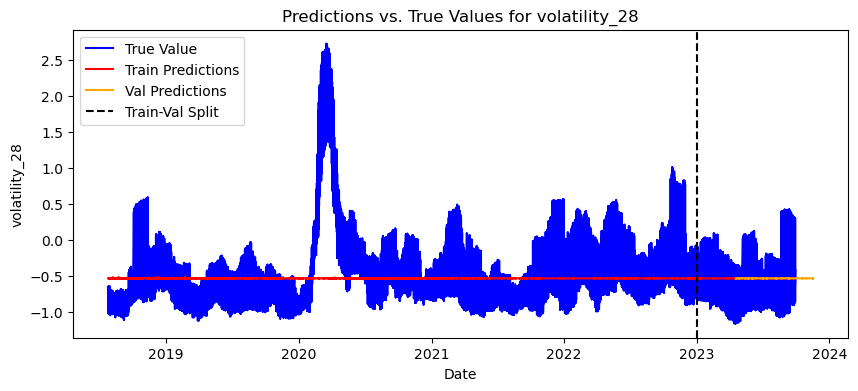

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Standardize the relevant columns
columns_to_scale = [
    "log_return",
    # "sector_weighted_avg_log_return",
    # "sector_simple_avg_log_return",
    # "weighted_avg_log_return",
    # "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28"
]

scaler = StandardScaler()
standardized_data[columns_to_scale] = scaler.fit_transform(standardized_data[columns_to_scale])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values for each target column separately
train_predictions = scaler.inverse_transform(train_predictions)
train_true_values = scaler.inverse_transform(train_true_values)
val_predictions = scaler.inverse_transform(val_predictions)
val_true_values = scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-01-01'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


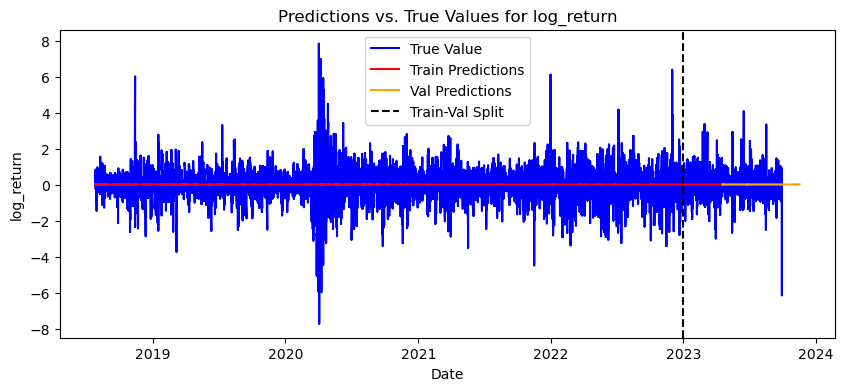

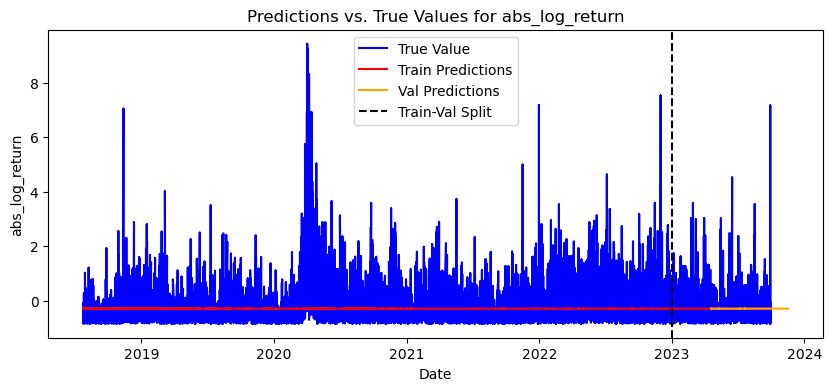

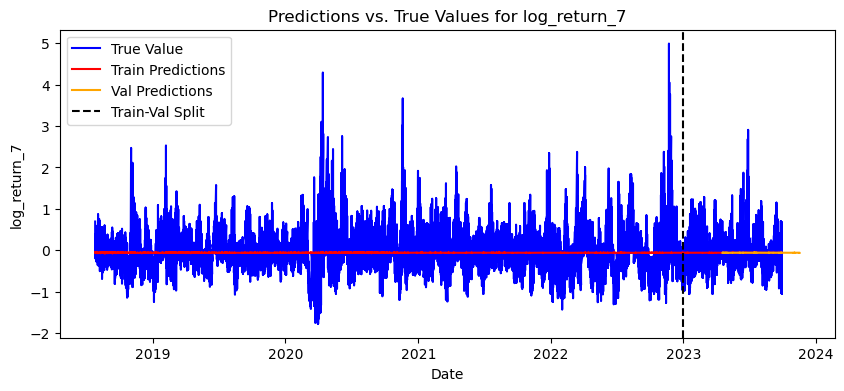

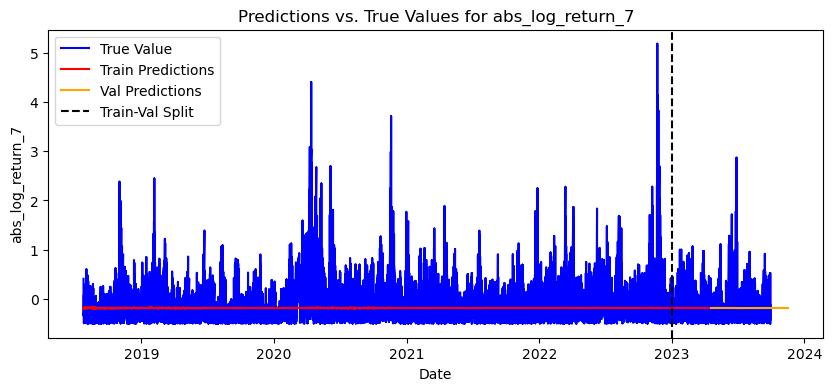

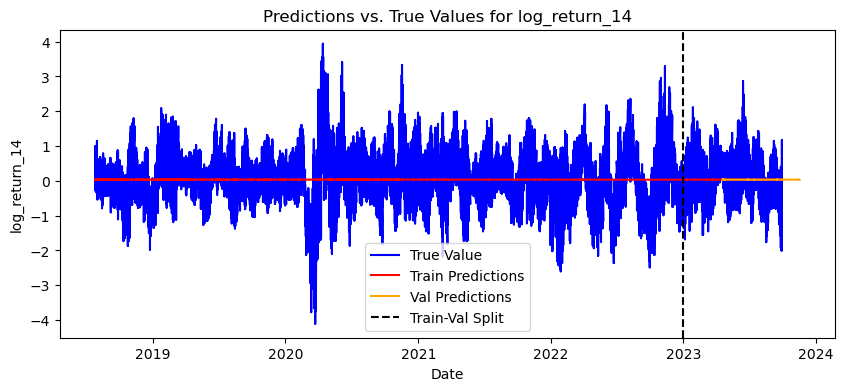

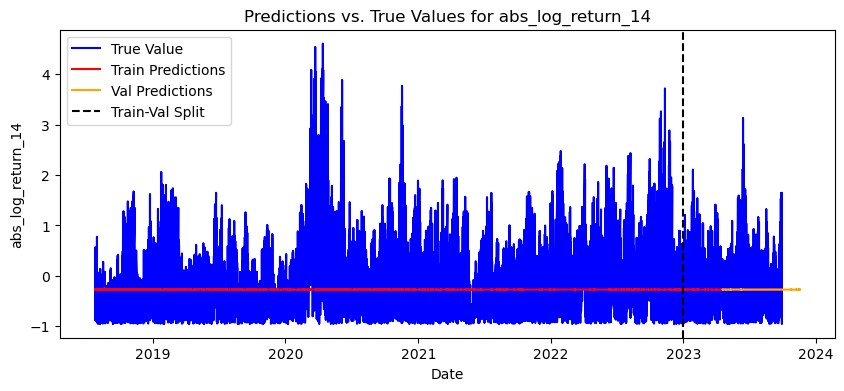

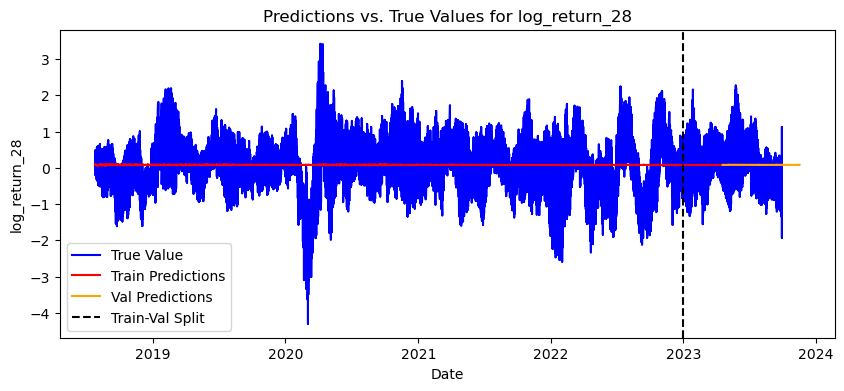

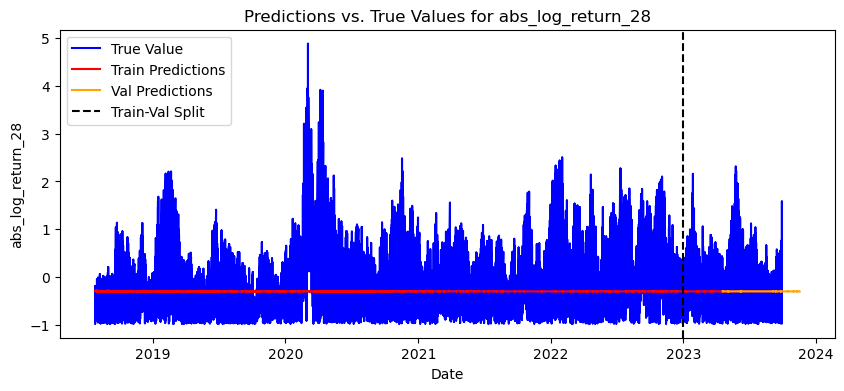

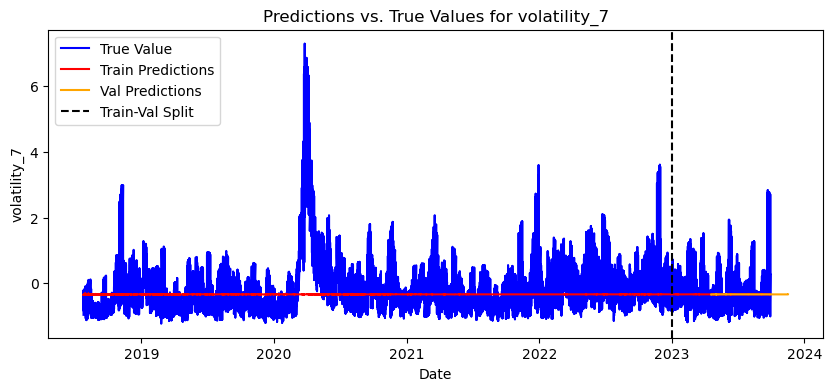

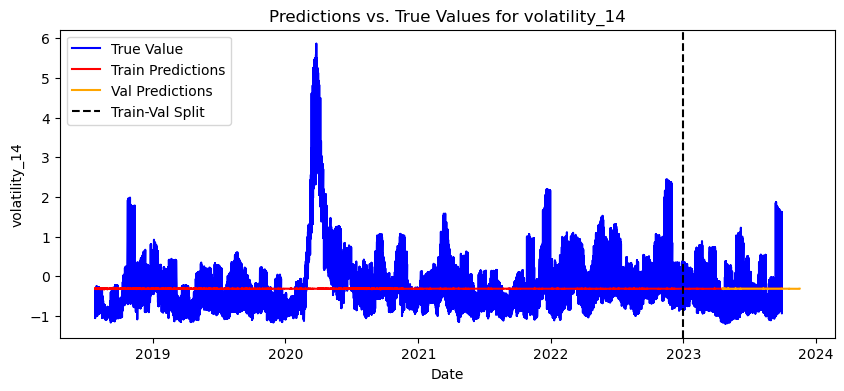

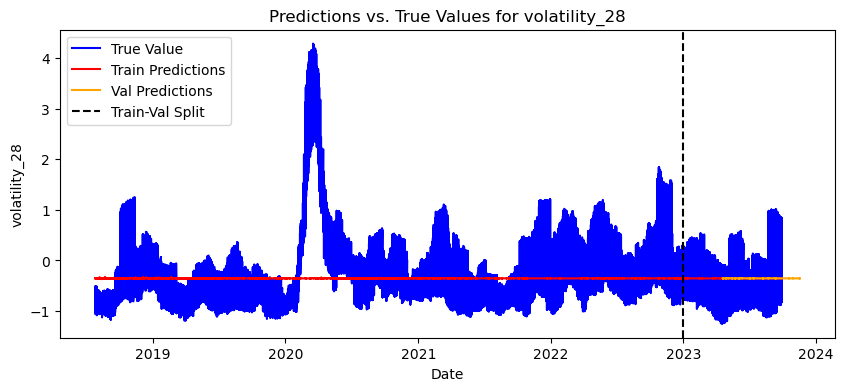

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Separate scaler for target columns
target_scaler = StandardScaler()
standardized_data[train_dataset.target_columns] = target_scaler.fit_transform(standardized_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-01-01'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


#### Weights

In [53]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy()
print(input_embedding_weights)

[[-0.0216997   0.00512788 -0.03709047 ...  0.00594026  0.02496148
   0.00026962]
 [-0.03529334  0.02413681  0.03311764 ... -0.01651831  0.00704556
   0.00347161]
 [-0.0059121  -0.0360367   0.01350481 ... -0.00512817  0.02853123
  -0.0377129 ]
 ...
 [-0.00847946  0.02093974  0.01356767 ... -0.01768232 -0.02345565
  -0.02110821]
 [-0.00142452 -0.02094265  0.01533102 ... -0.02295499 -0.02109216
  -0.00533655]
 [-0.02910789  0.00640309 -0.01495504 ...  0.02426077  0.01922483
  -0.00103944]]


In [54]:
input_embedding_weights.shape

(256, 641)

In [55]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

array([[ 1.0000000e+00, -2.0245682e-02,  4.3168440e-02, ...,
        -8.7689515e-04, -1.7660825e-02,  1.3790629e-02],
       [-2.0245682e-02,  1.0000001e+00,  5.0939120e-02, ...,
         6.9075331e-02,  3.2174043e-02, -2.8283633e-03],
       [ 4.3168440e-02,  5.0939120e-02,  1.0000002e+00, ...,
         2.0202477e-02, -7.4450813e-02,  5.9919782e-02],
       ...,
       [-8.7689515e-04,  6.9075331e-02,  2.0202477e-02, ...,
         1.0000001e+00,  1.9573919e-02, -7.1334243e-03],
       [-1.7660825e-02,  3.2174043e-02, -7.4450813e-02, ...,
         1.9573919e-02,  1.0000002e+00, -3.8425103e-02],
       [ 1.3790629e-02, -2.8283633e-03,  5.9919782e-02, ...,
        -7.1334243e-03, -3.8425103e-02,  1.0000002e+00]], dtype=float32)

In [56]:
# To get the weights of the first encoder layer
encoder_layer_weights = model.transformer.layers[0].state_dict()
encoder_layer_weights

OrderedDict([('self_attn.in_proj_weight',
              tensor([[ 0.0596,  0.0745,  0.0038,  ..., -0.0240, -0.0489, -0.0612],
                      [ 0.0122, -0.0096,  0.0310,  ...,  0.0314, -0.0661, -0.0049],
                      [ 0.0399,  0.0761, -0.0164,  ...,  0.0527,  0.0281, -0.0503],
                      ...,
                      [ 0.0756,  0.0369, -0.0265,  ...,  0.0676, -0.0438, -0.0028],
                      [ 0.0017,  0.0058,  0.0042,  ..., -0.0658, -0.0379,  0.0327],
                      [-0.0217, -0.0315,  0.0637,  ..., -0.0164,  0.0021,  0.0359]],
                     device='cuda:0')),
             ('self_attn.in_proj_bias',
              tensor([-2.4816e-04,  3.5727e-05,  1.7839e-04,  2.0019e-05, -2.3108e-04,
                       7.5881e-05, -8.6064e-05,  9.3432e-05,  6.2791e-05, -4.2283e-05,
                      -1.8141e-04, -2.3000e-04, -8.7847e-05,  1.3853e-04,  1.1700e-04,
                      -1.5833e-04, -3.2914e-05,  4.4143e-05, -5.0283e-05, -1.3699e-04

In [57]:
# If you want to get the weights of all encoder layers
all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
all_encoder_layers_weights

[OrderedDict([('self_attn.in_proj_weight',
               tensor([[ 0.0596,  0.0745,  0.0038,  ..., -0.0240, -0.0489, -0.0612],
                       [ 0.0122, -0.0096,  0.0310,  ...,  0.0314, -0.0661, -0.0049],
                       [ 0.0399,  0.0761, -0.0164,  ...,  0.0527,  0.0281, -0.0503],
                       ...,
                       [ 0.0756,  0.0369, -0.0265,  ...,  0.0676, -0.0438, -0.0028],
                       [ 0.0017,  0.0058,  0.0042,  ..., -0.0658, -0.0379,  0.0327],
                       [-0.0217, -0.0315,  0.0637,  ..., -0.0164,  0.0021,  0.0359]],
                      device='cuda:0')),
              ('self_attn.in_proj_bias',
               tensor([-2.4816e-04,  3.5727e-05,  1.7839e-04,  2.0019e-05, -2.3108e-04,
                        7.5881e-05, -8.6064e-05,  9.3432e-05,  6.2791e-05, -4.2283e-05,
                       -1.8141e-04, -2.3000e-04, -8.7847e-05,  1.3853e-04,  1.1700e-04,
                       -1.5833e-04, -3.2914e-05,  4.4143e-05, -5.0283e-0

In [58]:
# Attention weights
attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# Feedforward weights
feedforward_weights = encoder_layer_weights['linear1.weight']

print("Attention Weights:", attention_weights.shape)
print("Feedforward Weights:", feedforward_weights.shape)


Attention Weights: torch.Size([768, 256])
Feedforward Weights: torch.Size([1024, 256])


In [59]:
# Initialize an empty tensor to accumulate the embeddings
accumulated_embeddings = torch.zeros(9, 256).to(device)
total_batches = 0

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        #print(embeddings)
        accumulated_embeddings += embeddings.sum(dim=1)
        # total_batches += batch["features"].size(0)
        total_batches += embeddings.size(1)

# Divide the accumulated embeddings by the total number of batches to get the average
average_embeddings = accumulated_embeddings / total_batches
print(total_batches)
average_embeddings

1318


tensor([[ 0.1993, -0.7125,  0.4836,  ...,  1.1801,  1.4830, -0.7697],
        [ 0.1992, -0.7126,  0.4836,  ...,  1.1801,  1.4829, -0.7698],
        [ 0.1995, -0.7122,  0.4834,  ...,  1.1802,  1.4831, -0.7695],
        ...,
        [ 0.1993, -0.7123,  0.4834,  ...,  1.1801,  1.4830, -0.7693],
        [ 0.1991, -0.7125,  0.4833,  ...,  1.1801,  1.4830, -0.7697],
        [ 0.1994, -0.7125,  0.4835,  ...,  1.1801,  1.4831, -0.7695]],
       device='cuda:0')

In [60]:
accumulated_embeddings.shape

torch.Size([9, 256])

In [61]:
batch["features"].shape

torch.Size([6, 9, 641])

In [62]:
batch["features"].size(0)

6

#### Stock Embedding

In [53]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

KeyError: 'permno_id'

In [54]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 7.15 μs


In [55]:
list(stock_embeddings.items())[:2]

[]

#### Cosine Similarity Matrix

In [56]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Cases: Return as token

In [27]:
cleaned_data.head()

date permno_id  log_return  abs_log_return  \
0 2018-01-02     10104   -0.013843        0.013843   
1 2018-01-03     10104    0.022897        0.022897   
2 2018-01-04     10104    0.009803        0.009803   
3 2018-01-05     10104    0.006001        0.006001   
4 2018-01-08     10104    0.010467        0.010467   

   sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                        0.000000                      0.000000   
1                        0.006404                      0.004872   
2                        0.004048                      0.000960   
3                        0.009581                      0.006722   
4                        0.002142                      0.005354   

   weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                 0.000000               0.000000      0.309424   
1                 0.005904               0.007983      0.234088   
2                 0.004021               0.000852      0.183199   
3                 0.006193               0.002919      0.230474   
4                 0.001829               0.005828      0.161223   

   abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0          0.309424       0.131071           0.131071       0.011619   
1          0.234088       0.107382           0.107382       0.006475   
2          0.183199       0.097613           0.097613       0.009651   
3          0.230474       0.120486           0.120486       0.015437   
4          0.161223       0.083731           0.083731       0.012476   

   abs_log_return_28  volatility_7  volatility_14  volatility_28  
0           0.011619      0.136136       0.109282       0.276310  
1           0.006475      0.091648       0.081082       0.268724  
2           0.009651      0.089939       0.079524       0.273385  
3           0.015437      0.105015       0.107098       0.281463  
4           0.012476      0.105560       0.139328       0.280139

In [28]:
cleaned_data["log_return"].quantile(np.linspace(0, 1, 101))

0.00   -0.773592
0.01   -0.065884
0.02   -0.050419
0.03   -0.042612
0.04   -0.037526
0.05   -0.033792
0.06   -0.030868
0.07   -0.028434
0.08   -0.026367
0.09   -0.024572
0.10   -0.022949
0.11   -0.021540
0.12   -0.020250
0.13   -0.019085
0.14   -0.018003
0.15   -0.016997
0.16   -0.016083
0.17   -0.015211
0.18   -0.014379
0.19   -0.013601
0.20   -0.012878
0.21   -0.012190
0.22   -0.011532
0.23   -0.010916
0.24   -0.010309
0.25   -0.009735
0.26   -0.009186
0.27   -0.008638
0.28   -0.008121
0.29   -0.007630
0.30   -0.007148
0.31   -0.006671
0.32   -0.006209
0.33   -0.005754
0.34   -0.005318
0.35   -0.004898
0.36   -0.004481
0.37   -0.004061
0.38   -0.003658
0.39   -0.003252
0.40   -0.002860
0.41   -0.002484
0.42   -0.002110
0.43   -0.001740
0.44   -0.001364
0.45   -0.001004
0.46   -0.000640
0.47   -0.000280
0.48    0.000000
0.49    0.000416
0.50    0.000771
0.51    0.001128
0.52    0.001496
0.53    0.001851
0.54    0.002216
0.55    0.002584
0.56    0.002942
0.57    0.003306
0.58    0.0036

In [29]:
cleaned_data["log_return_bin"] = pd.cut(cleaned_data["log_return"], bins = 1000, right = True, include_lowest = True, labels = False)

In [30]:
cleaned_data

date permno_id  log_return  abs_log_return  \
0      2018-01-02     10104   -0.013843        0.013843   
1      2018-01-03     10104    0.022897        0.022897   
2      2018-01-04     10104    0.009803        0.009803   
3      2018-01-05     10104    0.006001        0.006001   
4      2018-01-08     10104    0.010467        0.010467   
...           ...       ...         ...             ...   
794366 2023-11-13     93436    0.041342        0.041342   
794367 2023-11-14     93436    0.059438        0.059438   
794368 2023-11-15     93436    0.022614        0.022614   
794369 2023-11-16     93436   -0.038835        0.038835   
794370 2023-11-17     93436    0.003035        0.003035   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                             0.000000                      0.000000   
1                             0.006404                      0.004872   
2                             0.004048                      0.000960   
3                             0.009581                      0.006722   
4                             0.002142                      0.005354   
...                                ...                           ...   
794366                        0.000410                      0.000916   
794367                        0.025191                      0.037168   
794368                        0.004464                      0.003711   
794369                       -0.000869                     -0.004937   
794370                        0.002385                      0.003949   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                      0.000000               0.000000      0.309424   
1                      0.005904               0.007983      0.234088   
2                      0.004021               0.000852      0.183199   
3                      0.006193               0.002919      0.230474   
4                      0.001829               0.005828      0.161223   
...                         ...                    ...           ...   
794366                -0.000400              -0.000701      0.266036   
794367                 0.022485               0.018177     -0.041740   
794368                 0.001887               0.006906     -0.135146   
794369                -0.001334               0.004114      0.324775   
794370                 0.003156              -0.000656      0.235617   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0               0.309424       0.131071           0.131071       0.011619   
1               0.234088       0.107382           0.107382       0.006475   
2               0.183199       0.097613           0.097613       0.009651   
3               0.230474       0.120486           0.120486       0.015437   
4               0.161223       0.083731           0.083731       0.012476   
...                  ...            ...                ...            ...   
794366          0.266036       0.068729           0.068729       0.039733   
794367          0.041740       0.007099           0.007099       0.025312   
794368          0.135146      -0.018335           0.018335       0.024006   
794369          0.324775       0.050085           0.050085       0.026224   
794370          0.235617       0.052651           0.052651       0.019067   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  \
0                0.011619      0.136136       0.109282       0.276310   
1                0.006475      0.091648       0.081082       0.268724   
2                0.009651      0.089939       0.079524       0.273385   
3                0.015437      0.105015       0.107098       0.281463   
4                0.012476      0.105560       0.139328       0.280139   
...                   ...           ...            ...            ...   
794366           0.039733      0.530805       0.426937       0.378195   
794367           0.025312      0.383085       0.347634       0.33

In [31]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [32]:
subsample = cleaned_data[["date", "permno_id", "log_return", "log_return_bin"]].copy()

In [33]:
subsample

date permno_id  log_return  log_return_bin
0      2018-01-02     10104   -0.013843             541
1      2018-01-03     10104    0.022897             567
2      2018-01-04     10104    0.009803             558
3      2018-01-05     10104    0.006001             555
4      2018-01-08     10104    0.010467             558
...           ...       ...         ...             ...
794366 2023-11-13     93436    0.041342             580
794367 2023-11-14     93436    0.059438             593
794368 2023-11-15     93436    0.022614             567
794369 2023-11-16     93436   -0.038835             523
794370 2023-11-17     93436    0.003035             553

[794371 rows x 4 columns]

In [34]:
subsample.groupby("log_return_bin").agg({"log_return": ["min", "max"]})

log_return          
                      min       max
log_return_bin                     
0               -0.773592 -0.773592
14              -0.753054 -0.753054
22              -0.741483 -0.741483
50              -0.702874 -0.702874
100             -0.632092 -0.632092
104             -0.626294 -0.626294
116             -0.610210 -0.610210
129             -0.591418 -0.591418
160             -0.548611 -0.548611
167             -0.538428 -0.538428
187             -0.510826 -0.510826
203             -0.488192 -0.488192
204             -0.485910 -0.485910
210             -0.478663 -0.478663
212             -0.475827 -0.475827
213             -0.474097 -0.474097
214             -0.472302 -0.472302
216             -0.470141 -0.470084
217             -0.468911 -0.468360
222             -0.460762 -0.460762
235             -0.443091 -0.443091
240             -0.436142 -0.436142
241             -0.435154 -0.435154
242             -0.432578 -0.432578
244             -0.430994 -0.430994
250             -0.421544 -0.421544
258             -0.410950 -0.410505
259             -0.409684 -0.409684
264             -0.402044 -0.402044
272             -0.391117 -0.390705
276             -0.385768 -0.385768
278             -0.382406 -0.382406
290             -0.366379 -0.366379
291             -0.364644 -0.364602
294             -0.360829 -0.360682
300             -0.352441 -0.351450
301             -0.350281 -0.350281
304             -0.346415 -0.345742
306             -0.343234 -0.343234
310             -0.337382 -0.337382
311             -0.336773 -0.336773
312             -0.335171 -0.335171
313             -0.333419 -0.333419
315             -0.330821 -0.330821
316             -0.329175 -0.329175
318             -0.327086 -0.327086
319             -0.324754 -0.324754
320             -0.323868 -0.323868
322             -0.321691 -0.320500
323             -0.320015 -0.318962
325             -0.316197 -0.316197
326             -0.315950 -0.314833
327             -0.314545 -0.313347
328             -0.312519 -0.312458
329             -0.311673 -0.310783
330             -0.310376 -0.309970
332             -0.306449 -0.306391
336             -0.301452 -0.300816
339             -0.297731 -0.297394
341             -0.294720 -0.294250
342             -0.292910 -0.292250
343             -0.291966 -0.291424
344             -0.290828 -0.290681
345             -0.288562 -0.288562
346             -0.286756 -0.286753
347             -0.286597 -0.285552
348             -0.284612 -0.284365
349             -0.283201 -0.282977
350             -0.282374 -0.281444
351             -0.280301 -0.279654
352             -0.279301 -0.279301
353             -0.278100 -0.277526
354             -0.275761 -0.275761
355             -0.274437 -0.274437
356             -0.273545 -0.272783
357             -0.272550 -0.272099
358             -0.271058 -0.270104
359             -0.268520 -0.268406
360             -0.267725 -0.267725
362             -0.264655 -0.264655
363             -0.263680 -0.263680
364             -0.262575 -0.261949
365             -0.260489 -0.260009
366             -0.259898 -0.259216
368             -0.257132 -0.255876
369             -0.255310 -0.254509
370             -0.253738 -0.253699
371             -0.252780 -0.251763
372             -0.251029 -0.251029
373             -0.250063 -0.249648
374             -0.248256 -0.248127
375             -0.246195 -0.246195
376             -0.245785 -0.244555
377             -0.244082 -0.243714
378             -0.242377 -0.242377
379             -0.241675 -0.240407
380             -0.239400 -0.239400
381             -0.238751 -0.237619
382             -0.237406 -0.236283
383             -0.235722 -0.235702
384             -0.234522 -0.233352
385             -0.233199 -0.232467
386             -0.231875 -0.231085
387             -0.230433 -0.229758
388             -0.228719 -0.228150
389             -0.227624 -0.226653
390             -0.226010 -0.225699
391             -0.224568 -0.223804
392             -0.

In [35]:
subsample["log_return_bin"].isnull().any()

False

In [36]:
subsample

date permno_id  log_return  log_return_bin
0      2018-01-02     10104   -0.013843             541
1      2018-01-03     10104    0.022897             567
2      2018-01-04     10104    0.009803             558
3      2018-01-05     10104    0.006001             555
4      2018-01-08     10104    0.010467             558
...           ...       ...         ...             ...
794366 2023-11-13     93436    0.041342             580
794367 2023-11-14     93436    0.059438             593
794368 2023-11-15     93436    0.022614             567
794369 2023-11-16     93436   -0.038835             523
794370 2023-11-17     93436    0.003035             553

[794371 rows x 4 columns]

In [37]:
n_stocks = 20  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(subsample, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

In [38]:
train_data.head()

date permno_id  log_return  log_return_bin
0 2018-01-02     10104   -0.013843             541
1 2018-01-03     10104    0.022897             567
2 2018-01-04     10104    0.009803             558
3 2018-01-05     10104    0.006001             555
4 2018-01-08     10104    0.010467             558

In [39]:
check_data(train_data)

In [40]:
validation_data.head()

date permno_id  log_return  log_return_bin
0 2023-03-29     10104    0.008533             557
1 2023-03-30     10104   -0.001215             550
2 2023-03-31     10104    0.026279             569
3 2023-04-03     10104    0.010705             558
4 2023-04-04     10104    0.000852             551

In [41]:
check_data(validation_data)

In [42]:
validation_data.dtypes

date              datetime64[ns]
permno_id                 object
log_return               float64
log_return_bin             int64
dtype: object

In [43]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return_bin",
            # "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return_bin",
            # "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            # j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    # X = np.append(X, j)
                    # j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.long),
            "target": torch.tensor(y, dtype=torch.long),
            "permno_id": permno_id,
        }

In [44]:
train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [45]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[541, 567, 558,  ..., 565, 547, 562],
        [567, 558, 555,  ..., 547, 562, 560],
        [558, 555, 558,  ..., 562, 560, 562],
        ...,
        [556, 565, 568,  ..., 546, 554, 545],
        [565, 568, 552,  ..., 554, 545, 555],
        [568, 552, 539,  ..., 545, 555, 555]]), 'target': tensor([[560],
        [562],
        [555],
        [561],
        [558],
        [558],
        [551],
        [557],
        [547],
        [548],
        [552],
        [553],
        [551],
        [555],
        [550],
        [547],
        [537],
        [550],
        [546],
        [559],
        [559],
        [554],
        [548],
        [549],
        [553],
        [547],
        [546],
        [554],
        [545],
        [555],
        [555],
        [552]]), 'permno_id': ['10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '10104', '

In [46]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
        num_embeddings=1000,
        embedding_dim = 256
        
    ):
        super(TransformerModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim)
        #self.input_embedding = nn.Linear(input_dim + embedding_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding_layer(x)
        #print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        output_embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(output_embedding)
        x = self.fc(x)
        return x, output_embedding

In [48]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = 128*len(train_dataset.input_columns)
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
    num_embeddings=1000,
    embedding_dim = 256
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...


RuntimeError: Expected floating point type for target with class probabilities, got Long

### Cases: Model-10 stocks (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [65]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [66]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

#### Train 10 Stocks

In [67]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 12823
Validation Dataset Length: 315
{'features': tensor([[-5.9591e-01, -1.6427e-02, -5.4259e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.5229e-01,  3.2767e-01,  3.0401e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 4.0051e-01,  2.0108e-01,  5.5546e-02,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 8.3016e-01,  4.5791e-01,  5.1627e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-2.2874e-01, -3.2463e-01, -9.2820e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 6.3263e-01,  6.2743e-01,  8.0614e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([ 0.5314, -0.1326,  0.6923,  0.4000,  0.6881,  0.1316,  0.2728, -0.4808,
        -0.9690, -0.9886, -0.9906]), 'permno_id': '10104'}
CPU times: user 13.8 s, sys: 0 ns, total: 13.8 s
Wall time: 13.8 s


#### 1-Origninal Model

#### Build and Train Model

In [68]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        print(x.shape)
        x = self.input_embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        output_embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(output_embedding)
        x = self.fc(x)
        return x, output_embedding

Starting Training...
torch.Size([32, 128, 560])
Batch 0/401, Loss: 0.5504, Estimated time left for epoch: 00:01:06, Estimated time left for training: 00:03:21
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
Batch 20/401, Loss: 0.4874, Estimated time left for epoch: 00:00:28, Estimated time left for training: 00:01:28
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])
torch.Size([32, 128, 560])


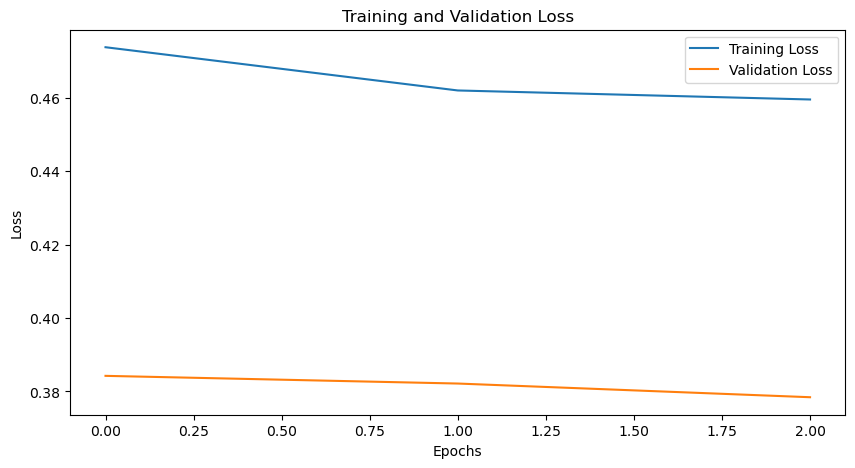

CPU times: user 5min 26s, sys: 12 s, total: 5min 38s
Wall time: 1min 24s


In [69]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 3
patience = 1
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [79]:
with torch.no_grad():
    for batch in train_dataloader:
        output, _ = model(batch["features"].to(device))
        print(output)

tensor([[ 0.0113,  0.0018,  0.0251,  0.1009,  0.0011,  0.0350, -0.0013,  0.0347,
          0.1553,  0.1602,  0.1602],
        [ 0.0112,  0.0018,  0.0250,  0.1010,  0.0011,  0.0350, -0.0012,  0.0348,
          0.1554,  0.1602,  0.1602],
        [ 0.0112,  0.0018,  0.0250,  0.1011,  0.0012,  0.0351, -0.0012,  0.0349,
          0.1555,  0.1603,  0.1603],
        [ 0.0111,  0.0019,  0.0249,  0.1011,  0.0013,  0.0351, -0.0011,  0.0350,
          0.1556,  0.1603,  0.1603],
        [ 0.0111,  0.0019,  0.0249,  0.1012,  0.0013,  0.0351, -0.0011,  0.0351,
          0.1557,  0.1603,  0.1604],
        [ 0.0110,  0.0020,  0.0249,  0.1012,  0.0014,  0.0351, -0.0010,  0.0352,
          0.1558,  0.1604,  0.1604],
        [ 0.0110,  0.0020,  0.0248,  0.1013,  0.0015,  0.0352, -0.0010,  0.0352,
          0.1559,  0.1604,  0.1604],
        [ 0.0110,  0.0020,  0.0248,  0.1013,  0.0015,  0.0352, -0.0010,  0.0353,
          0.1559,  0.1604,  0.1605],
        [ 0.0110,  0.0020,  0.0248,  0.1014,  0.0016,  0

#### Stock Embedding

In [80]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 35.4 s, sys: 1.08 s, total: 36.5 s
Wall time: 9.13 s


In [81]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 25.5 ms


In [82]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.27110893,  0.7256028 , -0.38371122, -2.409388  ,  0.22077565,
          0.9042875 , -1.5059302 , -0.06040866, -0.32615772, -0.00913703,
         -0.5051489 ,  0.11004172,  0.14654294,  0.05432602, -2.6403003 ,
          1.2754791 ,  0.45839894,  2.278051  , -0.64648825, -0.17278251,
         -1.1314304 ,  0.27877954, -0.8838449 ,  1.7975663 ,  0.28122288,
          0.25066662, -3.0573285 ,  0.269187  , -0.53541285, -1.2090453 ,
         -0.28892353,  0.975972  ,  1.2332641 ,  2.2376862 , -0.9076812 ,
         -0.7476636 , -1.1733629 , -0.22034992, -1.4095951 ,  1.1948919 ,
         -0.05268206, -0.26139966,  0.5495843 , -0.06332184, -0.6636511 ,
          1.4036739 , -0.10962486,  0.8397205 ,  0.00682272,  0.51089936,
          0.2807606 ,  0.50952613, -0.07539078, -0.22727005,  0.4548959 ,
          0.63640636, -0.27442127,  1.187367  ,  0.821824  , -0.28405726,
         -0.27777869, -0.43231577, -0.92474765,  0.20353372, -0.05068565,
          0.34961966,  0.05

#### Cosine Similarity Matrix

In [83]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 3.95 ms, sys: 3.55 ms, total: 7.5 ms
Wall time: 1.7 ms


array([[1.        , 0.99999976, 0.99999946, 0.99999946, 0.9999995 ,
        0.99999934, 0.99999696, 0.999999  , 0.99999934, 0.9999994 ],
       [0.99999976, 0.9999998 , 0.99999917, 1.        , 0.9999992 ,
        0.9999999 , 0.99999696, 0.9999987 , 0.99999917, 0.99999875],
       [0.99999946, 0.99999917, 1.0000001 , 0.99999964, 0.99999994,
        0.99999964, 0.99999696, 0.99999946, 0.99999994, 0.99999964],
       [0.99999946, 1.        , 0.99999964, 1.0000004 , 1.        ,
        0.99999964, 0.99999714, 0.9999993 , 0.9999998 , 0.9999995 ],
       [0.9999995 , 0.9999992 , 0.99999994, 1.        , 1.        ,
        0.99999946, 0.99999666, 0.9999995 , 0.9999993 , 0.9999996 ],
       [0.99999934, 0.9999999 , 0.99999964, 0.99999964, 0.99999946,
        1.        , 0.99999654, 0.9999995 , 0.9999995 , 0.9999995 ],
       [0.99999696, 0.99999696, 0.99999696, 0.99999714, 0.99999666,
        0.99999654, 1.        , 0.9999961 , 0.99999654, 0.9999963 ],
       [0.999999  , 0.9999987 , 0.9999994

#### 2-extract input_embedding

#### Build and Train Model

In [29]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        input_embedding = self.input_embedding(x)
        x = input_embedding.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        output_embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(output_embedding)
        x = self.fc(x)
        return x, input_embedding

Starting Training...
Batch 0/401, Loss: 0.1362, Estimated time left for epoch: 00:02:57, Estimated time left for training: 00:14:52
Batch 100/401, Loss: 0.1175, Estimated time left for epoch: 00:00:20, Estimated time left for training: 00:02:08
Batch 200/401, Loss: 0.0640, Estimated time left for epoch: 00:00:13, Estimated time left for training: 00:01:58
Batch 300/401, Loss: 0.0472, Estimated time left for epoch: 00:00:06, Estimated time left for training: 00:01:51
Batch 400/401, Loss: 0.0681, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:01:43
Epoch 1/5 took 26.12 seconds
Epoch 1/5, Training Loss: 0.09392024955696002, Validation Loss: 0.055514486692845824
Batch 0/401, Loss: 0.0498, Estimated time left for epoch: 00:00:26, Estimated time left for training: 00:01:44
Batch 100/401, Loss: 0.1036, Estimated time left for epoch: 00:00:19, Estimated time left for training: 00:01:37
Batch 200/401, Loss: 0.0619, Estimated time left for epoch: 00:00:12, Estimate

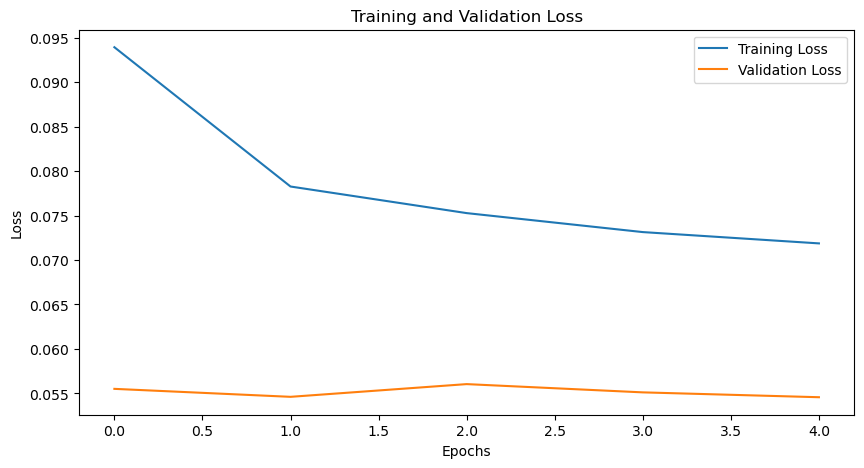

CPU times: user 2min 27s, sys: 595 ms, total: 2min 27s
Wall time: 2min 11s


In [30]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [41]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, input_embeddings = model(batch["features"].to(device))
        avg_input_embeddings = input_embeddings.mean(dim=1)  # Averaging over the sequence dimension
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(avg_input_embeddings[i].cpu().numpy())



CPU times: user 11.5 s, sys: 58.4 ms, total: 11.6 s
Wall time: 8.23 s


In [42]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 21.1 ms, sys: 0 ns, total: 21.1 ms
Wall time: 20.3 ms


In [43]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-18.314182  ,  17.158415  , -27.199263  ,  10.041617  ,
          13.1245    ,  16.603168  ,  -4.0235214 ,   5.8678617 ,
          -3.8106928 , -22.051804  , -29.890255  , -20.768213  ,
          10.749864  ,  16.422583  ,  -4.278962  ,   1.9518749 ,
          -5.1408353 ,  21.116577  , -21.76019   , -13.9373455 ,
         -30.268429  , -21.71142   ,  17.04273   , -17.778101  ,
          13.181569  , -21.500448  ,  -9.061482  , -17.156616  ,
          29.943502  , -28.99633   ,  13.572565  ,  21.78564   ,
          19.83186   ,  -5.0112576 ,  24.040026  ,  15.407558  ,
           2.6649024 , -19.013443  ,  29.18712   ,  -2.061519  ,
          -3.2744942 , -26.231396  ,  -3.1111698 , -13.455179  ,
          25.96364   ,  -7.28782   ,  12.253685  , -22.264605  ,
         -10.44368   ,  11.710325  ,  23.411627  , -14.190325  ,
           9.43104   ,  23.546932  , -17.637188  ,  29.38976   ,
          -2.5814953 ,   5.8495874 ,   3.1584969 ,  27.995844  ,
          27.2

#### Cosine Similarity Matrix

In [44]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Flatten the embeddings_array if necessary
if embeddings_array.ndim == 3:
    embeddings_array = embeddings_array.reshape(embeddings_array.shape[0], -1)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.83 ms, sys: 96 μs, total: 1.92 ms
Wall time: 1.43 ms


array([[0.9999998 , 0.9999981 , 0.99999815, 0.99999815, 0.9999981 ,
        0.99999785, 0.9999969 , 0.9999978 , 0.99999857, 0.9999981 ],
       [0.9999981 , 0.99999976, 0.99999774, 0.99999803, 0.99999845,
        0.9999979 , 0.99999774, 0.999998  , 0.99999815, 0.9999981 ],
       [0.99999815, 0.99999774, 1.0000004 , 0.99999857, 0.9999984 ,
        0.9999983 , 0.99999756, 0.99999815, 0.9999982 , 0.99999803],
       [0.99999815, 0.99999803, 0.99999857, 0.99999994, 0.99999833,
        0.99999845, 0.99999714, 0.9999984 , 0.9999981 , 0.9999981 ],
       [0.9999981 , 0.99999845, 0.9999984 , 0.99999833, 1.0000002 ,
        0.9999982 , 0.99999756, 0.9999982 , 0.9999984 , 0.99999845],
       [0.99999785, 0.9999979 , 0.9999983 , 0.99999845, 0.9999982 ,
        1.0000002 , 0.99999684, 0.99999815, 0.99999803, 0.9999982 ],
       [0.9999969 , 0.99999774, 0.99999756, 0.99999714, 0.99999756,
        0.99999684, 1.0000002 , 0.9999979 , 0.99999756, 0.99999756],
       [0.9999978 , 0.999998  , 0.9999981

#### 3-use student_t as the head 
https://huggingface.co/blog/time-series-transformers

#### Build and Train Model

In [63]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
        degrees_of_freedom=3  # Adding degrees_of_freedom parameter for Student-t distribution
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

        # Parameters for Student-t distribution
        self.mu = nn.Linear(hidden_dims[1], output_dim)
        self.sigma = nn.Linear(hidden_dims[1], output_dim)
        self.nu = nn.Parameter(torch.ones(output_dim) * degrees_of_freedom)
        
    def forward(self, x):
        x = self.input_embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        output_embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(output_embedding)
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))  # Ensure positive values for sigma
        nu = torch.exp(self.nu)  # Ensure positive values for degrees of freedom

        # Create a Student-t distribution
        t_dist = dist.StudentT(df=nu, loc=mu, scale=sigma)
        return t_dist, output_embedding
        # x = self.fc(x)
        # return x, output_embedding

Starting Training...
Batch 0/401, Loss: 0.9470, Estimated time left for epoch: 14:46:30, Estimated time left for training: 12:39:44
Batch 100/401, Loss: 0.6005, Estimated time left for epoch: 00:28:17, Estimated time left for training: 03:32:21
Batch 200/401, Loss: 0.2381, Estimated time left for epoch: 00:09:34, Estimated time left for training: 01:42:03
Batch 300/401, Loss: 0.1830, Estimated time left for epoch: 00:03:14, Estimated time left for training: 01:04:59
Batch 400/401, Loss: 0.1266, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:46:20
Epoch 1/5 took 26.08 seconds
Epoch 1/5, Training Loss: 0.3846959754292786, Validation Loss: -0.21574895828962326
Batch 0/401, Loss: 0.0673, Estimated time left for epoch: 17:40:05, Estimated time left for training: 00:46:13
Batch 100/401, Loss: 0.0366, Estimated time left for epoch: 00:29:34, Estimated time left for training: 00:35:01
Batch 200/401, Loss: -0.0430, Estimated time left for epoch: 00:10:00, Estimate

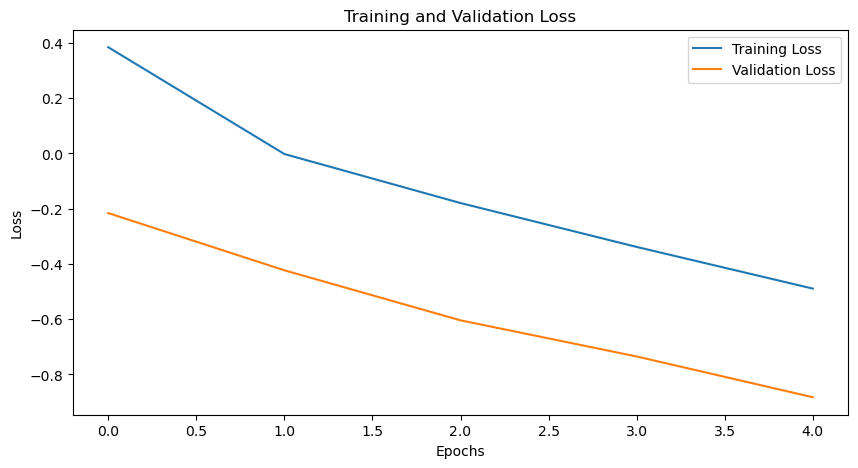

CPU times: user 2min 27s, sys: 339 ms, total: 2min 28s
Wall time: 2min 11s


In [64]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)

def negative_log_likelihood(t_dist, targets):
    return -t_dist.log_prob(targets).mean()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        t_dist, _ = model(batch["features"].to(device))
        loss = negative_log_likelihood(t_dist, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # if i % 10000 == 0:
        #     elapsed_time = time.time() - start_time
        #     estimated_total_time = elapsed_time * len(train_dataloader) / (i + 1)
        #     remaining_time = estimated_total_time - elapsed_time
        #     print(f"Batch {i}, Loss: {loss}, Time Left: {remaining_time:.2f} seconds")

        if i % 100 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")    
    
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            t_dist, _ = model(batch["features"].to(device))
            loss = negative_log_likelihood(t_dist, batch["target"].to(device))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [65]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 11.4 s, sys: 51.8 ms, total: 11.5 s
Wall time: 8.19 s


In [66]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 16.5 ms, sys: 6.09 ms, total: 22.6 ms
Wall time: 21.6 ms


In [67]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-0.5592333 , -0.03486308, -0.37444285,  0.13700178,  0.57205945,
         -0.64714754, -0.2927051 , -1.4680772 ,  1.0708897 , -0.39355326,
         -0.20220128,  0.4968837 ,  0.92391527,  0.25236163,  0.25201207,
         -0.7571035 , -0.11258943,  0.4800228 ,  0.62211996,  0.33748075,
         -0.37104455, -0.7447963 ,  0.02187662, -1.6525916 , -1.4270935 ,
          0.4435756 ,  1.2989073 ,  0.64085186, -1.360808  ,  0.5681368 ,
          0.88329273,  0.9422764 , -1.1319594 , -0.6580686 ,  0.9699672 ,
          0.7773257 , -0.02585188, -0.32658482, -1.7971064 , -1.8149915 ,
         -0.6423918 , -0.9582294 , -0.12584482,  0.09600563, -0.04267287,
          1.2517773 , -2.2831373 ,  0.9456051 , -0.23255591, -0.04539579,
          0.6524812 , -0.19502418, -0.77689284, -0.5539818 ,  0.37731758,
          0.25632706,  1.1283555 ,  1.256406  , -0.6141925 , -1.8812844 ,
         -0.8489429 ,  1.5408773 ,  1.1957258 , -0.6900072 , -0.00876424,
         -0.33721623,  0.34

#### Cosine Similarity Matrix

In [39]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.34 ms, sys: 72 μs, total: 1.42 ms
Wall time: 1.03 ms


array([[1.        , 0.9999998 , 1.0000002 , 0.9999997 , 1.0000001 ,
        0.9999999 , 0.9999968 , 0.9999996 , 0.9999997 , 1.0000001 ],
       [0.9999998 , 1.0000001 , 0.9999999 , 0.9999995 , 0.99999964,
        0.99999964, 0.99999696, 1.        , 0.9999996 , 0.99999976],
       [1.0000002 , 0.9999999 , 0.99999976, 0.99999946, 1.        ,
        0.9999998 , 0.999997  , 0.9999995 , 0.9999997 , 0.99999994],
       [0.9999997 , 0.9999995 , 0.99999946, 0.9999997 , 0.9999995 ,
        1.0000001 , 0.9999971 , 1.        , 1.        , 1.        ],
       [1.0000001 , 0.99999964, 1.        , 0.9999995 , 1.0000001 ,
        0.9999999 , 0.9999975 , 0.9999993 , 1.0000001 , 0.99999994],
       [0.9999999 , 0.99999964, 0.9999998 , 1.0000001 , 0.9999999 ,
        0.9999998 , 0.99999636, 0.99999994, 0.9999997 , 1.        ],
       [0.9999968 , 0.99999696, 0.999997  , 0.9999971 , 0.9999975 ,
        0.99999636, 1.        , 0.9999972 , 0.9999968 , 0.99999684],
       [0.9999996 , 1.        , 0.9999995

### Case 0: Model (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [27]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

#### 1-Train 20 Stocks

In [28]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 20  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 24452
Validation Dataset Length: 595
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 17.3 s, sys: 6.06 s, total: 23.4 s
Wall time: 23.2 s


#### Build and Train Model

In [29]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 23.10 seconds
Epoch 1/5, Training Loss: 0.09412645920624141, Validation Loss: 0.0692453402045526
Epoch 2/5 took 23.07 seconds
Epoch 2/5, Training Loss: 0.08155087288590818, Validation Loss: 0.06744421528358209
Epoch 3/5 took 23.08 seconds
Epoch 3/5, Training Loss: 0.07875799366023416, Validation Loss: 0.06750609117903207
Epoch 4/5 took 23.10 seconds
Epoch 4/5, Training Loss: 0.07706430318698385, Validation Loss: 0.07016528182123836
Epoch 5/5 took 23.08 seconds
Epoch 5/5, Training Loss: 0.07595785261661399, Validation Loss: 0.07225820951555904
Early stopping triggered.
Training Complete


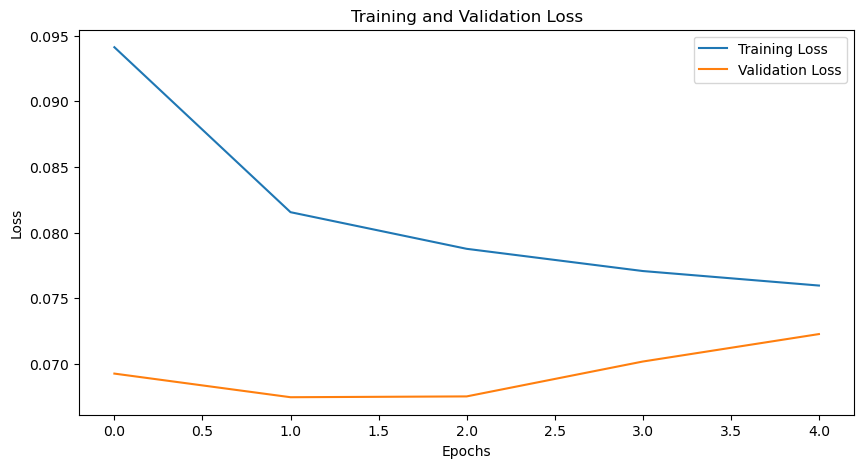

CPU times: user 57min 10s, sys: 4min 33s, total: 1h 1min 44s
Wall time: 1min 55s


In [30]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [31]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 3min 50s, sys: 17.5 s, total: 4min 8s
Wall time: 7.76 s


In [32]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 725 ms, sys: 65.7 ms, total: 791 ms
Wall time: 24.7 ms


In [33]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-0.39119446, -2.227399  ,  0.34304115, -3.5740335 , -0.36883023,
         -1.6955941 ,  0.06953341, -1.6063895 , -0.24464951, -0.36184612,
         -0.19911197, -1.2982944 , -0.32418808,  0.6437285 , -0.03860904,
          0.30091944,  0.10331205, -0.07951745,  0.02619102,  0.12874806,
         -0.42107436,  0.99302995,  0.19409259,  0.16744594, -0.43425408,
          2.4634042 , -0.3757179 , -0.07628959,  0.03638591, -0.51867574,
         -1.3585252 , -0.19920467, -1.4767994 ,  0.5152026 , -1.3402153 ,
          1.7249678 , -0.06119248, -1.1572595 , -0.14729173,  0.22037613,
          0.74250793, -0.85647035, -0.96226126, -0.15748815, -0.44832823,
         -1.6233389 ,  0.2543297 , -1.2462682 , -0.06726051, -0.04138817,
          0.52311915,  1.4625831 , -0.27160734, -0.04229318,  0.41019765,
          0.07532112, -1.4069737 ,  0.4963095 ,  0.18437295,  0.54080474,
          0.08437508, -0.5113699 ,  0.86370695, -0.06676183, -1.4475948 ,
          0.2280875 ,  0.04

#### Cosine Similarity Matrix

In [34]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.57 ms, sys: 131 μs, total: 1.7 ms
Wall time: 1.14 ms


array([[1.        , 1.0000001 , 0.99999964, 1.0000001 , 0.9999997 ,
        0.9999998 , 0.9998064 , 0.99999994, 0.99999976, 1.0000001 ,
        0.99340093, 0.9999998 , 1.0000001 , 1.        , 0.9999999 ,
        1.0000001 , 1.        , 0.99999994, 0.9993236 , 1.0000001 ],
       [1.0000001 , 1.0000005 , 1.0000001 , 1.        , 0.9999997 ,
        1.0000002 , 0.99980956, 0.99999976, 1.0000004 , 0.9999999 ,
        0.9934184 , 1.0000002 , 0.9999998 , 1.0000002 , 1.        ,
        1.        , 1.0000001 , 1.0000001 , 0.9993301 , 1.0000002 ],
       [0.99999964, 1.0000001 , 1.        , 0.9999999 , 0.99999964,
        1.0000004 , 0.99980855, 1.        , 1.        , 0.99999976,
        0.9934125 , 0.99999976, 1.0000002 , 0.99999964, 0.9999997 ,
        0.9999998 , 1.        , 0.9999997 , 0.9993279 , 1.0000002 ],
       [1.0000001 , 1.        , 0.9999999 , 0.9999999 , 1.0000001 ,
        1.        , 0.99980915, 1.0000001 , 0.9999998 , 1.0000004 ,
        0.9934167 , 1.0000001 , 0.9999999 , 1

#### 1-Train 50 Stocks

In [35]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 50  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 63514
Validation Dataset Length: 1610
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 44.8 s, sys: 15.7 s, total: 1min
Wall time: 1min


#### Build and Train Model

In [36]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 60.04 seconds
Epoch 1/5, Training Loss: 0.10369074432840876, Validation Loss: 0.10198753896881552
Epoch 2/5 took 60.00 seconds
Epoch 2/5, Training Loss: 0.09440469959051694, Validation Loss: 0.10458207860881207
Epoch 3/5 took 60.06 seconds
Epoch 3/5, Training Loss: 0.09229132511678811, Validation Loss: 0.10356273341412638
Epoch 4/5 took 60.03 seconds
Epoch 4/5, Training Loss: 0.0914411215472882, Validation Loss: 0.10113472725246467
Epoch 5/5 took 60.03 seconds
Epoch 5/5, Training Loss: 0.0910587625573354, Validation Loss: 0.10305122417562149
Training Complete


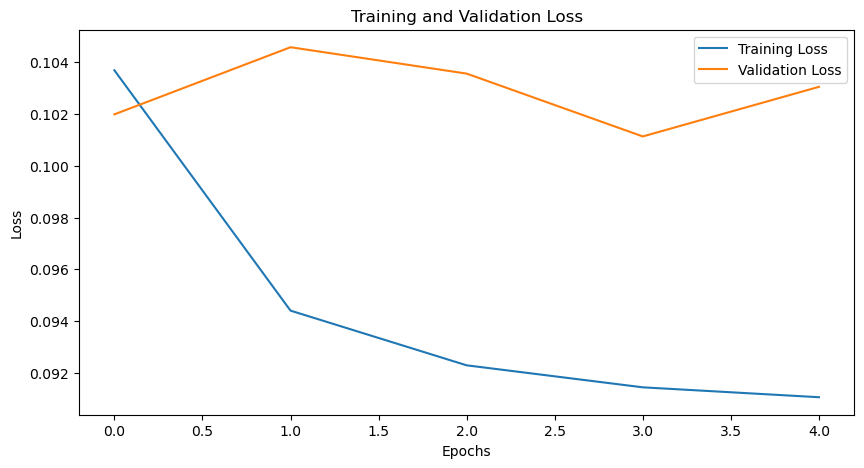

CPU times: user 2h 28min 8s, sys: 12min 2s, total: 2h 40min 11s
Wall time: 5min


In [37]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [38]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 9min 53s, sys: 44.1 s, total: 10min 37s
Wall time: 19.9 s


In [39]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 1.86 s, sys: 153 ms, total: 2.01 s
Wall time: 62.8 ms


In [40]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.00413457e-01, -5.05379796e-01, -1.27062127e-01, -4.57877442e-02,
          1.66650247e-02, -9.90394726e-02,  1.06488392e-01, -2.05044016e-01,
         -9.16311368e-02,  1.22013194e-02, -6.57615289e-02,  3.38098183e-02,
          1.89384050e-03,  3.58042270e-02, -2.16879442e-01,  1.12164348e-01,
          4.85097378e-01, -4.14908469e-01, -3.93605717e-02,  3.03712696e-01,
         -7.18023896e-01, -3.56855690e-02, -7.52446800e-02,  3.33295846e+00,
          3.07719082e-01, -1.06828667e-01,  1.21853685e+00,  1.02218121e-01,
          3.36038694e-02,  3.53538245e-02, -7.24351466e-01,  1.96079528e+00,
         -3.29996869e-02, -5.61606847e-02,  1.65335890e-02, -5.71141863e+00,
         -1.64221928e-01, -2.27759004e-01, -1.35565341e-01,  9.92992520e-02,
         -1.66837618e-01,  1.89789206e-01,  5.52012101e-02,  4.86373901e-02,
         -2.31540367e-01, -1.24230015e+00,  1.14614904e-01,  4.06468771e-02,
          6.67809486e-01,  1.27735722e+00,  2.07718849e+00, -7.09

#### Cosine Similarity Matrix

In [41]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 29.5 ms, sys: 2.43 ms, total: 32 ms
Wall time: 989 μs


array([[1.0000002 , 0.9999999 , 0.99999994, ..., 1.0000001 , 0.9999999 ,
        1.        ],
       [0.9999999 , 0.9999997 , 0.9999995 , ..., 0.99999976, 0.99999976,
        0.99999964],
       [0.99999994, 0.9999995 , 0.9999997 , ..., 0.9999997 , 0.9999997 ,
        0.9999998 ],
       ...,
       [1.0000001 , 0.99999976, 0.9999997 , ..., 0.99999994, 0.99999976,
        1.        ],
       [0.9999999 , 0.99999976, 0.9999997 , ..., 0.99999976, 0.9999999 ,
        0.99999976],
       [1.        , 0.99999964, 0.9999998 , ..., 1.        , 0.99999976,
        0.99999964]], dtype=float32)

#### 2-Train 10 Stocks

In [42]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 12823
Validation Dataset Length: 315
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 12.4 s, sys: 332 ms, total: 12.7 s
Wall time: 9.52 s


#### Build and Train Model

In [43]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 12.11 seconds
Epoch 1/5, Training Loss: 0.1026492339194267, Validation Loss: 0.058561856672167775
Epoch 2/5 took 12.13 seconds
Epoch 2/5, Training Loss: 0.08084431377952533, Validation Loss: 0.05564693119376898
Epoch 3/5 took 12.14 seconds
Epoch 3/5, Training Loss: 0.07667415407010147, Validation Loss: 0.05553480349481106
Epoch 4/5 took 12.14 seconds
Epoch 4/5, Training Loss: 0.07431373773537521, Validation Loss: 0.05529005378484726
Epoch 5/5 took 12.15 seconds
Epoch 5/5, Training Loss: 0.0723943929571166, Validation Loss: 0.05627334155142307
Training Complete


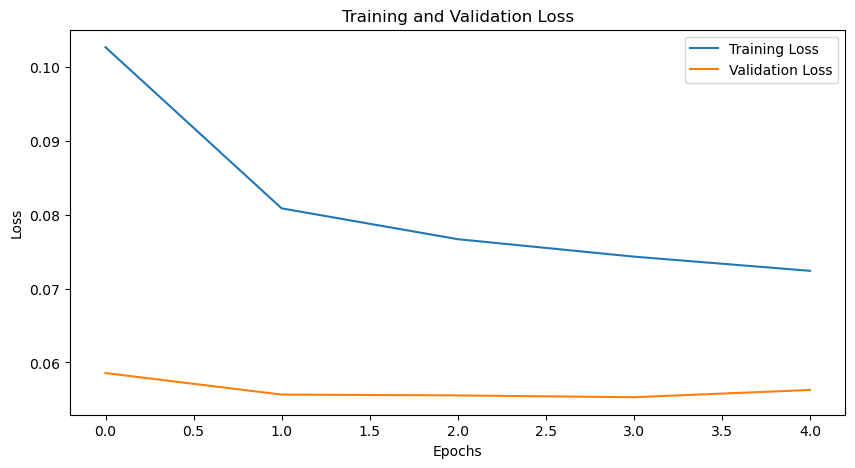

CPU times: user 30min 3s, sys: 2min 24s, total: 32min 27s
Wall time: 1min


In [44]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [45]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 2min 1s, sys: 8.94 s, total: 2min 10s
Wall time: 4.07 s


In [46]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 407 ms, sys: 40.8 ms, total: 448 ms
Wall time: 14 ms


In [47]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.03221929e+00,  1.20662332e+00, -1.09189653e+00, -7.12606132e-01,
          4.51121897e-01, -6.41267419e-01, -5.53138852e-02,  8.93993437e-01,
         -2.66366959e-01, -1.50912595e+00, -1.29489064e-01,  7.94644654e-01,
         -2.02970445e-01, -3.10800850e-01, -2.88446736e+00, -4.61960465e-01,
          2.53840089e-01, -1.23142377e-02, -2.16725487e-02, -1.58095896e+00,
         -8.84728692e-03, -6.86774015e-01, -1.01480214e-03, -5.14901638e-01,
         -5.31252801e-01,  4.59038407e-01,  2.93676287e-01, -1.31282699e+00,
          5.36417007e-01,  1.40688193e+00,  3.52334499e-01,  2.88778877e+00,
          1.16396964e+00,  7.86729574e-01, -1.57985902e+00, -7.91675270e-01,
         -8.07862341e-01,  4.69271958e-01,  1.50240660e+00,  3.20762396e-01,
          1.32289365e-01, -6.77132666e-01,  4.16485995e-01, -2.65848488e-02,
          3.04843426e-01,  3.73898327e-01, -5.01600742e-01,  1.56065059e+00,
          7.50822067e-01,  6.24703169e-01, -2.29852013e-02,  1.46

#### Cosine Similarity Matrix

In [48]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 18.1 ms, sys: 8.29 ms, total: 26.4 ms
Wall time: 832 μs


array([[1.0000002 , 0.99999934, 0.99999994, 0.99999994, 0.9999998 ,
        1.        , 0.9999976 , 0.9999997 , 0.9999997 , 0.9999999 ],
       [0.99999934, 0.99999994, 1.        , 1.0000002 , 0.99999976,
        0.99999976, 0.9999977 , 0.99999964, 0.9999999 , 0.9999996 ],
       [0.99999994, 1.        , 1.0000001 , 0.99999994, 0.9999999 ,
        1.0000001 , 0.999998  , 0.9999996 , 0.9999998 , 0.9999998 ],
       [0.99999994, 1.0000002 , 0.99999994, 0.9999998 , 0.99999994,
        0.99999976, 0.9999977 , 0.9999999 , 0.9999997 , 0.99999934],
       [0.9999998 , 0.99999976, 0.9999999 , 0.99999994, 1.        ,
        0.99999994, 0.9999978 , 0.99999964, 0.9999999 , 0.9999998 ],
       [1.        , 0.99999976, 1.0000001 , 0.99999976, 0.99999994,
        1.0000002 , 0.99999833, 1.        , 1.        , 1.0000001 ],
       [0.9999976 , 0.9999977 , 0.999998  , 0.9999977 , 0.9999978 ,
        0.99999833, 0.9999999 , 0.9999978 , 0.99999756, 0.9999977 ],
       [0.9999997 , 0.99999964, 0.9999996

#### 3-Train 100 Stocks

In [49]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 100  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 129414
Validation Dataset Length: 3360
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 1min 37s, sys: 14 s, total: 1min 51s
Wall time: 1min 46s


#### Build and Train Model

In [50]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 122.59 seconds
Epoch 1/5, Training Loss: 0.10559556052659734, Validation Loss: 0.13623216492789134
Epoch 2/5 took 122.62 seconds
Epoch 2/5, Training Loss: 0.09779635324328217, Validation Loss: 0.14113917741037552
Epoch 3/5 took 122.57 seconds
Epoch 3/5, Training Loss: 0.09660242819935268, Validation Loss: 0.1462313112758455
Epoch 4/5 took 124.59 seconds
Epoch 4/5, Training Loss: 0.09614875360549749, Validation Loss: 0.17223521215575083
Early stopping triggered.
Training Complete


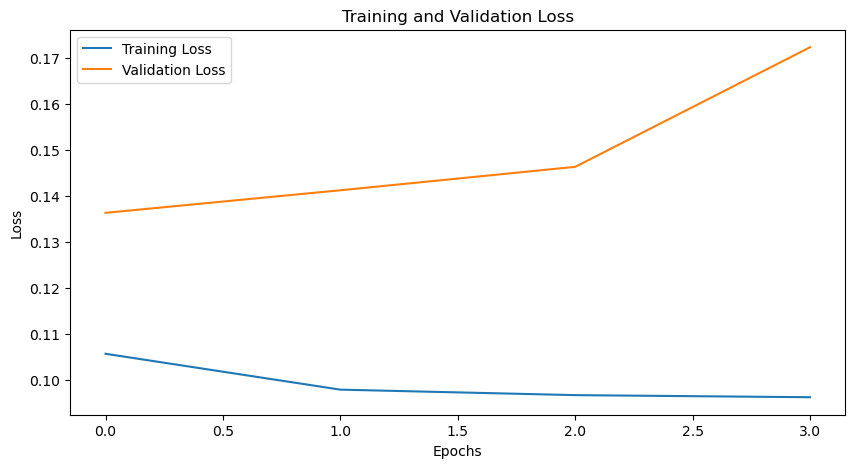

CPU times: user 4h 3min 14s, sys: 19min 27s, total: 4h 22min 41s
Wall time: 8min 12s


In [51]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [52]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 21min 7s, sys: 1min 36s, total: 22min 44s
Wall time: 42.7 s


In [53]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 4.37 s, sys: 304 ms, total: 4.68 s
Wall time: 146 ms


In [54]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-2.92492628e-01,  9.94351864e-01,  5.90378821e-01, -1.76250264e-02,
          2.94930547e-01, -3.44887674e-01,  4.39270258e-01, -2.09441036e-02,
         -2.95864850e-01,  1.17284767e-02, -6.08442426e-01,  1.42639744e+00,
          9.49947461e-02, -2.03406125e-01,  5.13330735e-02,  2.52882779e-01,
          4.90106791e-01,  3.80863118e+00, -9.89216149e-01, -3.83540876e-02,
          1.73595339e-01,  3.46558839e-01,  3.38230543e-02, -3.12897414e-01,
          1.91722438e-01, -2.32988119e-01, -7.36950994e-01,  5.12155414e-01,
         -2.10959148e+00, -4.19250309e-01, -3.56245071e-01, -1.31289947e+00,
          6.65513992e-01, -7.62211800e-01, -2.46187344e-01, -5.62065780e-01,
         -7.32659474e-02,  3.22931439e-01,  4.23310488e-01, -5.44983089e-01,
          1.77121305e+00, -5.76090775e-02,  4.03220087e-01,  7.50650883e-01,
          1.70564786e-01, -2.06061602e+00,  6.43977702e-01, -7.42019653e-01,
          4.55884218e-01, -2.31097445e-01,  3.22145998e-01,  4.42

#### Cosine Similarity Matrix

In [55]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 51.5 ms, sys: 4.18 ms, total: 55.7 ms
Wall time: 1.73 ms


array([[1.0000001, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000004, ..., 1.0000002, 1.0000004,
        1.0000002],
       [1.0000002, 1.0000004, 1.0000004, ..., 1.0000002, 1.0000004,
        1.0000002],
       ...,
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000001],
       [1.0000002, 1.0000004, 1.0000004, ..., 1.0000002, 1.0000004,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000001, 1.0000002,
        1.0000001]], dtype=float32)

#### 4-Train 200 Stocks

In [66]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 200  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 246265
Validation Dataset Length: 6790
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 605 ms, sys: 11.6 ms, total: 617 ms
Wall time: 551 ms


#### Build and Train Model

In [67]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [68]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Epoch 1/5 took 4549.85 seconds
Epoch 1/5, Training Loss: 0.09823086344019322, Validation Loss: 0.09637553549148667
Epoch 2/5 took 4538.42 seconds
Epoch 2/5, Training Loss: 0.0934901253812561, Validation Loss: 0.09464117520851709


KeyboardInterrupt: 

#### Stock Embedding

In [ ]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

### Case 1: Model-new__getitem__1 (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [56]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.group_length = {
            name: len(group) - self.window_size for name, group in self.groups if len(group) > self.window_size
        }  # ["12": 882, "13": 882, 882, 501, ...., 882]
        self.length = sum(self.group_length.values())

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        current_idx = idx
        for name, group in self.groups:
            if len(group) > self.window_size:
                if current_idx < len(group) - self.window_size:
                    i = current_idx
                    permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    return {
                        "features": torch.tensor(X, dtype=torch.float),
                        "target": torch.tensor(y, dtype=torch.float),
                        "permno_id": name,
                    }
                else:
                    current_idx -= len(group) - self.window_size

In [27]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [57]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"][:10000]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"][:1000]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 8976
Validation Dataset Length: 245
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 228 ms, sys: 10.9 ms, total: 239 ms
Wall time: 201 ms


#### Build and Train Model

In [58]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Batch 0, Loss: 0.12327508628368378, train_loss: 0.12327508628368378
Epoch 1/5 took 42.54 seconds
Epoch 1/5, Training Loss: 0.09845762572572749, Validation Loss: 0.06790227023884654
Batch 0, Loss: 0.04030826687812805, train_loss: 0.04030826687812805
Epoch 2/5 took 42.46 seconds
Epoch 2/5, Training Loss: 0.08029379008927803, Validation Loss: 0.06503692548722029
Batch 0, Loss: 0.036820508539676666, train_loss: 0.036820508539676666
Epoch 3/5 took 42.61 seconds
Epoch 3/5, Training Loss: 0.07714035902901477, Validation Loss: 0.06524736573919654
Batch 0, Loss: 0.03752703219652176, train_loss: 0.03752703219652176
Epoch 4/5 took 42.51 seconds
Epoch 4/5, Training Loss: 0.07526123536969419, Validation Loss: 0.06596908904612064
Batch 0, Loss: 0.03370091691613197, train_loss: 0.03370091691613197
Epoch 5/5 took 42.36 seconds
Epoch 5/5, Training Loss: 0.07419619495811411, Validation Loss: 0.06808312330394983
Early stopping triggered.
Training Complete


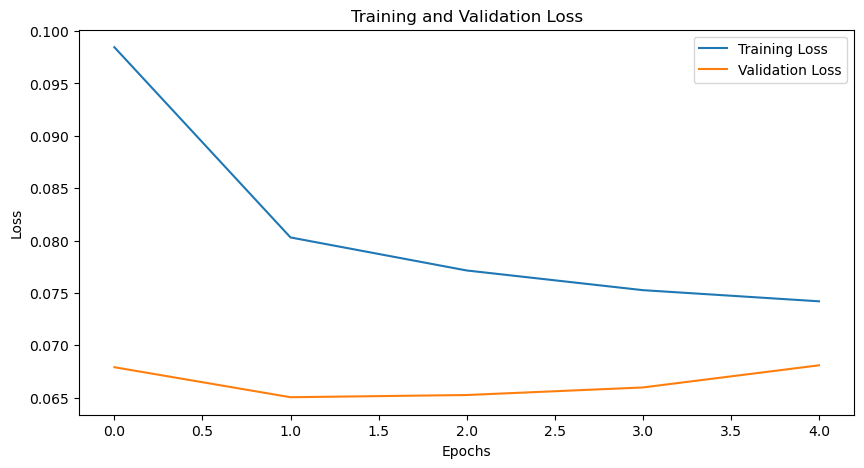

CPU times: user 1h 44min 56s, sys: 8min 29s, total: 1h 53min 25s
Wall time: 3min 32s


In [59]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10000 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [60]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 17min 35s, sys: 1min 23s, total: 18min 59s
Wall time: 35.6 s


In [61]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 315 ms, sys: 20.7 ms, total: 336 ms
Wall time: 10.5 ms


In [62]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-7.64984429e-01, -1.74424100e+00,  5.71758568e-01, -1.24141037e+00,
          6.96887970e-01, -8.46858263e-01,  1.29421628e+00, -4.05220002e-01,
          6.75092101e-01,  8.43675137e-01,  2.41723090e-01,  1.29715413e-01,
         -5.54405212e-01, -9.73854363e-01, -9.23132896e-02,  1.40557611e+00,
         -3.52494836e-01, -1.93387008e+00, -8.58728528e-01, -1.69605643e-01,
         -5.78511357e-01, -4.67596084e-01, -4.68010366e-01,  5.25770485e-01,
          1.31951523e+00,  5.83540440e-01,  3.24435890e-01,  2.48614714e-01,
          8.14241707e-01,  9.36382949e-01, -3.76716703e-01,  5.80498993e-01,
         -9.20481861e-01,  9.64016557e-01,  7.21984327e-01, -1.59509611e+00,
          1.07691741e+00,  5.58522642e-01,  1.35784543e+00, -3.12537372e-01,
          7.90900707e-01,  5.83802760e-01, -1.54951259e-01, -3.65062803e-01,
          1.09442127e+00,  7.96606913e-02, -1.34528100e-01, -1.56305051e+00,
         -5.53985894e-01, -2.18695068e+00,  1.35164827e-01,  9.61

#### Cosine Similarity Matrix

In [63]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 41.6 ms, sys: 0 ns, total: 41.6 ms
Wall time: 1.29 ms


array([[1.0000001 , 0.9999996 , 1.        , 0.9999998 , 0.99999964,
        0.99999994, 0.99998516, 0.99567425],
       [0.9999996 , 1.0000001 , 0.9999997 , 0.9999998 , 0.9999997 ,
        0.9999996 , 0.9999868 , 0.9957035 ],
       [1.        , 0.9999997 , 0.99999994, 0.9999997 , 0.9999999 ,
        0.9999998 , 0.99998665, 0.9957002 ],
       [0.9999998 , 0.9999998 , 0.9999997 , 1.0000002 , 0.9999995 ,
        0.9999993 , 0.9999866 , 0.9956983 ],
       [0.99999964, 0.9999997 , 0.9999999 , 0.9999995 , 1.0000004 ,
        0.9999995 , 0.9999864 , 0.9956858 ],
       [0.99999994, 0.9999996 , 0.9999998 , 0.9999993 , 0.9999995 ,
        0.99999994, 0.99998564, 0.99567544],
       [0.99998516, 0.9999868 , 0.99998665, 0.9999866 , 0.9999864 ,
        0.99998564, 1.        , 0.99613637],
       [0.99567425, 0.9957035 , 0.9957002 , 0.9956983 , 0.9956858 ,
        0.99567544, 0.99613637, 0.9999999 ]], dtype=float32)

#### Model Features Check

In [75]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [76]:
batch["features"].shape

torch.Size([32, 128, 560])

In [77]:
batch["target"].shape

torch.Size([32, 11])

In [78]:
len(batch["permno_id"])

32

In [79]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [80]:
model(batch["features"].to(device))

(tensor([[-0.0300,  0.0192,  0.0604,  0.0808,  0.0161,  0.0663,  0.0246,  0.0071,
           0.1666,  0.1783,  0.1594],
         [-0.0295,  0.0190,  0.0601,  0.0813,  0.0159,  0.0662,  0.0245,  0.0071,
           0.1667,  0.1789,  0.1595],
         [-0.0291,  0.0188,  0.0599,  0.0818,  0.0157,  0.0661,  0.0243,  0.0070,
           0.1668,  0.1794,  0.1596],
         [-0.0287,  0.0186,  0.0597,  0.0822,  0.0156,  0.0661,  0.0242,  0.0070,
           0.1668,  0.1799,  0.1596],
         [-0.0284,  0.0184,  0.0596,  0.0826,  0.0154,  0.0660,  0.0241,  0.0069,
           0.1669,  0.1803,  0.1596],
         [-0.0280,  0.0182,  0.0594,  0.0830,  0.0153,  0.0659,  0.0239,  0.0069,
           0.1669,  0.1808,  0.1597],
         [-0.0277,  0.0180,  0.0593,  0.0834,  0.0152,  0.0659,  0.0238,  0.0069,
           0.1669,  0.1812,  0.1597],
         [-0.0274,  0.0179,  0.0592,  0.0838,  0.0151,  0.0658,  0.0237,  0.0068,
           0.1669,  0.1816,  0.1597],
         [-0.0271,  0.0177,  0.0590,  0.

In [81]:
# train_dataset.sequences[-5:]

In [82]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 2: Model-new__getitem__2 (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [26]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = list(self.data.groupby("permno_id"))
        self.group_length = {
            name: len(group) - self.window_size for name, group in self.groups if len(group) > self.window_size
        }
        self.length = sum(self.group_length.values())

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        current_idx = idx
        for group_index, (name, current_group_length) in enumerate(self.group_length.items()):
            if current_idx >= current_group_length:
                current_idx -= current_group_length
                continue

            # this is the group i'm interested in!
            i = current_idx
            group = self.groups[group_index][1]  # Access the group by index

            # extract the data for the ith window from the current group
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            X = group[self.input_columns].iloc[i : i + self.window_size].values
            X = np.concatenate(
                [X, permno_id_one_hot[i : i + self.window_size]], axis=1
            )  # Concatenate one-hot encoded permno_id
            X = np.concatenate(
                [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
            )
            y = group[self.target_columns].iloc[i + self.window_size].values

            return {
                "features": torch.tensor(X, dtype=torch.float),
                "target": torch.tensor(y, dtype=torch.float),
                "permno_id": name,
            }

In [27]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [28]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"][:10000]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"][:1000]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 8976
Validation Dataset Length: 245
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 269 ms, sys: 0 ns, total: 269 ms
Wall time: 227 ms


#### Build and Train Model

In [29]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [30]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Batch 0, Loss: 0.108280248939991, train_loss: 0.108280248939991
Batch 200, Loss: 0.06300024688243866, train_loss: 19.536956880241632


IndexError: single positional indexer is out-of-bounds

#### Stock Embedding

In [74]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

KeyboardInterrupt: 

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [92]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [93]:
batch["features"].shape

torch.Size([32, 128, 560])

In [94]:
batch["target"].shape

torch.Size([32, 11])

In [95]:
len(batch["permno_id"])

32

In [96]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [97]:
model(batch["features"].to(device))

(tensor([[0.0028, 0.0089, 0.0225, 0.1116, 0.0209, 0.0207, 0.0041, 0.0094, 0.1427,
          0.1889, 0.1959],
         [0.0027, 0.0088, 0.0225, 0.1112, 0.0208, 0.0207, 0.0042, 0.0095, 0.1427,
          0.1890, 0.1959],
         [0.0026, 0.0087, 0.0225, 0.1109, 0.0209, 0.0207, 0.0043, 0.0097, 0.1427,
          0.1891, 0.1959],
         [0.0025, 0.0085, 0.0225, 0.1106, 0.0209, 0.0207, 0.0044, 0.0098, 0.1427,
          0.1891, 0.1959],
         [0.0023, 0.0084, 0.0225, 0.1104, 0.0209, 0.0207, 0.0045, 0.0099, 0.1426,
          0.1892, 0.1959],
         [0.0022, 0.0082, 0.0225, 0.1101, 0.0210, 0.0207, 0.0045, 0.0101, 0.1426,
          0.1892, 0.1959],
         [0.0020, 0.0082, 0.0225, 0.1099, 0.0210, 0.0206, 0.0046, 0.0102, 0.1425,
          0.1892, 0.1959],
         [0.0019, 0.0081, 0.0225, 0.1096, 0.0211, 0.0206, 0.0046, 0.0104, 0.1425,
          0.1893, 0.1959],
         [0.0018, 0.0080, 0.0224, 0.1094, 0.0212, 0.0206, 0.0047, 0.0105, 0.1424,
          0.1893, 0.1959],
         [0.0017, 0

In [98]:
# train_dataset.sequences[-5:]

In [99]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 3: Model-new__getitem__3 (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [37]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Precompute windows
        self.windows = []
        for name, group in self.data.groupby("permno_id"):
            group_length = len(group) - self.window_size
            if group_length > 0:
                for i in range(group_length):
                    self.windows.append((group, i, name))
        
        self.length = len(self.windows)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        group, i, name = self.windows[idx]

        # Precomputed one-hot encoding for this group
        permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
        
        # Extract the data for the ith window from the current group
        X = group[self.input_columns].iloc[i : i + self.window_size].values
        X = np.concatenate(
            [X, permno_id_one_hot[i : i + self.window_size]], axis=1
        )  # Concatenate one-hot encoded permno_id
        X = np.concatenate(
            [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
        )
        y = group[self.target_columns].iloc[i + self.window_size].values

        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": name,
        }


In [38]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [42]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"][:1000]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"][:1000]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 872
Validation Dataset Length: 35
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 187 ms, sys: 12.2 ms, total: 200 ms
Wall time: 190 ms


#### Build and Train Model

In [43]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Batch 0, Loss: 0.10849661380052567, train_loss: 0.10849661380052567
Epoch 1/5 took 20.45 seconds
Epoch 1/5, Training Loss: 0.1348807370024068, Validation Loss: 0.08726345375180244
Batch 0, Loss: 0.0827748253941536, train_loss: 0.0827748253941536
Epoch 2/5 took 20.52 seconds
Epoch 2/5, Training Loss: 0.10697918039347444, Validation Loss: 0.07154358178377151
Batch 0, Loss: 0.0732186958193779, train_loss: 0.0732186958193779
Epoch 3/5 took 20.63 seconds
Epoch 3/5, Training Loss: 0.09683812955128294, Validation Loss: 0.06552331522107124
Batch 0, Loss: 0.06801658868789673, train_loss: 0.06801658868789673
Epoch 4/5 took 20.44 seconds
Epoch 4/5, Training Loss: 0.09327469140823398, Validation Loss: 0.06592895835638046
Batch 0, Loss: 0.06459281593561172, train_loss: 0.06459281593561172
Epoch 5/5 took 20.13 seconds
Epoch 5/5, Training Loss: 0.08937340549060277, Validation Loss: 0.06445097364485264
Training Complete


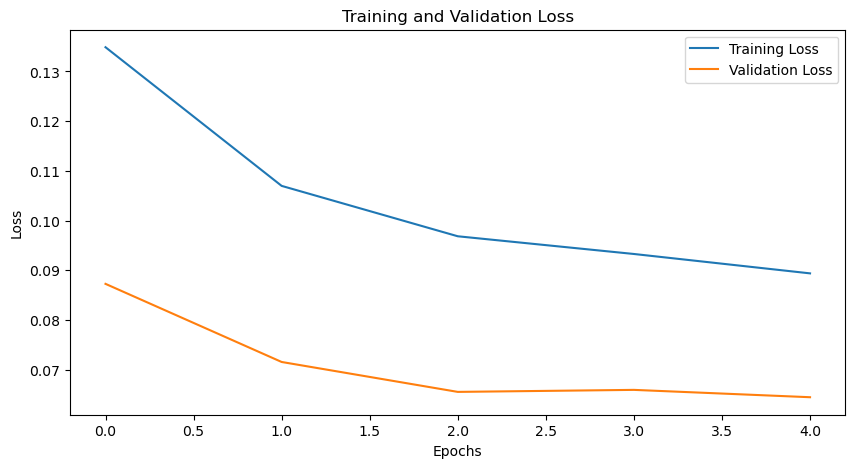

CPU times: user 12min 51s, sys: 47.6 s, total: 13min 38s
Wall time: 1min 42s


In [44]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [88]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [89]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [90]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-3.78572136e-01,  4.02556390e-01,  4.87570375e-01, -9.71987426e-01,
          1.54144049e+00, -3.19399774e-01,  2.12927198e+00, -9.93603375e-03,
         -7.25138724e-01, -1.75474293e-03, -3.52325410e-01, -6.04183018e-01,
         -3.14344913e-01,  8.13303053e-01,  1.71755746e-01,  3.56624603e-01,
         -2.89752632e-01, -1.84308982e+00,  5.91277927e-02,  2.29618454e+00,
          1.16721559e+00, -1.79804754e+00, -1.54913947e-01, -3.25009853e-01,
          3.89528602e-01, -7.40367651e-01,  9.27669883e-01, -8.65040064e-01,
          1.18745551e-01,  7.20537126e-01,  2.93112785e-01,  7.18086898e-01,
          6.01840876e-02, -8.33960176e-01, -1.87334335e+00,  8.47103179e-01,
         -2.39123726e+00, -2.19618782e-01, -3.35128307e-01, -5.18376648e-01,
         -5.38411558e-01, -1.18982148e+00,  1.11462069e+00,  2.52209306e-01,
          1.06397140e+00, -9.44217205e-01,  4.28313375e-01, -1.58407426e+00,
          2.26807535e-01,  3.56458902e-01, -1.49498731e-01, -3.11

#### Cosine Similarity Matrix

In [91]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000001]], dtype=float32)

#### Model Features Check

In [92]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [93]:
batch["features"].shape

torch.Size([32, 128, 560])

In [94]:
batch["target"].shape

torch.Size([32, 11])

In [95]:
len(batch["permno_id"])

32

In [96]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [97]:
model(batch["features"].to(device))

(tensor([[0.0028, 0.0089, 0.0225, 0.1116, 0.0209, 0.0207, 0.0041, 0.0094, 0.1427,
          0.1889, 0.1959],
         [0.0027, 0.0088, 0.0225, 0.1112, 0.0208, 0.0207, 0.0042, 0.0095, 0.1427,
          0.1890, 0.1959],
         [0.0026, 0.0087, 0.0225, 0.1109, 0.0209, 0.0207, 0.0043, 0.0097, 0.1427,
          0.1891, 0.1959],
         [0.0025, 0.0085, 0.0225, 0.1106, 0.0209, 0.0207, 0.0044, 0.0098, 0.1427,
          0.1891, 0.1959],
         [0.0023, 0.0084, 0.0225, 0.1104, 0.0209, 0.0207, 0.0045, 0.0099, 0.1426,
          0.1892, 0.1959],
         [0.0022, 0.0082, 0.0225, 0.1101, 0.0210, 0.0207, 0.0045, 0.0101, 0.1426,
          0.1892, 0.1959],
         [0.0020, 0.0082, 0.0225, 0.1099, 0.0210, 0.0206, 0.0046, 0.0102, 0.1425,
          0.1892, 0.1959],
         [0.0019, 0.0081, 0.0225, 0.1096, 0.0211, 0.0206, 0.0046, 0.0104, 0.1425,
          0.1893, 0.1959],
         [0.0018, 0.0080, 0.0224, 0.1094, 0.0212, 0.0206, 0.0047, 0.0105, 0.1424,
          0.1893, 0.1959],
         [0.0017, 0

In [98]:
# train_dataset.sequences[-5:]

In [99]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 0: Model-Baseline (128 days, 3 features and 1 target)
Features:  
'log_return'  
'postional encoding'  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Label:
'log_return' 

#### Create Dataset

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [25]:
%%time
# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

In [25]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/10, Training Loss: 0.016772990554864427, Validation Loss: 0.012710189952723272
Epoch 2/10, Training Loss: 0.015977680185870792, Validation Loss: 0.012706282488297508
Epoch 3/10, Training Loss: 0.015972748527372835, Validation Loss: 0.012705359910364115
Epoch 4/10, Training Loss: 0.015971083172198013, Validation Loss: 0.012702870438379095
Epoch 5/10, Training Loss: 0.01597144005120948, Validation Loss: 0.012703222868181978
Epoch 6/10, Training Loss: 0.015970967407068277, Validation Loss: 0.012703467306148372
Epoch 7/10, Training Loss: 0.015970845111379313, Validation Loss: 0.012704241909959635
Epoch 8/10, Training Loss: 0.01597067748543092, Validation Loss: 0.01270369920443727
Epoch 9/10, Training Loss: 0.015970935315515838, Validation Loss: 0.012704578700149226
Early stopping triggered.
Training Complete


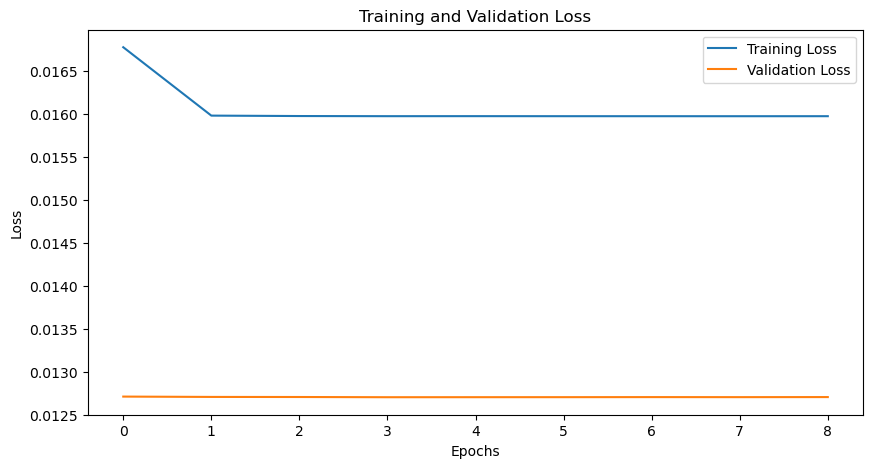

In [26]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [ ]:
for batch in train_dataloader:
    print(batch)
    break

In [ ]:
batch["features"].shape

In [ ]:
batch["target"].shape

In [ ]:
len(batch["permno_id"])

In [ ]:
batch["features"][:5]

In [ ]:
model(batch["features"].to(device))

In [ ]:
train_dataset.sequences[-5:]

In [ ]:
np.array(stock_embeddings["10104"]).shape

### Case 1: Model-Simple-1 (128 days, 7 features and 11 targets, simple - less embedbding size and less layers)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [24]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 4s, sys: 2min 6s, total: 9min 11s
Wall time: 9min 11s


#### Build and Train Model

In [26]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 659.05 seconds
Epoch 1/5, Training Loss: 0.09171998954973773, Validation Loss: 0.08243234977632964
Epoch 2/5 took 717.29 seconds
Epoch 2/5, Training Loss: 0.08866600332726357, Validation Loss: 0.083120334142705
Epoch 3/5 took 720.51 seconds
Epoch 3/5, Training Loss: 0.08819506536535197, Validation Loss: 0.08349098105198977
Epoch 4/5 took 702.14 seconds
Epoch 4/5, Training Loss: 0.08798040473158215, Validation Loss: 0.08476964948179365
Early stopping triggered.
Training Complete


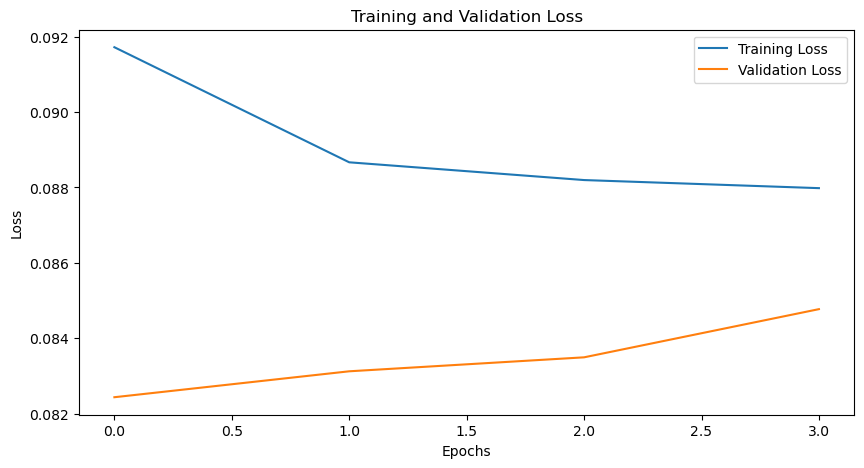

CPU times: user 1d 12h 40min 43s, sys: 38min 38s, total: 1d 13h 19min 21s
Wall time: 46min 39s


In [27]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=128,
    n_heads=8,
    ff_dim=512,
    n_layers=3,
    output_dim=len(train_dataset.target_columns),
    dropout=0.1,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [ ]:
for batch in train_dataloader:
    print(batch)
    break

In [ ]:
batch["features"].shape

In [ ]:
batch["target"].shape

In [ ]:
len(batch["permno_id"])

In [ ]:
batch["features"][:5]

In [ ]:
model(batch["features"].to(device))

In [ ]:
train_dataset.sequences[-5:]

In [ ]:
np.array(stock_embeddings["10104"]).shape

### Case 2: Model-Simple-2 (128 days, 7 features and 11 targets, simple - less embedbding size and less layers)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [24]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 6s, sys: 2min 3s, total: 9min 9s
Wall time: 9min 9s


#### Build and Train Model

In [25]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 176.11 seconds
Epoch 1/5, Training Loss: 0.09548261788240728, Validation Loss: 0.08202063690136079
Epoch 2/5 took 192.30 seconds
Epoch 2/5, Training Loss: 0.08957547311283781, Validation Loss: 0.08231601492204026
Epoch 3/5 took 198.16 seconds
Epoch 3/5, Training Loss: 0.08884213348748603, Validation Loss: 0.0824990516249724
Epoch 4/5 took 206.06 seconds
Epoch 4/5, Training Loss: 0.08854140222563849, Validation Loss: 0.08267921756724922
Early stopping triggered.
Training Complete


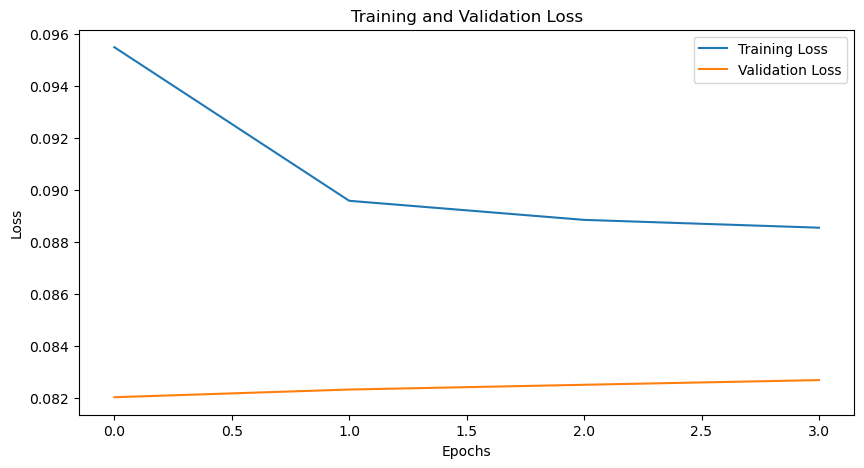

CPU times: user 10h 11min 11s, sys: 7min 8s, total: 10h 18min 19s
Wall time: 12min 52s


In [27]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=64,
    n_heads=4,
    ff_dim=256,
    n_layers=1,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[128, 64],
    dropout=0.1,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [28]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [29]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [30]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.0617927 , -0.02709917,  0.86792207, -0.31484175, -0.81912076,
          0.8028026 , -0.2765189 ,  1.4565225 ,  0.61450523,  1.0631409 ,
         -0.04765464,  0.4420784 ,  0.07808794, -0.3080687 , -0.61438376,
         -0.46768513,  0.29218423, -0.00696983, -2.2455573 ,  1.5239687 ,
          1.7623643 ,  0.05457364,  2.0052931 ,  1.2241873 , -0.13221222,
          1.2523236 , -0.8419139 ,  0.57833314, -1.1683428 ,  0.35375145,
          0.62363106, -0.19519901, -0.67994744, -2.364642  ,  0.5822225 ,
          0.6329598 , -0.11437857, -1.2658938 ,  0.42877623,  0.48615086,
         -1.0350633 ,  1.2969047 ,  0.18424089,  0.582294  , -1.2053487 ,
          2.198266  , -1.0248904 ,  1.2480083 , -1.0892895 , -1.7120746 ,
         -0.8202889 , -0.31682447, -0.75132275, -1.2320019 , -1.5238146 ,
         -0.957798  ,  0.6482478 , -0.40366572, -0.64492446,  0.88777137,
          0.30129698,  0.23063752, -0.891486  , -0.25202587], dtype=float32)),
 ('10107',
  array([ 1

#### Cosine Similarity Matrix

In [31]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000001 , 0.99999785, 0.9999972 , ..., 0.999998  , 0.9999977 ,
        0.9999981 ],
       [0.99999785, 0.99999994, 0.9999977 , ..., 0.99999774, 0.9999978 ,
        0.999998  ],
       [0.9999972 , 0.9999977 , 0.9999999 , ..., 0.9999982 , 0.99999815,
        0.99999803],
       ...,
       [0.999998  , 0.99999774, 0.9999982 , ..., 1.0000002 , 0.99999744,
        0.99999845],
       [0.9999977 , 0.9999978 , 0.99999815, ..., 0.99999744, 1.        ,
        0.99999815],
       [0.9999981 , 0.999998  , 0.99999803, ..., 0.99999845, 0.99999815,
        1.        ]], dtype=float32)

#### Model Features Check

In [32]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [33]:
batch["features"].shape

torch.Size([32, 128, 560])

In [34]:
batch["target"].shape

torch.Size([32, 11])

In [35]:
len(batch["permno_id"])

32

In [36]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [37]:
model(batch["features"].to(device))

(tensor([[ 2.5005e-03,  9.6344e-03,  3.3397e-02,  1.2389e-01,  8.0370e-03,
           4.3462e-02, -3.1803e-03,  1.5908e-02,  2.0169e-01,  2.2342e-01,
           2.2822e-01],
         [ 2.4887e-03,  9.6734e-03,  3.3588e-02,  1.2466e-01,  8.2112e-03,
           4.3611e-02, -3.0543e-03,  1.6057e-02,  2.0286e-01,  2.2447e-01,
           2.2920e-01],
         [ 2.4768e-03,  9.7118e-03,  3.3775e-02,  1.2544e-01,  8.3838e-03,
           4.3758e-02, -2.9290e-03,  1.6205e-02,  2.0402e-01,  2.2551e-01,
           2.3017e-01],
         [ 2.4674e-03,  9.7488e-03,  3.3974e-02,  1.2622e-01,  8.5544e-03,
           4.3911e-02, -2.8012e-03,  1.6361e-02,  2.0523e-01,  2.2659e-01,
           2.3115e-01],
         [ 2.4554e-03,  9.7860e-03,  3.4148e-02,  1.2695e-01,  8.7251e-03,
           4.4050e-02, -2.6858e-03,  1.6499e-02,  2.0633e-01,  2.2757e-01,
           2.3207e-01],
         [ 2.4412e-03,  9.8239e-03,  3.4304e-02,  1.2763e-01,  8.8820e-03,
           4.4179e-02, -2.5721e-03,  1.6625e-02,  2.073

In [38]:
train_dataset.sequences[-5:]

[(array([[-3.30853331e-02, -1.46880000e-02, -1.88230000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.31300000e+03],
         [ 5.58238943e-03,  8.88100000e-03,  3.76000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.31400000e+03],
         [-9.46061079e-03,  5.69000000e-04,  2.37000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.31500000e+03],
         ...,
         [-1.47806983e-02, -1.52550000e-02, -8.46000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.43800000e+03],
         [-2.65893853e-02, -1.74260000e-02, -1.82480000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.43900000e+03],
         [-4.32363651e-02, -3.28000000e-04,  2.98000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.44000000e+03]]),
  array([ 0.00857909,  0.00857909,  0.33228679,  0.33228679,  0.02155068,
          0.02155068, -0.03861463,  0.03861463,  0.43503314,  0.35140562,
          0.51255168]),
  '93436'),
 (array([[ 5.58238943e-03,  8.88

In [39]:
np.array(stock_embeddings["10104"]).shape

(64,)

### Case 3: Model-Complex (128 days, 7 features and 11 targets, simple - less embedbding size and less layers)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [24]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 4s, sys: 2min 5s, total: 9min 9s
Wall time: 9min 9s


#### Build and Train Model

In [26]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [ ]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=1024,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Epoch 1/5 took 10786.87 seconds
Epoch 1/5, Training Loss: 0.09050416299881606, Validation Loss: 0.08882468211508933
Epoch 2/5 took 11287.22 seconds
Epoch 2/5, Training Loss: 0.08813030013946346, Validation Loss: 0.08532720567899293


#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [30]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.0617927 , -0.02709917,  0.86792207, -0.31484175, -0.81912076,
          0.8028026 , -0.2765189 ,  1.4565225 ,  0.61450523,  1.0631409 ,
         -0.04765464,  0.4420784 ,  0.07808794, -0.3080687 , -0.61438376,
         -0.46768513,  0.29218423, -0.00696983, -2.2455573 ,  1.5239687 ,
          1.7623643 ,  0.05457364,  2.0052931 ,  1.2241873 , -0.13221222,
          1.2523236 , -0.8419139 ,  0.57833314, -1.1683428 ,  0.35375145,
          0.62363106, -0.19519901, -0.67994744, -2.364642  ,  0.5822225 ,
          0.6329598 , -0.11437857, -1.2658938 ,  0.42877623,  0.48615086,
         -1.0350633 ,  1.2969047 ,  0.18424089,  0.582294  , -1.2053487 ,
          2.198266  , -1.0248904 ,  1.2480083 , -1.0892895 , -1.7120746 ,
         -0.8202889 , -0.31682447, -0.75132275, -1.2320019 , -1.5238146 ,
         -0.957798  ,  0.6482478 , -0.40366572, -0.64492446,  0.88777137,
          0.30129698,  0.23063752, -0.891486  , -0.25202587], dtype=float32)),
 ('10107',
  array([ 1

#### Cosine Similarity Matrix

In [31]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000001 , 0.99999785, 0.9999972 , ..., 0.999998  , 0.9999977 ,
        0.9999981 ],
       [0.99999785, 0.99999994, 0.9999977 , ..., 0.99999774, 0.9999978 ,
        0.999998  ],
       [0.9999972 , 0.9999977 , 0.9999999 , ..., 0.9999982 , 0.99999815,
        0.99999803],
       ...,
       [0.999998  , 0.99999774, 0.9999982 , ..., 1.0000002 , 0.99999744,
        0.99999845],
       [0.9999977 , 0.9999978 , 0.99999815, ..., 0.99999744, 1.        ,
        0.99999815],
       [0.9999981 , 0.999998  , 0.99999803, ..., 0.99999845, 0.99999815,
        1.        ]], dtype=float32)

#### Model Features Check

In [32]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [33]:
batch["features"].shape

torch.Size([32, 128, 560])

In [34]:
batch["target"].shape

torch.Size([32, 11])

In [35]:
len(batch["permno_id"])

32

In [36]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [37]:
model(batch["features"].to(device))

(tensor([[ 2.5005e-03,  9.6344e-03,  3.3397e-02,  1.2389e-01,  8.0370e-03,
           4.3462e-02, -3.1803e-03,  1.5908e-02,  2.0169e-01,  2.2342e-01,
           2.2822e-01],
         [ 2.4887e-03,  9.6734e-03,  3.3588e-02,  1.2466e-01,  8.2112e-03,
           4.3611e-02, -3.0543e-03,  1.6057e-02,  2.0286e-01,  2.2447e-01,
           2.2920e-01],
         [ 2.4768e-03,  9.7118e-03,  3.3775e-02,  1.2544e-01,  8.3838e-03,
           4.3758e-02, -2.9290e-03,  1.6205e-02,  2.0402e-01,  2.2551e-01,
           2.3017e-01],
         [ 2.4674e-03,  9.7488e-03,  3.3974e-02,  1.2622e-01,  8.5544e-03,
           4.3911e-02, -2.8012e-03,  1.6361e-02,  2.0523e-01,  2.2659e-01,
           2.3115e-01],
         [ 2.4554e-03,  9.7860e-03,  3.4148e-02,  1.2695e-01,  8.7251e-03,
           4.4050e-02, -2.6858e-03,  1.6499e-02,  2.0633e-01,  2.2757e-01,
           2.3207e-01],
         [ 2.4412e-03,  9.8239e-03,  3.4304e-02,  1.2763e-01,  8.8820e-03,
           4.4179e-02, -2.5721e-03,  1.6625e-02,  2.073

In [38]:
train_dataset.sequences[-5:]

[(array([[-3.30853331e-02, -1.46880000e-02, -1.88230000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.31300000e+03],
         [ 5.58238943e-03,  8.88100000e-03,  3.76000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.31400000e+03],
         [-9.46061079e-03,  5.69000000e-04,  2.37000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.31500000e+03],
         ...,
         [-1.47806983e-02, -1.52550000e-02, -8.46000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.43800000e+03],
         [-2.65893853e-02, -1.74260000e-02, -1.82480000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.43900000e+03],
         [-4.32363651e-02, -3.28000000e-04,  2.98000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.44000000e+03]]),
  array([ 0.00857909,  0.00857909,  0.33228679,  0.33228679,  0.02155068,
          0.02155068, -0.03861463,  0.03861463,  0.43503314,  0.35140562,
          0.51255168]),
  '93436'),
 (array([[ 5.58238943e-03,  8.88

In [39]:
np.array(stock_embeddings["10104"]).shape

(64,)

### Case 3: Model (7 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Label:
'log_return' 

In [23]:
cleaned_data

date permno_id  log_return  abs_log_return  \
0      2018-01-02     10104   -0.013843        0.013843   
1      2018-01-03     10104    0.022897        0.022897   
2      2018-01-04     10104    0.009803        0.009803   
3      2018-01-05     10104    0.006001        0.006001   
4      2018-01-08     10104    0.010467        0.010467   
...           ...       ...         ...             ...   
794366 2023-11-13     93436    0.041342        0.041342   
794367 2023-11-14     93436    0.059438        0.059438   
794368 2023-11-15     93436    0.022614        0.022614   
794369 2023-11-16     93436   -0.038835        0.038835   
794370 2023-11-17     93436    0.003035        0.003035   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                             0.000000                      0.000000   
1                             0.006404                      0.004872   
2                             0.004048                      0.000960   
3                             0.009581                      0.006722   
4                             0.002142                      0.005354   
...                                ...                           ...   
794366                        0.000410                      0.000916   
794367                        0.025191                      0.037168   
794368                        0.004464                      0.003711   
794369                       -0.000869                     -0.004937   
794370                        0.002385                      0.003949   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                      0.000000               0.000000      0.309424   
1                      0.005904               0.007983      0.234088   
2                      0.004021               0.000852      0.183199   
3                      0.006193               0.002919      0.230474   
4                      0.001829               0.005828      0.161223   
...                         ...                    ...           ...   
794366                -0.000400              -0.000701      0.266036   
794367                 0.022485               0.018177     -0.041740   
794368                 0.001887               0.006906     -0.135146   
794369                -0.001334               0.004114      0.324775   
794370                 0.003156              -0.000656      0.235617   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0               0.309424       0.131071           0.131071       0.011619   
1               0.234088       0.107382           0.107382       0.006475   
2               0.183199       0.097613           0.097613       0.009651   
3               0.230474       0.120486           0.120486       0.015437   
4               0.161223       0.083731           0.083731       0.012476   
...                  ...            ...                ...            ...   
794366          0.266036       0.068729           0.068729       0.039733   
794367          0.041740       0.007099           0.007099       0.025312   
794368          0.135146      -0.018335           0.018335       0.024006   
794369          0.324775       0.050085           0.050085       0.026224   
794370          0.235617       0.052651           0.052651       0.019067   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  
0                0.011619      0.136136       0.109282       0.276310  
1                0.006475      0.091648       0.081082       0.268724  
2                0.009651      0.089939       0.079524       0.273385  
3                0.015437      0.105015       0.107098       0.281463  
4                0.012476      0.105560       0.139328       0.280139  
...                   ...           ...            ...            ...  
794366           0.039733      0.530805       0.426937       0.378195  
794367           0.025312      0.383085       0.347634       0.339596  
7

#### Create Dataset

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

Starting Training...
Epoch 1/10, Training Loss: 0.09156142956979248, Validation Loss: 0.08231207029314012
Epoch 2/10, Training Loss: 0.08915924277880051, Validation Loss: 0.07353917578812158
Epoch 3/10, Training Loss: 0.08909141032479667, Validation Loss: 0.073491502792435
Epoch 4/10, Training Loss: 0.08902445788692094, Validation Loss: 0.07509884722644261
Epoch 5/10, Training Loss: 0.08903481386801218, Validation Loss: 0.07299888564787708
Epoch 6/10, Training Loss: 0.08895725816991294, Validation Loss: 0.07657859663417423
Epoch 7/10, Training Loss: 0.08898307561385216, Validation Loss: 0.07334241026137596
Epoch 8/10, Training Loss: 0.08893751073641985, Validation Loss: 0.07232822793534084
Epoch 9/10, Training Loss: 0.08894478459983492, Validation Loss: 0.07350584668814393
Epoch 10/10, Training Loss: 0.08894648703423268, Validation Loss: 0.07246848407781194
Training Complete


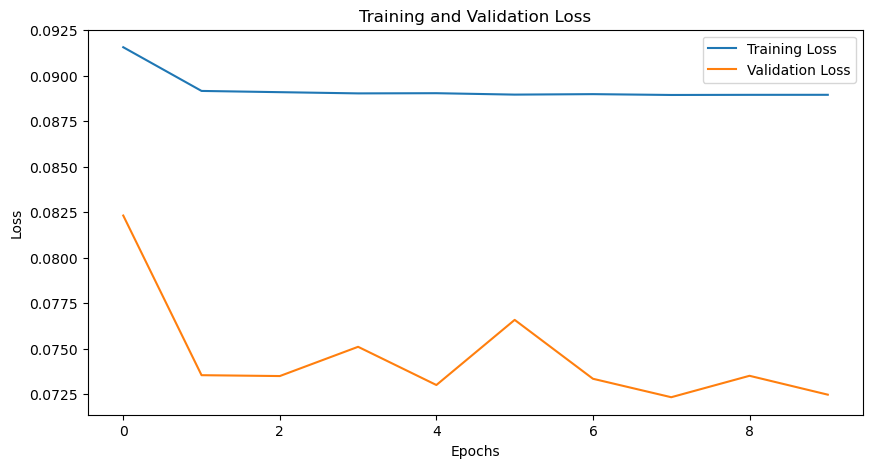

In [27]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding


# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [28]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [29]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [30]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.70700978e-02, -6.43775538e-02, -8.40254128e-03,  2.50011440e-02,
         -3.12255276e-03, -9.71500110e-03, -7.71201998e-02, -1.02632167e-02,
          2.17697937e-02,  1.44426050e-02, -1.50586013e-02,  1.28879528e-02,
          1.30312378e-02,  7.03353807e-02, -9.29138344e-03,  1.31744742e-01,
         -2.14138366e-02,  7.05869356e-03,  2.08555069e-02, -2.54420321e-02,
         -2.87152757e-03,  3.54975485e-03,  8.84628389e-03,  3.74198318e-01,
          4.89792600e-03,  2.15039067e-02,  5.88734411e-02,  3.01029924e-02,
          3.55822109e-02,  8.58693942e-02, -9.30715725e-03,  5.11734039e-02,
          5.95531706e-03,  6.09969981e-02, -2.36076675e-02,  3.09775800e-01,
          6.02180138e-02, -2.45847702e+00,  4.69063595e-02,  4.40035760e-02,
         -1.63575616e-02, -2.05594048e-01,  2.85502195e-01, -6.24550022e-02,
          2.61247611e+00, -5.94890527e-02,  2.10909173e-02,  6.36959216e-03,
          6.82456344e-02,  9.62147936e-02, -3.74289602e-03, -1.43

#### Cosine Similarity Matrix

In [31]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       ...,
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002]], dtype=float32)

#### Model Features Check

In [31]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ...,  0.0000e+00,
           0.0000e+00,  4.0000e+00],
         [ 5.4969e-03, -2.6340e-03, -2.7040e-03,  ...,  0.0000e+00,
           0.0000e+00,  5.0000e+00],
         [-5.3141e-03, -2.4190e-03, -1.9280e-03,  ...,  0.0000e+00,
           0.0000e+00,  6.0000e+00]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 5

In [32]:
batch["features"].shape

torch.Size([32, 7, 560])

In [33]:
batch["target"].shape

torch.Size([32, 11])

In [34]:
len(batch["permno_id"])

32

In [43]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ...,  0.0000e+00,
           0.0000e+00,  4.0000e+00],
         [ 5.4969e-03, -2.6340e-03, -2.7040e-03,  ...,  0.0000e+00,
           0.0000e+00,  5.0000e+00],
         [-5.3141e-03, -2.4190e-03, -1.9280e-03,  ...,  0.0000e+00,
           0.0000e+00,  6.0000e+00]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 5.4969e-03, -2

In [36]:
model(batch["features"].to(device))

(tensor([[-0.0020,  0.0011,  0.0152,  0.0886,  0.0010,  0.0330,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1888],
         [-0.0020,  0.0010,  0.0151,  0.0885,  0.0010,  0.0329,  0.0020,  0.0259,
           0.1798,  0.1914,  0.1887],
         [-0.0020,  0.0010,  0.0152,  0.0886,  0.0009,  0.0330,  0.0021,  0.0259,
           0.1798,  0.1915,  0.1887],
         [-0.0019,  0.0011,  0.0151,  0.0887,  0.0009,  0.0331,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1888],
         [-0.0020,  0.0010,  0.0152,  0.0886,  0.0008,  0.0330,  0.0021,  0.0260,
           0.1798,  0.1915,  0.1888],
         [-0.0019,  0.0011,  0.0151,  0.0887,  0.0009,  0.0330,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1888],
         [-0.0019,  0.0011,  0.0151,  0.0886,  0.0009,  0.0330,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1887],
         [-0.0020,  0.0010,  0.0151,  0.0885,  0.0009,  0.0330,  0.0020,  0.0260,
           0.1798,  0.1914,  0.1886],
         [-0.0019,  0.0010,  0.0151,  0.

In [37]:
train_dataset.sequences[-5:]

[(array([[-1.96385808e-02, -2.22870000e-02, -3.19420000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.90169919e-03,  1.29550000e-02,  7.79200000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
         [ 1.24027667e-02,  2.23980000e-02,  3.01470000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  2.00000000e+00],
         ...,
         [-1.91282829e-03, -1.32400000e-02, -3.54850000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  4.00000000e+00],
         [ 1.45081680e-01,  1.42930000e-02, -3.86700000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  5.00000000e+00],
         [-1.70993644e-02, -7.50000000e-03, -6.12600000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  6.00000000e+00]]),
  array([-0.00996145,  0.00996145, -0.42433243,  0.42433243, -0.13991876,
          0.13991876, -0.06378652,  0.06378652,  0.55133603,  0.40099837,
          0.31851795]),
  '10104'),
 (array([[ 7.90169919e-03,  1.29

In [38]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 1-old: Model-Baseline (3 features and 1 target)
Features:  
'log_return'  
'postional encoding'  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Label:
'log_return' 

#### Create Dataset

In [24]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.concatenate([X, permno_id_one_hot[i]])  # Concatenate one-hot encoded permno_id
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [99]:
# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"][:20000]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"][:20000]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

In [100]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a dimension for sequence length (seq_len=1)
        x = self.transformer(x)
        embedding = x[:, -1, :]
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x.squeeze(-1), embedding

Starting Training...
Epoch 1/10, Training Loss: 0.02464975892855406, Validation Loss: 0.016168133197528013
Epoch 2/10, Training Loss: 0.015802889032359612, Validation Loss: 0.016141946789509844
Epoch 3/10, Training Loss: 0.014901299695057971, Validation Loss: 0.015702074632610915
Epoch 4/10, Training Loss: 0.014400017524683176, Validation Loss: 0.014288059219647691
Epoch 5/10, Training Loss: 0.014057001866453747, Validation Loss: 0.01351682940884581
Epoch 6/10, Training Loss: 0.01378762764986638, Validation Loss: 0.012929118716351266
Epoch 7/10, Training Loss: 0.013661864966060465, Validation Loss: 0.013018904355758766
Epoch 8/10, Training Loss: 0.013564022219049305, Validation Loss: 0.013016177634796443
Epoch 9/10, Training Loss: 0.01350862458281393, Validation Loss: 0.01295208973142336
Epoch 10/10, Training Loss: 0.013440647670377172, Validation Loss: 0.012894980388008199
Training Complete


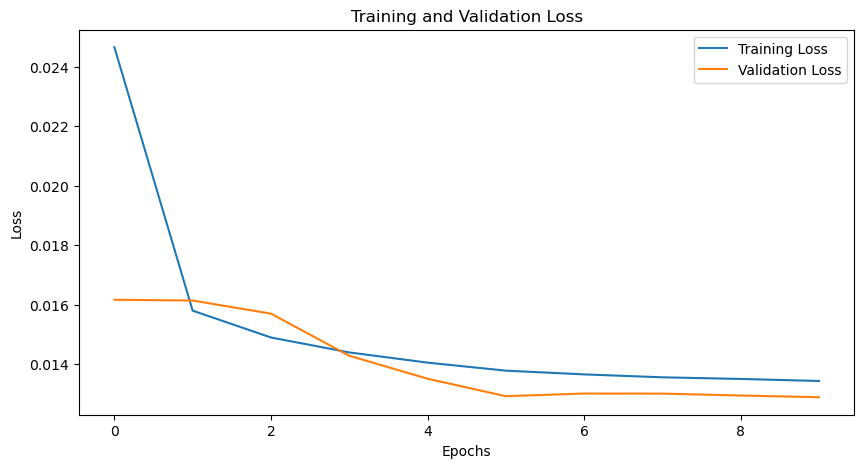

In [101]:
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = (128 * len(train_dataset.input_columns) + 1) + len(one_hot_encoder.categories_[0])
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [106]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [107]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [108]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ -4.3767214 ,  14.636883  , -10.055592  , -17.184486  ,
          12.779612  ,  18.795858  ,  -9.638161  , -16.849627  ,
          12.37308   ,  23.82522   ,  18.170925  ,  -3.7599223 ,
         -10.9022455 ,  -4.0993266 ,   7.4138145 ,  -5.139669  ,
          20.701363  ,  18.141117  ,  -9.857887  ,  -8.52524   ,
          24.640705  , -25.50016   ,  -8.3154545 ,  10.254896  ,
          21.660477  ,  12.833984  ,   3.3258986 ,  11.894244  ,
         -11.285699  , -23.227407  ,  12.576371  ,  -4.3835297 ,
          -5.974343  ,  -0.5579752 ,   7.2592387 ,  14.098306  ,
          -5.506613  ,  11.127786  , -14.507936  ,  -5.0083437 ,
          -1.4023945 , -19.955734  ,  25.78464   , -22.400215  ,
          24.69616   ,  14.438254  ,  -3.11553   ,  12.881308  ,
         -23.141258  , -21.589685  ,  -0.2381519 ,  10.360712  ,
          21.921164  , -22.078854  ,  -9.018872  ,  -8.801734  ,
          13.660214  ,  14.30209   ,  17.573559  , -22.314953  ,
           0.5

#### Cosine Similarity Matrix

In [109]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[0.9999998 , 0.9999981 , 0.9999983 , 0.99999833, 0.99999815,
        0.9999984 , 0.9999975 , 0.9999981 , 0.9999983 , 0.99999803,
        0.99999046, 0.9999985 , 0.9999979 , 0.9999978 , 0.9999981 ,
        0.9999979 , 0.9999968 ],
       [0.9999981 , 1.0000001 , 0.9999978 , 0.99999815, 0.99999815,
        0.9999977 , 0.9999975 , 0.9999977 , 0.9999975 , 0.99999845,
        0.9999902 , 0.99999803, 0.99999744, 0.99999785, 0.9999981 ,
        0.9999977 , 0.9999967 ],
       [0.9999983 , 0.9999978 , 0.9999999 , 0.9999978 , 0.99999785,
        0.9999978 , 0.9999975 , 0.99999845, 0.9999983 , 0.99999815,
        0.9999906 , 0.9999976 , 0.99999815, 0.99999785, 0.9999978 ,
        0.9999977 , 0.99999654],
       [0.99999833, 0.99999815, 0.9999978 , 0.9999999 , 0.999998  ,
        0.99999774, 0.9999977 , 0.99999785, 0.99999803, 0.9999981 ,
        0.9999901 , 0.9999982 , 0.99999803, 0.999998  , 0.9999977 ,
        0.99999744, 0.99999696],
       [0.99999815, 0.99999815, 0.99999785, 0.999998

#### Model Features Check

In [47]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  2.2897e-02,  9.8028e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2800e+02],
        [ 2.2897e-02,  9.8028e-03,  6.0010e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2900e+02],
        [ 9.8028e-03,  6.0010e-03,  1.0467e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.3000e+02],
        ...,
        [ 7.0362e-03,  1.9605e-02,  2.3780e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5700e+02],
        [ 1.9605e-02,  2.3780e-02,  1.3810e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.5800e+02],
        [ 2.3780e-02,  1.3810e-03, -1.6302e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5900e+02]]), 'target': tensor([[ 0.0129],
        [ 0.0157],
        [ 0.0055],
        [ 0.0137],
        [ 0.0106],
        [ 0.0099],
        [ 0.0004],
        [ 0.0090],
        [-0.0053],
        [-0.0041],
        [ 0.0017],
        [ 0.0031],
        [ 0.0000],
        [ 0.0057],
        [-0.0016],
        [-0.0049],
        [-0.0187],
        [-0.0010],
  

In [34]:
batch["features"].shape

torch.Size([32, 683])

In [35]:
batch["target"].shape

torch.Size([32, 1])

In [36]:
len(batch["permno_id"])

32

In [48]:
batch["features"][:5]

tensor([[-1.3843e-02,  2.2897e-02,  9.8028e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2800e+02],
        [ 2.2897e-02,  9.8028e-03,  6.0010e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2900e+02],
        [ 9.8028e-03,  6.0010e-03,  1.0467e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.3000e+02],
        [ 6.0010e-03,  1.0467e-02,  5.4969e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.3100e+02],
        [ 1.0467e-02,  5.4969e-03, -5.3141e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.3200e+02]])

In [38]:
model(batch["features"].to(device))

(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([[-0.3373, -0.4735,  1.6776,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         ...,
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435]],
        device='cuda:0', grad_fn=<SliceBackward0>))

In [41]:
train_dataset.sequences[-5:]

[(array([-4.31529752e-03,  4.42551345e-02, -3.20713737e-03, -5.13396112e-02,
         -1.80998179e-02, -1.77353456e-02,  1.23523941e-02,  2.52154027e-02,
         -5.73742761e-03,  5.38051869e-02,  2.51169128e-02, -6.77222505e-02,
         -5.44881788e-03,  1.68895649e-02,  5.35762228e-03,  7.33006928e-03,
          1.99700466e-03,  2.05053215e-02,  7.99098685e-03,  9.33127317e-02,
          1.97305225e-03, -1.40938534e-02, -3.63154974e-02,  5.98290113e-02,
          2.18828151e-02,  5.62385464e-02,  4.25909288e-04,  1.10724733e-02,
          2.24031645e-02,  4.01492937e-03, -6.86033045e-02,  7.78859003e-03,
         -2.47159379e-02,  3.81682364e-02, -2.65996548e-02,  4.56901259e-02,
          3.04942869e-02, -8.95194940e-03, -8.40724203e-03, -3.71288423e-03,
         -2.06946650e-02, -2.30271003e-02,  2.23073310e-02,  2.16764895e-03,
         -3.46198576e-03, -2.73228937e-02, -1.14159143e-02, -2.53157567e-02,
         -7.55446324e-03,  5.60824436e-03, -2.53957597e-02,  1.54608625e-02,

In [40]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 2-old: Model (7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"  

#### Create Dataset

In [49]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.concatenate([X, permno_id_one_hot[i]])  # Concatenate one-hot encoded permno_id
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [50]:
# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

In [51]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        embedding = x[:, -1, :]
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x.squeeze(-1), embedding

Starting Training...
Epoch 1/10, Training Loss: 0.09393594993297916, Validation Loss: 0.07873438894890245
Epoch 2/10, Training Loss: 0.09117041960287199, Validation Loss: 0.07355478685998026
Epoch 3/10, Training Loss: 0.09114890185280168, Validation Loss: 0.0747607945051089
Epoch 4/10, Training Loss: 0.0910783144283853, Validation Loss: 0.07420810096631177
Epoch 5/10, Training Loss: 0.09105398065409864, Validation Loss: 0.07397140378747052
Epoch 6/10, Training Loss: 0.09105769559242263, Validation Loss: 0.07337269635943011
Epoch 7/10, Training Loss: 0.09099031555486183, Validation Loss: 0.07486673203627847
Epoch 8/10, Training Loss: 0.09095634965778672, Validation Loss: 0.07455270071151213
Epoch 9/10, Training Loss: 0.09098481258619906, Validation Loss: 0.07395662671689975
Epoch 10/10, Training Loss: 0.09096872223133336, Validation Loss: 0.07394769659679928
Training Complete


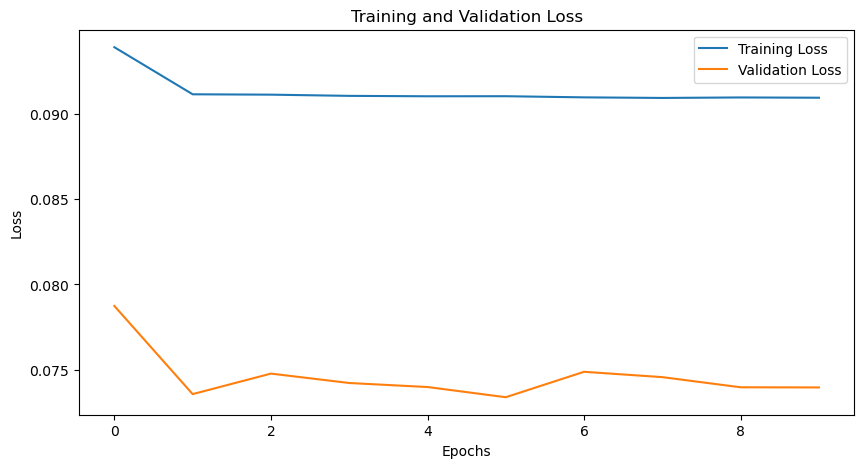

In [52]:
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = (128 * len(train_dataset.input_columns) + 1) + len(one_hot_encoder.categories_[0])
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [53]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [54]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [55]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-3.21087278e-02,  2.74276696e-02,  3.61454524e-02, -3.78264710e-02,
          6.79169074e-02,  8.48998785e-01, -1.00488842e-01,  6.98425546e-02,
          2.83112600e-02,  3.83709073e+00, -3.88179016e+00,  3.66215849e+00,
         -1.07933171e-01,  4.12893035e-02,  2.42160350e-01, -1.63294300e-01,
         -1.16950311e-01,  6.28130138e-02,  2.52505004e-01,  1.36956596e-03,
          1.12524144e-01, -2.17819229e-01, -1.35442197e-01, -2.76513624e+00,
          3.51662338e-02, -2.25921422e-01,  1.03505496e-02, -1.18311441e+00,
         -7.13679492e-01, -9.65118781e-02,  6.36596158e-02,  3.31135958e-01,
         -1.30289626e+00,  1.06567368e-01,  4.94723409e-01,  3.32910490e+00,
         -2.12388597e-02,  4.63916212e-02, -8.97697434e-02, -3.00726108e-02,
         -2.99734492e-02, -4.49500650e-01, -4.50171717e-02,  1.75523028e-01,
         -7.69348219e-02, -1.08703144e-01, -2.57064519e-03,  7.38984942e-02,
         -9.46656466e-02,  1.07675530e-01, -7.48924613e-02,  1.87

#### Cosine Similarity Matrix

In [56]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.99999964, 0.99999964, 0.99999964, ..., 0.99999964, 0.99999964,
        0.99999964],
       ...,
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ]], dtype=float32)

#### Model Features Check

In [58]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.2800e+02],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2900e+02],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  1.3000e+02],
        ...,
        [ 7.0362e-03,  3.6530e-03,  8.6740e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.5700e+02],
        [ 1.9605e-02,  1.4844e-02,  1.8032e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5800e+02],
        [ 2.3780e-02,  1.5021e-02,  1.4210e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5900e+02]]), 'target': tensor([[ 1.2909e-02,  1.2909e-02,  3.9730e-01,  3.9730e-01,  8.6375e-02,
          8.6375e-02,  1.3961e-02,  1.3961e-02,  8.1100e-02,  1.0398e-01,
          1.2514e-01],
        [ 1.5745e-02,  1.5745e-02,  2.5376e-01,  2.5376e-01,  5.7886e-02,
          5.7886e-02,  1.0602e-02,  1.0602e-02,  1.0557e-01,  9.7839e-02,
          1.1782e-01],
  

In [60]:
batch["features"].shape

torch.Size([32, 1195])

In [61]:
batch["target"].shape

torch.Size([32, 11])

In [62]:
len(batch["permno_id"])

32

In [63]:
batch["features"][-5:]

tensor([[1.8823e-02, 1.8124e-02, 7.9020e-03,  ..., 0.0000e+00, 0.0000e+00,
         1.5500e+02],
        [8.7615e-03, 1.0396e-02, 1.3367e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5600e+02],
        [7.0362e-03, 3.6530e-03, 8.6740e-03,  ..., 0.0000e+00, 0.0000e+00,
         1.5700e+02],
        [1.9605e-02, 1.4844e-02, 1.8032e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5800e+02],
        [2.3780e-02, 1.5021e-02, 1.4210e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5900e+02]])

In [64]:
model(batch["features"].to(device))

(tensor([[0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0

In [67]:
train_dataset.sequences[:5]

[(array([-1.38433789e-02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.28000000e+02]),
  array([0.01290932, 0.01290932, 0.39730038, 0.39730038, 0.08637513,
         0.08637513, 0.01396138, 0.01396138, 0.0810996 , 0.10398003,
         0.12514123]),
  '10104'),
 (array([2.28968548e-02, 6.40400000e-03, 4.87200000e-03, ...,
         0.00000000e+00, 0.00000000e+00, 1.29000000e+02]),
  array([0.01574539, 0.01574539, 0.25376155, 0.25376155, 0.05788625,
         0.05788625, 0.01060184, 0.01060184, 0.10557144, 0.09783896,
         0.11782198]),
  '10104'),
 (array([9.80279522e-03, 4.04800000e-03, 9.60000000e-04, ...,
         0.00000000e+00, 0.00000000e+00, 1.30000000e+02]),
  array([0.00554858, 0.00554858, 0.19294101, 0.19294101, 0.02543948,
         0.02543948, 0.01055047, 0.01055047, 0.12290888, 0.13365579,
         0.1177681 ]),
  '10104'),
 (array([6.00095818e-03, 9.58100000e-03, 6.72200000e-03, ...,
         0.00000000e+00, 0.00000000e+00, 1.3100000

## Clustering the Stocks

#### K-means & squared Euclidean distances

Cluster 0: ['10107', '10516', '11308', '11403', '11404', '11600', '11762', '11891', '11955', '12345', '12449', '12490', '12558', '13210', '13379', '13407', '13628', '13788', '13963', '13964', '14541', '14702', '14763', '14776', '15291', '15408', '15720', '15998', '16000', '16851', '16968', '17005', '17144', '17478', '17750', '18163', '21178', '21186', '21792', '21936', '23660', '23931', '24010', '24205', '24643', '25081', '25320', '25419', '25582', '25953', '27633', '28484', '29946', '30681', '35044', '36003', '39917', '40272', '40539', '41080', '41355', '43350', '43449', '45751', '46674', '46886', '50876', '52038', '56274', '58683', '59176', '59300', '59328', '60206', '60506', '61241', '61735', '64186', '64282', '64311', '64936', '64995', '65541', '66093', '66181', '69032', '72726', '75591', '75607', '75825', '76076', '76082', '76709', '76744', '76841', '77037', '77129', '77182', '77649', '77661', '78981', '78987', '79637', '79881', '80080', '80100', '80286', '80329', '81540', '81696'

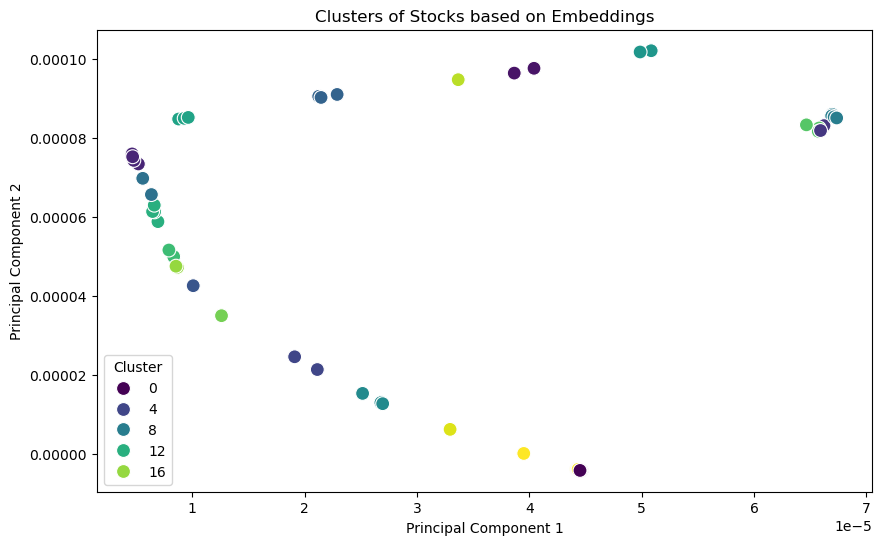

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-means clustering
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Create a dataframe to store permno_id and their corresponding cluster

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Print permno_id in each cluster
for cluster in range(n_clusters):
    cluster_members = cluster_df[cluster_df["cluster"] == cluster]["permno_id"].tolist()
    print(f"Cluster {cluster}: {cluster_members}")

# Plot the clusters using PCA for dimensionality reduction

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
    s=100,
)
plt.title("Clusters of Stocks based on Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & AgglomerativeClustering

- In this approach, you directly apply Agglomerative Clustering to the original embeddings.
- The metric='cosine' parameter tells the algorithm to use cosine distance (1 - cosine similarity) as the metric for clustering.
- The linkage='average' parameter specifies that the distance between clusters is the average distance between points in the clusters.

Cluster 0: ['20057', '20189']
Cluster 1: ['17334', '19285', '19286']
Cluster 2: ['18484', '18576']
Cluster 3: ['17685', '17700', '82686']
Cluster 4: ['18312', '76201', '79996', '82759']
Cluster 5: ['22623', '77668']
Cluster 6: ['18911', '18940', '79265']
Cluster 7: ['11896', '18592', '18724', '18726']
Cluster 8: ['12650', '18420', '18421', '18428']
Cluster 9: ['22206', '22265', '90441', '90442']
Cluster 10: ['88436']
Cluster 11: ['10909']
Cluster 12: ['19751']
Cluster 13: ['11552', '91063']
Cluster 14: ['17341']
Cluster 15: ['22976', '25778', '89757']
Cluster 16: ['18143']
Cluster 17: ['17307']
Cluster 18: ['10104', '10107', '10138', '10145', '10516', '10696', '11308', '11403', '11404', '11600', '11618', '11674', '11691', '11762', '11850', '11891', '11955', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12476', '12490', '12558', '12622', '12623', '12872', '13035', '13103', '13168', '13210', '13323', '13356', '13379', '13407', '13447', '13511'

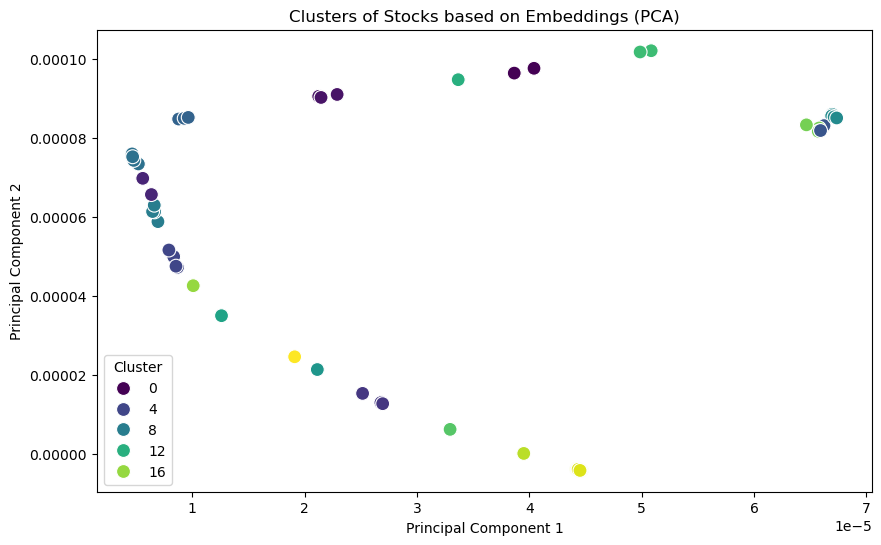

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings = np.array(list(stock_embeddings.values()))

# Perform Agglomerative Clustering with cosine affinity
n_clusters = 20
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric="cosine", linkage="average")
labels = clustering.fit_predict(embeddings)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(stock_embeddings.keys(), labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(stock_embeddings.keys()):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & Cosine Similarity
1. Cosine Similarity Transformation:  
    - Here, you first compute the cosine similarity matrix from the embeddings.
    - This matrix represents the cosine similarity between each pair of embeddings.
    - The similarity matrix is then used as the input to the KMeans clustering algorithm.  
2. KMeans Clustering:
    - KMeans is applied to the cosine similarity matrix, treating each similarity score as a feature.
    - This approach uses the similarity scores rather than the original embeddings to determine the clusters.

Cluster 0: ['61516', '61621', '61735', '62092', '62148', '62308', '62498', '63467', '64186', '64282', '64311', '64390', '64653', '64936', '64995', '65402', '65541', '65875', '65947', '66093', '66157', '66181', '66384', '66800', '67598', '69032', '69649', '69796', '70519', '70578', '71563', '72726', '73139', '75034', '75186', '75241', '75510', '75591', '75607', '75694', '75819', '75825', '75828', '75912', '76076', '76082', '76095', '76185', '76226', '76230', '76605', '76614', '76709', '76712', '76744', '76795', '76841', '77037', '77129', '77178', '77182', '77274', '77338', '77357', '77496', '77605', '77649', '77661', '77702', '77730', '78034', '78975', '78981', '78987', '79057', '79089', '79103', '79145', '79323', '79545', '79637', '79678', '79698', '79782', '79785', '79881', '79906', '80080', '80100', '80183', '80191', '80204', '80286', '80320', '80329', '80381', '80681', '80924', '81045', '81055', '81061', '81472', '81481', '81540', '81655', '81677', '81696', '81736', '81774', '82276'

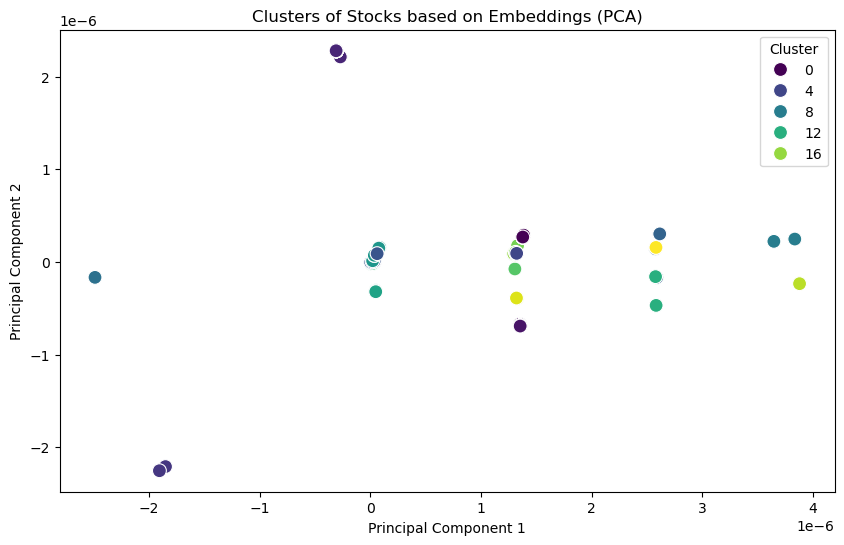

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### Difference - AgglomerativeClustering and Cosine Similarity

Approach 1: Transforming Embeddings using Cosine Similarity and then Applying KMeans  
Approach 2: Agglomerative Clustering with Cosine Affinity  

1. Cosine Similarity Matrix vs. Original Embeddings:
    - Approach 1: Uses the cosine similarity matrix as the input for clustering. This means the clustering is based on the similarity scores between embeddings.  
    - Approach 2: Uses the original embeddings directly with cosine distance as the metric. The clustering is based on the pairwise cosine distances between embeddings.  
2. Clustering Algorithm:
    - Approach 1: Uses KMeans, which is a centroid-based algorithm. It aims to partition the data into clusters such that the sum of the squared distances from each point to its assigned centroid is minimized.  
    - Approach 2: Uses Agglomerative Clustering, which is a hierarchical clustering method. It builds a tree-like structure of clusters by merging pairs of clusters iteratively based on the specified linkage criterion and distance metric.  
3. Distance Metric Usage:  
    - Approach 1: Cosine similarity is precomputed and used as the input for clustering.  
    - Approach 2: Cosine distance is used directly within the clustering algorithm.|

#### Cosine Similarity Matrix

In [55]:
cosine_sim_matrix

array([[0.99999994, 0.99999994, 0.99999994, ..., 1.0000002 , 1.0000002 ,
        0.99999994],
       [0.99999994, 0.99999994, 0.99999994, ..., 1.0000002 , 1.0000002 ,
        0.99999994],
       [0.99999994, 0.99999994, 0.99999994, ..., 1.0000002 , 1.0000002 ,
        0.99999994],
       ...,
       [1.0000002 , 1.0000002 , 1.0000002 , ..., 0.99999994, 0.99999994,
        0.99999994],
       [1.0000002 , 1.0000002 , 1.0000002 , ..., 0.99999994, 0.99999994,
        0.99999994],
       [0.99999994, 0.99999994, 0.99999994, ..., 0.99999994, 0.99999994,
        0.99999994]], dtype=float32)

#### check negative value in cosine_sim_matrix

In [56]:
# Check for negative values in the cosine similarity matrix
negative_values = cosine_sim_matrix[cosine_sim_matrix < 0]

if len(negative_values) > 0:
    print(f"There are {len(negative_values)} negative values in the cosine similarity matrix.")
    print(negative_values)
else:
    print("There are no negative values in the cosine similarity matrix.")

There are no negative values in the cosine similarity matrix.


In [57]:
# Find the maximum value in the cosine similarity matrix
max_value = np.max(cosine_sim_matrix)
print(f"Max value: {max_value}")

# Find the minimum value in the cosine similarity matrix
min_value = np.min(cosine_sim_matrix)
print(f"Min value: {min_value}")

Max value: 1.000000238418579
Min value: 0.9999996423721313


Sample embeddings:
[[-0.10113669 -0.13117969  4.643764   -0.09728476 -0.13188404 -0.11414704
  -0.10199591 -0.09753642  5.2008724  -0.13804568 -0.10543156 -0.12181271
  -0.11092354 -0.10593085 -0.10379755 -0.12611543 -0.13012108 -0.10574751
  -0.10132074 -0.09109034 -0.1217372  -0.10508449 -0.12317963 -0.11023221
  -0.12776662 -0.10637771 -0.11569362 -0.1243245  -0.12921163 -0.12488127
  -0.13221206 -0.12708518 -0.34985635 -0.12901476 -0.12900788 -0.10293555
  -0.10689097 -0.12761888 -0.1141796  -0.13812514 -0.13206193 -0.10620784
  -0.13905913  0.5077686  -0.11439564 -0.10097685 -0.10466886 -0.14279886
  -0.11103318 -0.12519583 -0.12899232 -0.09925667 -0.12949999 -0.1302237
  -0.0958822  -0.11069038 -0.12490238 -0.13115653 -0.13030057 -0.10379748
  -0.099494   -0.12419097 -0.12821966 -3.0186055 ]
 [-0.10118653 -0.13112779  4.6437497  -0.09723199 -0.13183765 -0.11420897
  -0.10202868 -0.09758627  5.200917   -0.1380884  -0.10544573 -0.12179092
  -0.11095989 -0.10586552 -0.10382174 -0.12

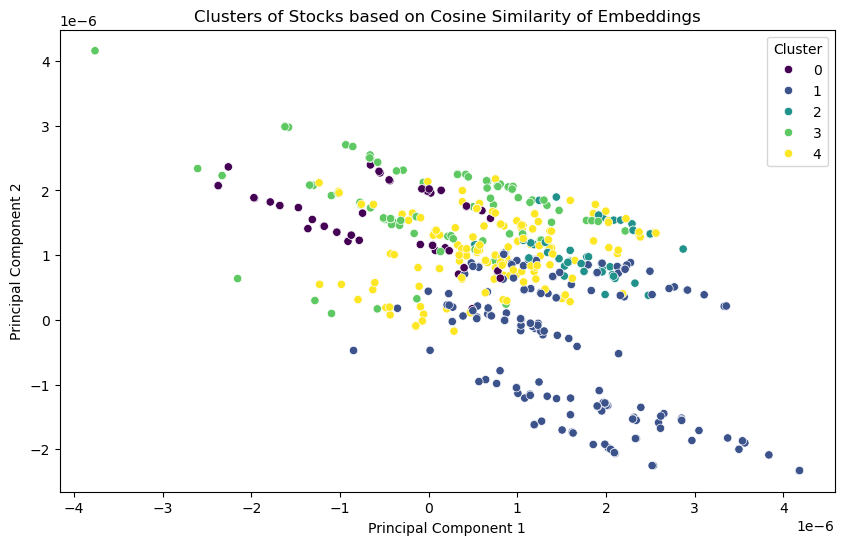

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Check the embeddings to ensure they have diverse values
print("Sample embeddings:")
print(embeddings_array[:5])

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Check if there are any negative values in the cosine similarity matrix
print("Cosine Similarity Matrix Sample:")
print(cosine_sim_matrix[:5, :5])

# Ensure there are negative values
if np.any(cosine_sim_matrix < 0):
    print("Cosine similarity matrix contains negative values.")
else:
    print("Cosine similarity matrix does not contain negative values.")

# Perform K-means clustering
n_clusters = 5  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cosine_sim_matrix)

# Create a dataframe to store permno_id and their corresponding cluster
import pandas as pd

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Plot the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
)
plt.title("Clusters of Stocks based on Cosine Similarity of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## Clustering Stocks Return

In [51]:
list(permno_id_to_cluster.items())[:10]

[('10104', 14),
 ('10107', 1),
 ('10138', 6),
 ('10145', 1),
 ('10516', 6),
 ('10696', 1),
 ('10909', 9),
 ('11308', 1),
 ('11403', 11),
 ('11404', 1)]

In [52]:
df_clustering = df

# Add cluster_id to the original data
df_clustering["cluster_id"] = df_clustering["permno_id"].map(permno_id_to_cluster)
df_clustering

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7658917 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7658918 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7658919 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7658920 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7658921 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  ...  \
9263                  1                 1             1  ORACLE CORP  ...   
9264                  1                 1             1  ORACLE CORP  ...   
9265                  1                 1             1  ORACLE CORP  ...   
9266                  1                 1             1  ORACLE CORP  ...   
9267                  1                 1             1  ORACLE CORP  ...   
...                 ...               ...           ...          ...  ...   
7658917               1                 1             3    TESLA INC  ...   
7658918               1                 1             3    TESLA INC  ...   
7658919               1                 1             3    TESLA INC  ...   
7658920               1                 1             3    TESLA INC  ...   
7658921               1                 1             3    TESLA INC  ...   

        equal_weighted_return return_on_SP_index log_return    market_cap  \
9263                 0.011232           0.008303  -0.013843  1.930296e+08   
9264                 0.005103           0.006399   0.022897  1.975004e+08   
9265                 0.005272           0.004029   0.009803  1.994460e+08   
9266                 0.003880           0.007034   0.006001  2.006465e+08   
9267                 0.000584           0.001662   0.010467  2.027577e+08   
...                       ...                ...        ...           ...   
7658917              0.007676           0.001660  -0.007731  8.028047e+08   
7658918              0.009674           0.004232   0.015988  8.157429e+08   
7658919              0.005276           0.001430   0.018647  8.310971e+08   
7658920              0.002042           0.000370  -0.032104  8.048392e+08   
7658921             -0.007480          -0.002826  -0.018738  7.898983e+08   

        weighted_price sector_weighted_avg_log_return  \
9263      9.000972e+09                       0.000000   
9264      9.422745e+09                       0.021973   
9265      9.609309e+09                       0.002940   
9266      9.725336e+09                       0.015718   
9267      9.931072e+09                       0.006267   
...                ...                            ...   
7658917   2.027403e+11                      -0.001753   
7658918   2.093278e+11                       0.006185   
7658919   2.172820e+11                       0.003881   
7658920   2.037692e+11                      -0.002012   
7658921   1.962739e+11                      -0.002658   

         sector_simple_avg_log_return  weighted_avg_log_return  \
9263                         0.000000                     -0.0   
9264                         0.005694                      0.0   
9265                         0.001681                      0.0   
9266                         0.004005                      0.0   
9267                         0.009789                      0.0   
...                               ...                      ...   
7658917                      0.016253                     -0.0   
7658918                      0.001010                      0.0   
7658919                      0.001242       

#### 1. Calculate the log returns of the clustering corresponding to each stock, calculated using the weighted average stock prices in the clustering

In [53]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"]).agg({"weighted_price": "sum", "market_cap": "sum"}).reset_index()
)

# Then, calculate the weighted average price
grouped["weighted_avg_price"] = grouped["weighted_price"] / grouped["market_cap"]

# Then, calculate the log return for each cluster_id
grouped["weighted_avg_price_shifted"] = grouped.groupby("cluster_id")["weighted_avg_price"].shift(1)
grouped["cluster_weighted_avg_log_return"] = (
    np.log(grouped["weighted_avg_price"] / grouped["weighted_avg_price_shifted"]).fillna(0)
).round(6)

grouped

cluster_id       date  weighted_price    market_cap  \
0               0 2018-01-02    2.724403e+11  2.031136e+09   
1               0 2018-01-03    2.745722e+11  2.039307e+09   
2               0 2018-01-04    2.759041e+11  2.046690e+09   
3               0 2018-01-05    2.811508e+11  2.065263e+09   
4               0 2018-01-08    2.817589e+11  2.064198e+09   
...           ...        ...             ...           ...   
25417          19 2018-12-17    5.266052e+09  5.449143e+07   
25418          19 2018-12-18    5.092051e+09  5.358362e+07   
25419          19 2018-12-19    5.174904e+09  5.401779e+07   
25420          19 2018-12-20    4.806810e+09  5.206119e+07   
25421          19 2018-12-21    0.000000e+00  0.000000e+00   

       weighted_avg_price  weighted_avg_price_shifted  \
0              134.131957                         NaN   
1              134.639972                  134.131957   
2              134.805061                  134.639972   
3              136.133184                  134.805061   
4              136.497987                  136.133184   
...                   ...                         ...   
25417           96.640000                   98.220000   
25418           95.030000                   96.640000   
25419           95.800000                   95.030000   
25420           92.330000                   95.800000   
25421                 NaN                   92.330000   

       cluster_weighted_avg_log_return  
0                             0.000000  
1                             0.003780  
2                             0.001225  
3                             0.009804  
4                             0.002676  
...                                ...  
25417                        -0.016217  
25418                        -0.016800  
25419                         0.008070  
25420                        -0.036894  
25421                         0.000000  

[25422 rows x 7 columns]

In [54]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_weighted_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... return_on_SP_index  \
0                 1             1  ORACLE CORP  ...           0.008303   
1                 1             1  ORACLE CORP  ...           0.006399   
2                 1             1  ORACLE CORP  ...           0.004029   
3                 1             1  ORACLE CORP  ...           0.007034   
4                 1             1  ORACLE CORP  ...           0.001662   

  log_return    market_cap weighted_price sector_weighted_avg_log_return  \
0  -0.013843  1.930296e+08   9.000972e+09                       0.000000   
1   0.022897  1.975004e+08   9.422745e+09                       0.021973   
2   0.009803  1.994460e+08   9.609309e+09                       0.002940   
3   0.006001  2.006465e+08   9.725336e+09                       0.015718   
4   0.010467  2.027577e+08   9.931072e+09                       0.006267   

  sector_simple_avg_log_return  weighted_avg_log_return  \
0                     0.000000                     -0.0   
1                     0.005694                      0.0   
2                     0.001681                      0.0   
3                     0.004005                      0.0   
4                     0.009789                      0.0   

   simple_avg_log_return  cluster_id  cluster_weighted_avg_log_return  
0               -0.00064          14                         0.000000  
1               -0.00064          14                         0.021764  
2               -0.00064          14                         0.002430  
3               -0.00064          14                         0.016969  
4               -0.00064          14                         0.005760  

[5 rows x 40 columns]

In [55]:
df_clustering["cluster_weighted_avg_log_return"]

0         0.000000
1         0.021764
2         0.002430
3         0.016969
4         0.005760
            ...   
809878    0.002708
809879    0.008723
809880    0.009865
809881   -0.016219
809882   -0.008694
Name: cluster_weighted_avg_log_return, Length: 809883, dtype: float64

#### 2. Calculate the log returns of the clustering corresponding to each stock, calculated using the arithmetic average stock prices in the clustering

In [56]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"])
    .agg({"close_price": "mean"})
    .reset_index()
    .rename(columns={"close_price": "avg_price"})
)

# Then, calculate the log return for each cluster_id
grouped["avg_price_Shifted"] = grouped.groupby("cluster_id")["avg_price"].shift(1)
grouped["cluster_simple_avg_log_return"] = (
    np.log(grouped["avg_price"] / grouped["avg_price_Shifted"]).fillna(0)
).round(6)

grouped

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


cluster_id       date   avg_price  avg_price_Shifted  \
0               0 2018-01-02  108.603125                NaN   
1               0 2018-01-03  109.515313         108.603125   
2               0 2018-01-04  109.613282         109.515313   
3               0 2018-01-05  110.380938         109.613282   
4               0 2018-01-08  111.411250         110.380938   
...           ...        ...         ...                ...   
25417          19 2018-12-17   96.640000          98.220000   
25418          19 2018-12-18   95.030000          96.640000   
25419          19 2018-12-19   95.800000          95.030000   
25420          19 2018-12-20   92.330000          95.800000   
25421          19 2018-12-21    0.000000          92.330000   

       cluster_simple_avg_log_return  
0                           0.000000  
1                           0.008364  
2                           0.000894  
3                           0.006979  
4                           0.009291  
...                              ...  
25417                      -0.016217  
25418                      -0.016800  
25419                       0.008070  
25420                      -0.036894  
25421                           -inf  

[25422 rows x 5 columns]

In [57]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_simple_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... log_return    market_cap  \
0                 1             1  ORACLE CORP  ...  -0.013843  1.930296e+08   
1                 1             1  ORACLE CORP  ...   0.022897  1.975004e+08   
2                 1             1  ORACLE CORP  ...   0.009803  1.994460e+08   
3                 1             1  ORACLE CORP  ...   0.006001  2.006465e+08   
4                 1             1  ORACLE CORP  ...   0.010467  2.027577e+08   

  weighted_price sector_weighted_avg_log_return sector_simple_avg_log_return  \
0   9.000972e+09                       0.000000                     0.000000   
1   9.422745e+09                       0.021973                     0.005694   
2   9.609309e+09                       0.002940                     0.001681   
3   9.725336e+09                       0.015718                     0.004005   
4   9.931072e+09                       0.006267                     0.009789   

  weighted_avg_log_return  simple_avg_log_return  cluster_id  \
0                    -0.0               -0.00064          14   
1                     0.0               -0.00064          14   
2                     0.0               -0.00064          14   
3                     0.0               -0.00064          14   
4                     0.0               -0.00064          14   

   cluster_weighted_avg_log_return  cluster_simple_avg_log_return  
0                         0.000000                       0.000000  
1                         0.021764                       0.012446  
2                         0.002430                       0.005958  
3                         0.016969                       0.007333  
4                         0.005760                       0.001717  

[5 rows x 41 columns]

In [58]:
df_clustering["cluster_simple_avg_log_return"]

0         0.000000
1         0.012446
2         0.005958
3         0.007333
4         0.001717
            ...   
809878    0.012161
809879    0.004755
809880    0.001919
809881    0.000032
809882   -0.003015
Name: cluster_simple_avg_log_return, Length: 809883, dtype: float64

In [59]:
df_clustering.dtypes

date                               datetime64[ns]
permno_id                                  object
ncusip_id                                  object
cusip_id                                   object
ticker                                     object
share_code                                 object
share_code_type                            object
share_code_detail                          object
exchange_code                              object
company_name                               object
primary_exchange                           object
trading_status                             object
security_status                            object
naics                                      object
naics_sector                               object
naics_secondary                            object
ask_or_high_price                         float64
ask_price                                 float64
bid_or_low_price                          float64
bid_price                                 float64


In [60]:
df_clustering

date permno_id ncusip_id  cusip_id ticker share_code  \
0      2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
1      2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
2      2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
3      2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
4      2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...           ...       ...       ...       ...    ...        ...   
809878 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
809879 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
809880 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
809881 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
809882 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

       share_code_type share_code_detail exchange_code company_name  ...  \
0                    1                 1             1  ORACLE CORP  ...   
1                    1                 1             1  ORACLE CORP  ...   
2                    1                 1             1  ORACLE CORP  ...   
3                    1                 1             1  ORACLE CORP  ...   
4                    1                 1             1  ORACLE CORP  ...   
...                ...               ...           ...          ...  ...   
809878               1                 1             3    TESLA INC  ...   
809879               1                 1             3    TESLA INC  ...   
809880               1                 1             3    TESLA INC  ...   
809881               1                 1             3    TESLA INC  ...   
809882               1                 1             3    TESLA INC  ...   

       log_return    market_cap weighted_price sector_weighted_avg_log_return  \
0       -0.013843  1.930296e+08   9.000972e+09                       0.000000   
1        0.022897  1.975004e+08   9.422745e+09                       0.021973   
2        0.009803  1.994460e+08   9.609309e+09                       0.002940   
3        0.006001  2.006465e+08   9.725336e+09                       0.015718   
4        0.010467  2.027577e+08   9.931072e+09                       0.006267   
...           ...           ...            ...                            ...   
809878  -0.007731  8.028047e+08   2.027403e+11                      -0.001753   
809879   0.015988  8.157429e+08   2.093278e+11                       0.006185   
809880   0.018647  8.310971e+08   2.172820e+11                       0.003881   
809881  -0.032104  8.048392e+08   2.037692e+11                      -0.002012   
809882  -0.018738  7.898983e+08   1.962739e+11                      -0.002658   

       sector_simple_avg_log_return weighted_avg_log_return  \
0                          0.000000                    -0.0   
1                          0.005694                     0.0   
2                          0.001681                     0.0   
3                          0.004005                     0.0   
4                          0.009789                     0.0   
...                             ...                     ...   
809878                     0.016253                    -0.0   
809879                     0.001010                     0.0   
809880                     0.001242                     0.0   
809881                     0.004141                    -0.0   
809882                    -0.009349                    -0.0   

        simple_avg_log_return  cluster_id  cluster_weighted_avg_log_return  \
0                    -0.00064          14                         0.000000   
1                    -0.00064          14                         0.021764   
2                    -0.00064          14                         0.002430   
3                    -0.00064          14                         0.016969   
4                    -0.00064          14                         0.005760   
...                       ...         ...                              ..

## Step 3 dataset  
Including stock daily log_returns from most similar and most opposite cosine similarity 

In [61]:
df_clustering = df_clustering[["date", "permno_id", "log_return"]]

In [62]:
df_clustering.dtypes

date          datetime64[ns]
permno_id             object
log_return           float64
dtype: object

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=2):
    # Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
    embeddings_list = []
    permno_ids = []
    n = 2

    for permno_id, embedding in stock_embeddings.items():
        permno_ids.append(permno_id)
        embeddings_list.append(embedding)

    # Convert the list of embeddings to a numpy array
    embeddings_array = np.array(embeddings_list)

    # Transform embeddings using cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_array)

    # Create a DataFrame for cosine similarity matrix for better handling
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=permno_ids, columns=permno_ids)

    base = df_clustering.copy()[["date", "permno_id", "log_return"]]

    # Initialize new columns for most similar and most opposite stocks and their log returns
    for i in range(1, n + 1):
        df_clustering[f"most_similar_{i}"] = np.nan
        # df_clustering[f"most_similar_{i}_log_return"] = np.nan
        df_clustering[f"most_opposite_{i}"] = np.nan
        # df_clustering[f"most_opposite_{i}_log_return"] = np.nan

    # Ensure the new columns are of the same type as 'permno_id'
    df_clustering = df_clustering.astype({f"most_similar_{i}": "object" for i in range(1, n + 1)})
    df_clustering = df_clustering.astype({f"most_opposite_{i}": "object" for i in range(1, n + 1)})

    # Fill new columns with permno_id and log_return of most similar and most opposite stocks
    for permno_id in df_clustering["permno_id"].unique():
        similarities = cosine_sim_df.loc[permno_id]
        sorted_similarities = similarities.sort_values(ascending=False)
        most_similar = sorted_similarities.index[1 : n + 1]  # First n most similar stocks
        most_opposite = sorted_similarities.index[-n:]  # Last n most opposite stocks

        for i in range(n):
            similar_permno_id = most_similar[i]
            opposite_permno_id = most_opposite[i]

            # Set the most similar and most opposite permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_similar_{i+1}"] = similar_permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_opposite_{i+1}"] = opposite_permno_id

    # Merge the similar stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_similar_{i}", "log_return": f"most_similar_{i}_log_return"}),
            on=["date", f"most_similar_{i}"],
            how="left",
        )

    # Merge the opposite stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_opposite_{i}", "log_return": f"most_opposite_{i}_log_return"}),
            on=["date", f"most_opposite_{i}"],
            how="left",
        )

    # for feat in ["most_similar_1", "most_opposite_1", "most_similar_2", "most_opposite_2"]:
    #     df_clustering = df_clustering.merge(base.rename(columns = {"permno_id": f"{feat}", "log_return": f"{feat}_log_return"}), on = ["date", feat], how = "left")

    return df_clustering


# Example usage:
df_clustering = find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=3)
df_clustering

/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_similar_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_opposite_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        NaN   
1               22265           90199                        NaN   
2               22265           90199                        NaN   
3               22265           90199                        NaN   
4               22265           90199                        NaN   
...               ...             ...                        ...   
809878          20189           90199                        NaN   
809879          20189           90199                        NaN   
809880          20189           90199                        NaN   
809881          20189           90199                        NaN   
809882          20189           90199                        NaN   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                             NaN                    0.014639   
1                             NaN                   -0.000692   
2                             NaN                   -0.011493   
3                             NaN                    0.006285   
4                             NaN                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  
0                         0.011707  
1                         0.008409  
2                        -0.003173  
3                         0.004982  
4                         0.012794  
...                            ...  
809878                    0.004796  
809879                    0.007152  
809880                    0.011061  
809881                    0.001920  
809882                   -0.007811  

[809883 rows x 11 columns]

### Check

In [69]:
df_clustering[df_clustering["most_opposite_1"] == "90071"][["date", "permno_id", "most_opposite_1_log_return"]]

date permno_id  most_opposite_1_log_return
0      2018-01-02     10104                    0.014639
1      2018-01-03     10104                   -0.000692
2      2018-01-04     10104                   -0.011493
3      2018-01-05     10104                    0.006285
4      2018-01-08     10104                    0.015199
...           ...       ...                         ...
809878 2023-12-22     93436                   -0.001799
809879 2023-12-26     93436                    0.016070
809880 2023-12-27     93436                    0.008037
809881 2023-12-28     93436                    0.012418
809882 2023-12-29     93436                   -0.003090

[161453 rows x 3 columns]

In [70]:
df_clustering[df_clustering["permno_id"] == "90071"][["date", "permno_id", "log_return"]]

date permno_id  log_return
736355 2018-01-02     90071    0.014639
736356 2018-01-03     90071   -0.000692
736357 2018-01-04     90071   -0.011493
736358 2018-01-05     90071    0.006285
736359 2018-01-08     90071    0.015199
...           ...       ...         ...
737859 2023-12-22     90071   -0.001799
737860 2023-12-26     90071    0.016070
737861 2023-12-27     90071    0.008037
737862 2023-12-28     90071    0.012418
737863 2023-12-29     90071   -0.003090

[1509 rows x 3 columns]

In [71]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                               0
permno_id                          0
log_return                         0
most_similar_1                     0
most_opposite_1                    0
most_similar_2                     0
most_opposite_2                    0
most_similar_1_log_return     510100
most_similar_2_log_return     537686
most_opposite_1_log_return      5155
most_opposite_2_log_return      8086
dtype: int64


In [72]:
any_nans = df_clustering.isna().any()
print(any_nans)

date                          False
permno_id                     False
log_return                    False
most_similar_1                False
most_opposite_1               False
most_similar_2                False
most_opposite_2               False
most_similar_1_log_return      True
most_similar_2_log_return      True
most_opposite_1_log_return     True
most_opposite_2_log_return     True
dtype: bool


In [73]:
any_nans_overall = df_clustering.isna().any().any()
print(f"Are there any NaN values in the DataFrame? {any_nans_overall}")

Are there any NaN values in the DataFrame? True


In [74]:
rows_with_nans = df_clustering[df_clustering.isna().any(axis=1)]
rows_with_nans

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        NaN   
1               22265           90199                        NaN   
2               22265           90199                        NaN   
3               22265           90199                        NaN   
4               22265           90199                        NaN   
...               ...             ...                        ...   
809878          20189           90199                        NaN   
809879          20189           90199                        NaN   
809880          20189           90199                        NaN   
809881          20189           90199                        NaN   
809882          20189           90199                        NaN   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                             NaN                    0.014639   
1                             NaN                   -0.000692   
2                             NaN                   -0.011493   
3                             NaN                    0.006285   
4                             NaN                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  
0                         0.011707  
1                         0.008409  
2                        -0.003173  
3                         0.004982  
4                         0.012794  
...                            ...  
809878                    0.004796  
809879                    0.007152  
809880                    0.011061  
809881                    0.001920  
809882                   -0.007811  

[719229 rows x 11 columns]

### replace NaN with 0 and add new columns to indicate them
1. If there was values in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 1.
2. If there was NaN in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 0.
3. replace the NaN with 0 for the columns "most_similar_log_return" and "most_opposite_log_return"

In [75]:
df_clustering

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        NaN   
1               22265           90199                        NaN   
2               22265           90199                        NaN   
3               22265           90199                        NaN   
4               22265           90199                        NaN   
...               ...             ...                        ...   
809878          20189           90199                        NaN   
809879          20189           90199                        NaN   
809880          20189           90199                        NaN   
809881          20189           90199                        NaN   
809882          20189           90199                        NaN   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                             NaN                    0.014639   
1                             NaN                   -0.000692   
2                             NaN                   -0.011493   
3                             NaN                    0.006285   
4                             NaN                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  
0                         0.011707  
1                         0.008409  
2                        -0.003173  
3                         0.004982  
4                         0.012794  
...                            ...  
809878                    0.004796  
809879                    0.007152  
809880                    0.011061  
809881                    0.001920  
809882                   -0.007811  

[809883 rows x 11 columns]

In [76]:
# Identify the columns that are related to most similar and most opposite log returns
similar_opposite_cols = [
    col for col in df_clustering.columns if "_log_return" in col and ("most_similar" in col or "most_opposite" in col)
]

# Add new columns to indicate if the value was NaN
for col in similar_opposite_cols:
    df_clustering[f"{col}_was_nan"] = np.where(df_clustering[col].isna(), 0, 1)

# Replace NaN values with 0 in the identified columns
df_clustering[similar_opposite_cols] = df_clustering[similar_opposite_cols].fillna(0)

# Example check
df_clustering

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        0.0   
1               22265           90199                        0.0   
2               22265           90199                        0.0   
3               22265           90199                        0.0   
4               22265           90199                        0.0   
...               ...             ...                        ...   
809878          20189           90199                        0.0   
809879          20189           90199                        0.0   
809880          20189           90199                        0.0   
809881          20189           90199                        0.0   
809882          20189           90199                        0.0   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                        0.000000                    0.014639   
1                        0.000000                   -0.000692   
2                        0.000000                   -0.011493   
3                        0.000000                    0.006285   
4                        0.000000                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  most_similar_1_log_return_was_nan  \
0                         0.011707                                  0   
1                         0.008409                                  0   
2                        -0.003173                                  0   
3                         0.004982                                  0   
4                         0.012794                                  0   
...                            ...                                ...   
809878                    0.004796                                  0   
809879                    0.007152                                  0   
809880                    0.011061                                  0   
809881                    0.001920                                  0   
809882                   -0.007811                                  0   

        most_similar_2_log_return_was_nan  most_opposite_1_log_return_was_nan  \
0                                       0                                   1   
1                                       0                                   1   
2                                       0                                   1   
3                                       0                                   1   
4                                       0                                   1   
...                                   ...                                 ...   
809878                                  1                                   1   
8

In [77]:
df_clustering.columns

Index(['date', 'permno_id', 'log_return', 'most_similar_1', 'most_opposite_1',
       'most_similar_2', 'most_opposite_2', 'most_similar_1_log_return',
       'most_similar_2_log_return', 'most_opposite_1_log_return',
       'most_opposite_2_log_return', 'most_similar_1_log_return_was_nan',
       'most_similar_2_log_return_was_nan',
       'most_opposite_1_log_return_was_nan',
       'most_opposite_2_log_return_was_nan'],
      dtype='object')

In [78]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                                  0
permno_id                             0
log_return                            0
most_similar_1                        0
most_opposite_1                       0
most_similar_2                        0
most_opposite_2                       0
most_similar_1_log_return             0
most_similar_2_log_return             0
most_opposite_1_log_return            0
most_opposite_2_log_return            0
most_similar_1_log_return_was_nan     0
most_similar_2_log_return_was_nan     0
most_opposite_1_log_return_was_nan    0
most_opposite_2_log_return_was_nan    0
dtype: int64


## Save the cleaned df as csv & parquet


In [51]:
df_clustering.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.csv",
    index=False,
)
df_clustering.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")

In [52]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... log_return    market_cap  \
0                 1             1  ORACLE CORP  ...  -0.013843  1.930296e+08   
1                 1             1  ORACLE CORP  ...   0.022897  1.975004e+08   
2                 1             1  ORACLE CORP  ...   0.009803  1.994460e+08   
3                 1             1  ORACLE CORP  ...   0.006001  2.006465e+08   
4                 1             1  ORACLE CORP  ...   0.010467  2.027577e+08   

  weighted_price sector_weighted_avg_log_return sector_simple_avg_log_return  \
0   9.000972e+09                       0.000000                     0.000000   
1   9.422745e+09                       0.021973                     0.005694   
2   9.609309e+09                       0.002940                     0.001681   
3   9.725336e+09                       0.015718                     0.004005   
4   9.931072e+09                       0.006267                     0.009789   

  weighted_avg_log_return  simple_avg_log_return  cluster_id  \
0                    -0.0               -0.00064          16   
1                     0.0               -0.00064          16   
2                     0.0               -0.00064          16   
3                     0.0               -0.00064          16   
4                     0.0               -0.00064          16   

   cluster_weighted_avg_log_return  cluster_simple_avg_log_return  
0                         0.000000                       0.000000  
1                         0.010933                       0.009348  
2                        -0.001095                       0.000711  
3                         0.000353                       0.002520  
4                         0.001616                       0.002617  

[5 rows x 41 columns]

## Upload the parquet to s3


In [53]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean_clustering.parquet",
)

In [54]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean_clustering.parquet")

In [55]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... log_return    market_cap  \
0                 1             1  ORACLE CORP  ...  -0.013843  1.930296e+08   
1                 1             1  ORACLE CORP  ...   0.022897  1.975004e+08   
2                 1             1  ORACLE CORP  ...   0.009803  1.994460e+08   
3                 1             1  ORACLE CORP  ...   0.006001  2.006465e+08   
4                 1             1  ORACLE CORP  ...   0.010467  2.027577e+08   

  weighted_price sector_weighted_avg_log_return sector_simple_avg_log_return  \
0   9.000972e+09                       0.000000                     0.000000   
1   9.422745e+09                       0.021973                     0.005694   
2   9.609309e+09                       0.002940                     0.001681   
3   9.725336e+09                       0.015718                     0.004005   
4   9.931072e+09                       0.006267                     0.009789   

  weighted_avg_log_return  simple_avg_log_return  cluster_id  \
0                    -0.0               -0.00064          16   
1                     0.0               -0.00064          16   
2                     0.0               -0.00064          16   
3                     0.0               -0.00064          16   
4                     0.0               -0.00064          16   

   cluster_weighted_avg_log_return  cluster_simple_avg_log_return  
0                         0.000000                       0.000000  
1                         0.010933                       0.009348  
2                        -0.001095                       0.000711  
3                         0.000353                       0.002520  
4                         0.001616                       0.002617  

[5 rows x 41 columns]